In [1]:
import yaml
import numpy as np

### Loading an experiment file

In [2]:
def read_experiments(filename, verbose=True):
    with open(r''+filename) as file:
        experiments = yaml.full_load(file)
        if verbose :
            for exp, content in experiments.items():
                print(key, ":", content)
        return experiments

In [3]:
exp = read_experiments('exp.yaml', False)

In [4]:
exp

{'Experience1': {'nb_steps': 1000,
  'nb_sync': 100,
  'tasks': 3,
  'Type1': {'number': 3,
   'type': 'RegretMatching',
   'spec': {'intertia': 0.1, 'fadding': 0.2}},
  'Type2': {'number': 2, 'type': 'FictiousPlay'},
  'Type3': {'number': 3, 'type': 'Random'}},
 'Experience2': {'tasks': 3,
  'Type1': {'number': 3,
   'type': 'RegretMatching',
   'spec': {'intertia': 0.1, 'fadding': 0.2}},
  'Type2': {'number': 2, 'type': 'FictiousPlay'},
  'Type3': {'number': 1, 'type': 'Random'}}}

### Generating experiments (all combinations)

In [5]:
# Available Agent Types :
types = {0 : "RegretMatching", 1 : "FictitiousPlay", 2 : "Random", 3 : "BestResponse", 
         4 : "SpacialAdaptative"}

In [6]:
nb_vehicles = 3 # for 3 vehicles and 4 tasks, 125 possible combinations
nb_tasks = 4

In [7]:
alloc_dim = np.zeros([len(types)]*nb_vehicles)

In [8]:
alloc_dim.shape

(5, 5, 5)

In [9]:
allAlloc = [x for x,_ in np.ndenumerate(alloc_dim)]

In [10]:
len(allAlloc)

125

#### Creating an experiment file containing an experiment for each possible combination with 5 possible types of players, with 4 tasks and 3 players.

In [3]:
def create_experiments(nb_steps, nb_agents, nb_tasks, nb_sync=100):
    # Available Types :
    types = {0 : "RegretMatching", 1 : "FictitiousPlay", 2 : "Random", 3 : "BestResponse", 
         4 : "SpatialAdaptative"}
    alloc_dim = np.zeros([len(types)]*nb_vehicles)
    allAlloc = [x for x,_ in np.ndenumerate(alloc_dim)]
    repartitions = []
    exp = {}
    expId = 1
    for a in allAlloc:
        seen = []
        exp_dict = {}
        exp_dict['nb_sync'] = int(nb_sync)
        exp_dict['tasks'] = int(nb_tasks)
        typeId = 1
        repartition = np.zeros(len(types))
        for t in a :
            type_dict={}
            str_type = types[t]
            #print(seen)
            if str_type not in seen :
                seen.append(str_type)
                type_dict["type"] = str_type
                cnt = int((np.array(a)==t).sum())
                type_dict["number"] = cnt
                repartition[t] = cnt
                if str_type == "RegretMatching":
                    # default values
                    dict_spec = {"inertia": 0.1, "fadding" : 0.2}
                    type_dict["spec"] = dict_spec
                # save the agent params
                exp_dict["Type"+str(typeId)] = type_dict
                typeId += 1
        already_done = np.sum([1 if np.all(repartition == r) else 0 for r in repartitions])
        if already_done < 1 :
            # save the experiment setup
            exp["Experience"+str(expId)] = exp_dict
            expId += 1
            # remember done repartitions
            repartitions.append(repartition)
            #print(repartitions)
    return exp

#### The obtained dict (containing all the experiments setup)

In [12]:
exp_outp = create_experiments(100, 3, 4, nb_sync=100)

In [13]:
exp_outp

{'Experience1': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 3,
   'spec': {'inertia': 0.1, 'fadding': 0.2}}},
 'Experience2': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'FictitiousPlay', 'number': 1}},
 'Experience3': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'Random', 'number': 1}},
 'Experience4': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'BestResponse', 'number': 1}},
 'Experience5': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'SpatialAdaptative', 'number': 1}},
 'Experience6': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {

### Saving an experiment file

In [45]:
def write_exp_file(filename, exp):
    with open(r''+str(filename), 'w') as file:
        yaml.dump(exp, file)

In [46]:
write_exp_file("exp_3vehicles_4tasks.yaml", exp_outp)

### Run an experiment from yaml file

In [3]:
import threading
import time
import logging
from Environnement import *
from Simulation import *
from Player import *
from utils import *
from Functions import *
import re

"""logging.basicConfig(level=logging.DEBUG,
                    format='[%(levelname)s] (%(threadName)) : %(message)s',
                    )"""


"logging.basicConfig(level=logging.DEBUG,\n                    format='[%(levelname)s] (%(threadName)) : %(message)s',\n                    )"

#### Reading the experiment saved just before

In [4]:
myexp = read_experiments("exp_3vehicles_4tasks.yaml", False)

In [5]:
print(myexp)

{'Experience1': {'Type1': {'number': 3, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'nb_sync': 100, 'tasks': 4}, 'Experience10': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 2, 'type': 'Random'}, 'nb_sync': 100, 'tasks': 4}, 'Experience11': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 1, 'type': 'Random'}, 'Type3': {'number': 1, 'type': 'BestResponse'}, 'nb_sync': 100, 'tasks': 4}, 'Experience12': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 1, 'type': 'Random'}, 'Type3': {'number': 1, 'type': 'SpatialAdaptative'}, 'nb_sync': 100, 'tasks': 4}, 'Experience13': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 2, 'type': 'BestResponse'}, 'nb_sync': 100, 'tasks': 4}, 'Experience14': {'Type1': {'number'

#### Simple factory to create the actor we want

In [6]:
def getAgent(env, id_a, type_a, fadding = 0, inertia = 0):
    if type_a == "Random":
        return RandomPlayer(env, id_a)
    if type_a == "FictitiousPlay":
        return FPPlayer(env, id_a)
    if type_a == "RegretMatching":
        return RegretMatchingPlayer(env, id_a)
    if type_a == "BestResponse":
        return BRPlayer(env, id_a)
    if type_a == "SpatialAdaptative":
        return SAPlayer(env, id_a)
    if type_a == "SpatialFictitious":
        return SpatialFictiousPlayPlayer(env, id_a)
    if type_a == "GeneralizedRegret":
        return GeneralizedRegretMatchingPlayer(env, id_a, fadding_factor = fadding, inertia_factor = inertia)

#### We define the metric we use for the plot

In [7]:
def metric(m, utilities):
    if m == "sum":
        return np.sum(utilities)
    # TODO : add other metrics

#### We run the experiments (plots in the output)

[DEBUG] (MainThread) (private) matplotlib data path: /home/orion/.local/lib/python3.6/site-packages/matplotlib/mpl-data
[DEBUG] (MainThread) matplotlib data path: /home/orion/.local/lib/python3.6/site-packages/matplotlib/mpl-data
[DEBUG] (MainThread) CONFIGDIR=/home/orion/.config/matplotlib
[DEBUG] (MainThread) matplotlib version 3.3.1
[DEBUG] (MainThread) interactive is False
[DEBUG] (MainThread) platform is linux
[DEBUG] (MainThread) loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collecti

[DEBUG] (MainThread) CACHEDIR=/home/orion/.cache/matplotlib
[DEBUG] (MainThread) Using fontManager instance from /home/orion/.cache/matplotlib/fontlist-v330.json
[DEBUG] (MainThread) Loaded backend module://ipykernel.pylab.backend_inline version unknown.
[DEBUG] (MainThread) Loaded backend module://ipykernel.pylab.backend_inline version unknown.
[DEBUG] (MainThread) findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[DEBUG] (MainThread) findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
[DEBUG] (MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'cmsy10' (cmsy10.ttf) norm

[DEBUG] (MainThread) findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Purisa' (Purisa-Bold.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Symbola' (Symbola_hint.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
[DEBUG] (MainThread) findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
[DEBUG] (MainThread) findfont: score(<Font 'STIXIntegralsSm' (STIXIntegralsSm-Bold.otf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntegralsUpSm-Regular.otf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'FreeMono' (FreeMonoBoldOblique.ttf) oblique normal 700 normal>) = 11.335
[DEBUG] (MainThread) findfont: score(<Font '

[DEBUG] (MainThread) findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'STIXNonUnicode' (STIXNonUnicode-BoldItalic.otf) italic normal 700 normal>) = 11.335
[DEBUG] (MainThread) findfont: score(<Font 'KacstOne' (KacstOne.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'Padauk Book' (Padauk-book.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'Umpush' (Umpush-Oblique.ttf) oblique normal 400 normal>) = 11.05
[DEBUG] (MainThread) findfont: score(<Font 'Kinnari' (Kinnari-Bold.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) =

[DEBUG] (MainThread) findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 500 normal>) = 10.145
[DEBUG] (MainThread) findfont: score(<Font 'STIXSizeTwoSym' (STIXSizeTwoSym-Regular.otf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'KacstDigital' (KacstDigital.ttf) normal normal 500 normal>) = 10.145
[DEBUG] (MainThread) findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
[DEBUG] (MainThread) findfont: score(<Font 'FreeMono' (FreeMonoOblique.ttf) oblique normal 400 normal>) = 11.05
[DEBUG] (MainThread) findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Bold.otf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntegralsUpSm-Bold.otf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-R.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'Norasi' 

[DEBUG] (MainThread) findfont: score(<Font 'Waree' (Waree-Bold.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 500 normal>) = 10.145
[DEBUG] (MainThread) findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
[DEBUG] (MainThread) findfont: score(<Font 'Garuda' (Garuda-Oblique.ttf) oblique normal 400 normal>) = 11.05
[DEBUG] (MainThread) findfont: score(<Font 'Kinnari' (Kinnari-Oblique.ttf) oblique normal 500 normal>) = 11.145
[DEBUG] (MainThread) findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Light.ttc) normal normal 300 normal>) = 10.145
[DEBUG] (MainThread) findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535
[DEBUG] (MainThread) findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'KacstArt' (KacstArt

[DEBUG] (MainThread) findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
[DEBUG] (MainThread) findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Loma' (Loma.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'Tlwg Typist' (TlwgTypist.ttf) normal normal 500 normal>) = 10.145
[DEBUG] (MainThread) findfont: score(<Font 'Laksaman' (Laksaman-BoldItalic.ttf) italic normal 700 normal>) = 11.335
[DEBUG] (MainThread) findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[DEBUG] (MainThread) findfont: score(<Font 'STIXSizeFourSym' (STIXSizeFourSym-Regular.otf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'STIXSizeOneSym' (STIXSizeOneSym-Regu

[DEBUG] (MainThread) findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25
[DEBUG] (MainThread) findfont: score(<Font 'Sawasdee' (Sawasdee.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'STIXGeneral' (STIXGeneral-Regular.otf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'KacstLetter' (KacstLetter.ttf) normal normal 500 normal>) = 10.145
[DEBUG] (MainThread) findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
[DEBUG] (MainThread) findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Bold.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal 300 normal>) = 11.145
[DEBUG] (MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
[DEBUG] (MainThread) findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf

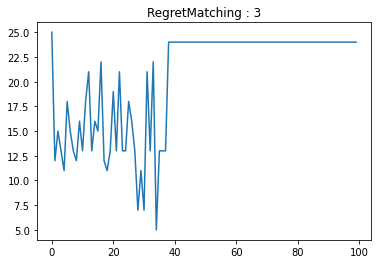

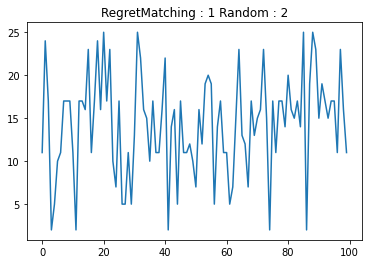

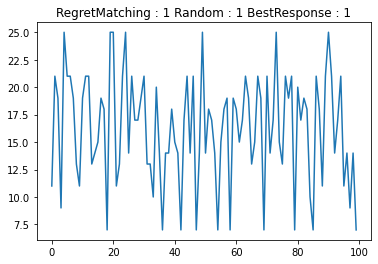

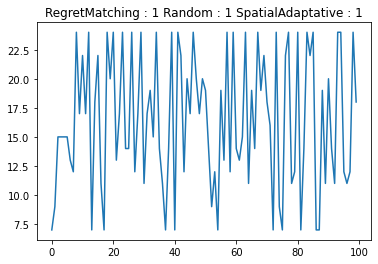

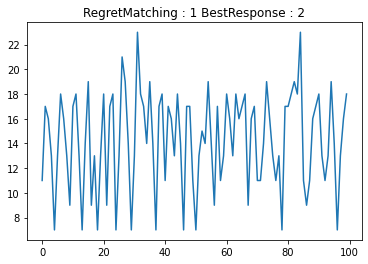

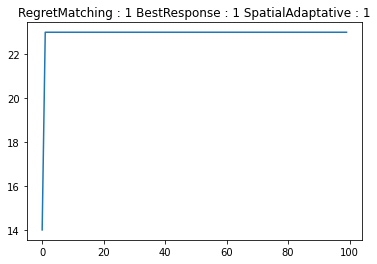

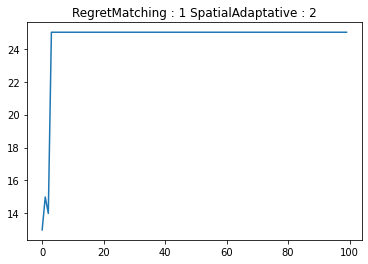

[DEBUG] (Player 1  ) Expected utility  [1.125    0.984375 1.15625  0.875   ]
[DEBUG] (Player 1  ) Expected utility  [1.125    0.984375 1.15625  0.875   ]
/home/orion/Téléchargements/MultiAgent_Negociation-main(3)/MultiAgent_Negociation-main/core/Player.py:84: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  it = np.nditer(self.env.utility[t], flags=['multi_index'])
[DEBUG] (Player 1  ) Expected utility  [0.9    0.7875 1.85   0.7   ]
[DEBUG] (Player 0  ) Expected utility  [1.296875 1.265625 1.15625  1.28125 ]
[DEBUG] (Player 1  ) Expected utility  [0.9    0.7875 1.85   0.7   ]
[DEBUG] (Player 2  ) Expected utility  [1.2375 1.375  1.1875 1.05  ]
[DEBUG] (Player 0  ) Expected utility  [1.225  1.2625 1.1125 1.2375]
[DEBUG] (Player 1  ) Expected utility  [0.75       0.6

[DEBUG] (Player 0  ) Expected utility  [0.17770083 4.32299169 0.20969529 0.06121884]
[DEBUG] (Player 1  ) Expected utility  [0.32867036 0.26551247 5.42049861 0.07922438]
[DEBUG] (Player 2  ) Expected utility  [0.36108033 4.8        0.40373961 0.07783934]
[DEBUG] (Player 0  ) Expected utility  [0.17770083 4.32299169 0.20969529 0.06121884]
[DEBUG] (Player 1  ) Expected utility  [0.31223684 0.25223684 5.47131579 0.07526316]
[DEBUG] (Player 2  ) Expected utility  [0.345125 4.86625  0.385125 0.072375]
[DEBUG] (Player 0  ) Expected utility  [0.16797619 4.35642857 0.19928571 0.05547619]
[DEBUG] (Player 1  ) Expected utility  [0.31392857 0.25428571 5.49464286 0.07404762]
[DEBUG] (Player 1  ) Expected utility  [0.29897959 0.24217687 5.54081633 0.07052154]
[DEBUG] (Player 0  ) Expected utility  [0.16797619 4.35642857 0.19928571 0.05547619]
[DEBUG] (Player 0  ) Expected utility  [0.15952381 4.38603896 0.18971861 0.05227273]
[DEBUG] (Player 1  ) Expected utility  [0.29897959 0.24217687 5.54081633 

[DEBUG] (Player 2  ) Expected utility  [0.20993586 5.33644315 0.23524198 0.02469971]
[DEBUG] (Player 0  ) Expected utility  [0.09185941 4.63047619 0.11414966 0.01873016]
[DEBUG] (Player 1  ) Expected utility  [0.18247354 0.15125661 6.13293651 0.03553792]
[DEBUG] (Player 2  ) Expected utility  [0.20458248 5.35429527 0.22927383 0.02338392]
[DEBUG] (Player 0  ) Expected utility  [0.09162809 4.62930813 0.11406893 0.01821845]
[DEBUG] (Player 1  ) Expected utility  [0.18261317 0.15155607 6.1408179  0.03549383]
[DEBUG] (Player 2  ) Expected utility  [0.20458248 5.35429527 0.22927383 0.02338392]
[DEBUG] (Player 0  ) Expected utility  [0.08915165 4.64068235 0.11098599 0.01772606]
[DEBUG] (Player 1  ) Expected utility  [0.17784677 0.14755296 6.15579093 0.03437221]
[DEBUG] (Player 2  ) Expected utility  [0.1994946  5.37121197 0.22359979 0.02217045]
[DEBUG] (Player 0  ) Expected utility  [0.08893846 4.63956725 0.1109115  0.01725465]
[DEBUG] (Player 1  ) Expected utility  [0.17797564 0.14782935 6.1

[DEBUG] (Player 0  ) Expected utility  [0.06173817 4.74524408 0.0783432  0.00902367]
[DEBUG] (Player 2  ) Expected utility  [0.14811028 5.54194222 0.16620983 0.01162403]
[DEBUG] (Player 2  ) Expected utility  [0.14814736 5.54051054 0.16630382 0.01151143]
[DEBUG] (Player 0  ) Expected utility  [0.06055238 4.75077549 0.07687327 0.00872962]
[DEBUG] (Player 1  ) Expected utility  [0.1288215  0.10787939 6.39504293 0.0229435 ]
[DEBUG] (Player 2  ) Expected utility  [0.14529837 5.54716981 0.16310567 0.01129005]
[DEBUG] (Player 2  ) Expected utility  [0.14541857 5.55052441 0.16319796 0.01119342]
[DEBUG] (Player 1  ) Expected utility  [0.12649588 0.10597804 6.40626284 0.0224416 ]
[DEBUG] (Player 0  ) Expected utility  [0.06053227 4.75082338 0.07688121 0.00861058]
[DEBUG] (Player 2  ) Expected utility  [0.14267483 5.55693626 0.16011876 0.01098222]
[DEBUG] (Player 1  ) Expected utility  [0.1265407  0.10607414 6.40998945 0.02242791]
[DEBUG] (Player 2  ) Expected utility  [0.14270928 5.55555556 0.1

[DEBUG] (Player 2  ) Expected utility  [0.11253099 5.65095156 0.12638473 0.00677194]
[DEBUG] (Player 2  ) Expected utility  [0.11253099 5.65095156 0.12638473 0.00677194]
[DEBUG] (Player 1  ) Expected utility  [0.10104323 0.08510755 6.53328513 0.01712028]
[DEBUG] (Player 0  ) Expected utility  [0.04649331 4.80647691 0.05968535 0.00516772]
[DEBUG] (Player 1  ) Expected utility  [0.09957813 0.08390063 6.54001178 0.01686224]
[DEBUG] (Player 1  ) Expected utility  [0.09960525 0.08391712 6.53999407 0.01683717]
[DEBUG] (Player 0  ) Expected utility  [0.0457613  4.80892761 0.05879291 0.00499834]
[DEBUG] (Player 2  ) Expected utility  [0.11102588 5.65796371 0.12467847 0.00653559]
[DEBUG] (Player 2  ) Expected utility  [0.11102588 5.65796371 0.12467847 0.00653559]
[DEBUG] (Player 2  ) Expected utility  [0.10943979 5.66163771 0.12289735 0.00644222]
[DEBUG] (Player 0  ) Expected utility  [0.0457613  4.80892761 0.05879291 0.00499834]
[DEBUG] (Player 1  ) Expected utility  [0.09816169 0.08270093 6.5

[DEBUG] (Player 2  ) Expected utility  [9.41072548e-02 5.71224186e+00 1.05714660e-01 4.59374967e-03]
[DEBUG] (Player 0  ) Expected utility  [3.77307054e-02 4.84151121e+00 4.87610153e-02 3.48912547e-03]
[DEBUG] (Player 1  ) Expected utility  [0.0820449  0.06930455 6.61853998 0.01350332]
[DEBUG] (Player 2  ) Expected utility  [9.41072548e-02 5.71224186e+00 1.05714660e-01 4.59374967e-03]
[DEBUG] (Player 2  ) Expected utility  [9.30132093e-02 5.71565172e+00 1.04487679e-01 4.48562959e-03]
[DEBUG] (Player 2  ) Expected utility  [9.30132093e-02 5.71565172e+00 1.04487679e-01 4.48562959e-03]
[DEBUG] (Player 0  ) Expected utility  [3.72580580e-02 4.84343112e+00 4.81758179e-02 3.37773998e-03]
[DEBUG] (Player 2  ) Expected utility  [9.19059092e-02 5.71820335e+00 1.03243778e-01 4.43222924e-03]
[DEBUG] (Player 1  ) Expected utility  [0.08110625 0.06853843 6.62454446 0.013322  ]
[DEBUG] (Player 0  ) Expected utility  [3.72580580e-02 4.84343112e+00 4.81758179e-02 3.37773998e-03]
[DEBUG] (Player 2  ) E

[DEBUG] (Player 0  ) Expected utility  [3.20958214e-02 4.86482136e+00 4.16611312e-02 2.54299961e-03]
[DEBUG] (Player 2  ) Expected utility  [7.99489407e-02 5.75449038e+00 8.98375226e-02 3.35007263e-03]
[DEBUG] (Player 1  ) Expected utility  [0.07049075 0.05967964 6.67422834 0.01137209]
[DEBUG] (Player 0  ) Expected utility  [3.17596483e-02 4.86620496e+00 4.12306064e-02 2.50953820e-03]
[DEBUG] (Player 2  ) Expected utility  [7.99744491e-02 5.75510204e+00 8.98672786e-02 3.31640787e-03]
[DEBUG] (Player 1  ) Expected utility  [0.06978085 0.05907654 6.67639557 0.01124746]
[DEBUG] (Player 1  ) Expected utility  [0.0697881  0.05909209 6.67751107 0.01124531]
[DEBUG] (Player 2  ) Expected utility  [7.91772561e-02 5.75798562e+00 8.89648446e-02 3.26713359e-03]
[DEBUG] (Player 0  ) Expected utility  [3.17511604e-02 4.86600836e+00 4.12253056e-02 2.50217907e-03]
[DEBUG] (Player 2  ) Expected utility  [7.91957476e-02 5.75897459e+00 8.89791291e-02 3.25201200e-03]
[DEBUG] (Player 0  ) Expected utility 

[DEBUG] (Player 2  ) Expected utility  [7.01669333e-02 5.78680998e+00 7.88483947e-02 2.54211741e-03]
[DEBUG] (Player 1  ) Expected utility  [0.06123039 0.0519192  6.71652927 0.00973295]
[DEBUG] (Player 0  ) Expected utility  [2.79153847e-02 4.88183810e+00 3.63555201e-02 1.95010736e-03]
[DEBUG] (Player 2  ) Expected utility  [6.95404429e-02 5.78824520e+00 7.81443912e-02 2.51941993e-03]
[DEBUG] (Player 1  ) Expected utility  [0.06123526 0.05192964 6.71738615 0.00973151]
[DEBUG] (Player 0  ) Expected utility  [2.76562215e-02 4.88290717e+00 3.60288926e-02 1.90330038e-03]
[DEBUG] (Player 2  ) Expected utility  [6.95444891e-02 5.78792508e+00 7.81541830e-02 2.50760181e-03]
[DEBUG] (Player 1  ) Expected utility  [0.06069961 0.05147403 6.71901808 0.0096397 ]
[DEBUG] (Player 0  ) Expected utility  [2.76506344e-02 4.88275818e+00 3.60254030e-02 1.89845020e-03]
[DEBUG] (Player 2  ) Expected utility  [6.89413815e-02 5.79009711e+00 7.74720864e-02 2.47530291e-03]
[DEBUG] (Player 2  ) Expected utility 

[DEBUG] (Player 2  ) Expected utility  [6.19890794e-02 5.81091048e+00 6.96716190e-02 2.00076190e-03]
[DEBUG] (Player 1  ) Expected utility  [0.0545553  0.04631897 6.74848224 0.00857042]
[DEBUG] (Player 0  ) Expected utility  [2.44978944e-02 4.89601705e+00 3.19949849e-02 1.50471711e-03]
[DEBUG] (Player 2  ) Expected utility  [6.20008438e-02 5.81127248e+00 6.96853991e-02 1.98512680e-03]
[DEBUG] (Player 1  ) Expected utility  [0.05455974 0.04632179 6.74847929 0.00856639]
[DEBUG] (Player 0  ) Expected utility  [2.44978944e-02 4.89601705e+00 3.19949849e-02 1.50471711e-03]
[DEBUG] (Player 2  ) Expected utility  [6.15126482e-02 5.81238853e+00 6.91366952e-02 1.96949588e-03]
[DEBUG] (Player 1  ) Expected utility  [0.05413349 0.04596423 6.7504436  0.00849795]
[DEBUG] (Player 0  ) Expected utility  [2.42996549e-02 4.89684205e+00 3.17411343e-02 1.48116832e-03]
[DEBUG] (Player 2  ) Expected utility  [6.15241388e-02 5.81274498e+00 6.91501540e-02 1.95422438e-03]
[DEBUG] (Player 2  ) Expected utility 

[DEBUG] (Player 1  ) Expected utility  [0.04918991 0.04179893 6.77286081 0.0076538 ]
[DEBUG] (Player 2  ) Expected utility  [5.59333090e-02 5.82998907e+00 6.28720845e-02 1.61042274e-03]
[DEBUG] (Player 0  ) Expected utility  [2.19865160e-02 4.90648724e+00 2.87733236e-02 1.21938776e-03]
[DEBUG] (Player 1  ) Expected utility  [0.04884354 0.04150782 6.77446374 0.00759878]
[DEBUG] (Player 2  ) Expected utility  [5.59397163e-02 5.83048126e+00 6.28770444e-02 1.60515270e-03]
[DEBUG] (Player 0  ) Expected utility  [2.18277321e-02 4.90715256e+00 2.85674765e-02 1.20826058e-03]
[DEBUG] (Player 1  ) Expected utility  [0.04884671 0.04150984 6.77446162 0.00759591]
[DEBUG] (Player 2  ) Expected utility  [5.55450319e-02 5.83118491e+00 6.24360334e-02 1.58781630e-03]
[DEBUG] (Player 0  ) Expected utility  [2.18266772e-02 4.90715502e+00 2.85678511e-02 1.20218848e-03]
[DEBUG] (Player 1  ) Expected utility  [0.04850515 0.04122274 6.7760421  0.0075417 ]
[DEBUG] (Player 2  ) Expected utility  [5.55513049e-02

[DEBUG] (Player 2  ) Expected utility  [5.09473028e-02 5.84532827e+00 5.72721468e-02 1.33259808e-03]
[DEBUG] (Player 1  ) Expected utility  [0.04478887 0.03809107 6.79384572 0.00691299]
[DEBUG] (Player 0  ) Expected utility  [1.98132199e-02 4.91567201e+00 2.59723938e-02 1.00163766e-03]
[DEBUG] (Player 2  ) Expected utility  [5.09488626e-02 5.84516129e+00 5.72758829e-02 1.32808122e-03]
[DEBUG] (Player 1  ) Expected utility  [0.04449991 0.03784532 6.79471654 0.00686839]
[DEBUG] (Player 0  ) Expected utility  [1.96840794e-02 4.91621363e+00 2.58045718e-02 9.93361477e-04]
[DEBUG] (Player 2  ) Expected utility  [5.06264842e-02 5.84615385e+00 5.69137384e-02 1.31113424e-03]
[DEBUG] (Player 1  ) Expected utility  [0.04450412 0.0378508  6.79516529 0.00686571]
[DEBUG] (Player 0  ) Expected utility  [1.96832893e-02 4.91621548e+00 2.58048507e-02 9.88820406e-04]
[DEBUG] (Player 2  ) Expected utility  [5.06264842e-02 5.84615385e+00 5.69137384e-02 1.31113424e-03]
[DEBUG] (Player 1  ) Expected utility 

[DEBUG] (Player 0  ) Expected utility  [1.82439432e-02 4.92209368e+00 2.39487213e-02 8.49526644e-04]
[DEBUG] (Player 2  ) Expected utility  [4.67810768e-02 5.85847246e+00 5.25908958e-02 1.11785345e-03]
[DEBUG] (Player 0  ) Expected utility  [1.82433180e-02 4.92209513e+00 2.39489410e-02 8.45937487e-04]
[DEBUG] (Player 2  ) Expected utility  [4.67810768e-02 5.85847246e+00 5.25908958e-02 1.11785345e-03]
[DEBUG] (Player 0  ) Expected utility  [1.81347553e-02 4.92262611e+00 2.38074471e-02 8.37406245e-04]
[DEBUG] (Player 1  ) Expected utility  [4.08648861e-02 3.47782562e-02 6.81201266e+00 6.26728756e-03]
[DEBUG] (Player 2  ) Expected utility  [4.65054656e-02 5.85896231e+00 5.22825743e-02 1.10777120e-03]
[DEBUG] (Player 0  ) Expected utility  [1.81347553e-02 4.92262611e+00 2.38074471e-02 8.37406245e-04]
[DEBUG] (Player 1  ) Expected utility  [4.08648861e-02 3.47782562e-02 6.81201266e+00 6.26728756e-03]
[DEBUG] (Player 2  ) Expected utility  [4.65054656e-02 5.85896231e+00 5.22825743e-02 1.1077

[DEBUG] (Player 0  ) Expected utility  [1.68159273e-02 4.92823986e+00 2.20984412e-02 7.26205207e-04]
[DEBUG] (Player 1  ) Expected utility  [3.79813405e-02 3.23390561e-02 6.82502280e+00 5.79673499e-03]
[DEBUG] (Player 2  ) Expected utility  [4.32382947e-02 5.86897220e+00 4.86120419e-02 9.55948411e-04]
[DEBUG] (Player 0  ) Expected utility  [1.68141091e-02 4.92818245e+00 2.20977851e-02 7.22227899e-04]
[DEBUG] (Player 1  ) Expected utility  [3.79824861e-02 3.23415113e-02 6.82535023e+00 5.79640140e-03]
[DEBUG] (Player 2  ) Expected utility  [4.32382947e-02 5.86897220e+00 4.86120419e-02 9.55948411e-04]
[DEBUG] (Player 0  ) Expected utility  [1.67222287e-02 4.92863379e+00 2.19770322e-02 7.18281298e-04]
[DEBUG] (Player 0  ) Expected utility  [1.67204401e-02 4.92857699e+00 2.19763867e-02 7.14368816e-04]
[DEBUG] (Player 2  ) Expected utility  [4.30058838e-02 5.86968366e+00 4.83509225e-02 9.45584122e-04]
[DEBUG] (Player 1  ) Expected utility  [3.77763865e-02 3.21657202e-02 6.82597435e+00 5.7634

[DEBUG] (Player 2  ) Expected utility  [4.04007836e-02 5.87755102e+00 4.54248682e-02 8.31085886e-04]
[DEBUG] (Player 1  ) Expected utility  [3.54810879e-02 3.02246106e-02 6.83691986e+00 5.39011660e-03]
[DEBUG] (Player 0  ) Expected utility  [1.55927223e-02 4.93338754e+00 2.05120155e-02 6.26065022e-04]
[DEBUG] (Player 2  ) Expected utility  [4.04007836e-02 5.87755102e+00 4.54248682e-02 8.31085886e-04]
[DEBUG] (Player 1  ) Expected utility  [3.53000619e-02 3.00704034e-02 6.83746489e+00 5.36261600e-03]
[DEBUG] (Player 0  ) Expected utility  [1.55125150e-02 4.93372620e+00 2.04072336e-02 6.21966866e-04]
[DEBUG] (Player 2  ) Expected utility  [4.01977972e-02 5.87817259e+00 4.51967719e-02 8.22679636e-04]
[DEBUG] (Player 1  ) Expected utility  [3.53021531e-02 3.00731294e-02 6.83774672e+00 5.36129193e-03]
[DEBUG] (Player 0  ) Expected utility  [1.55121227e-02 4.93372712e+00 2.04073704e-02 6.19718518e-04]
[DEBUG] (Player 2  ) Expected utility  [4.01977972e-02 5.87817259e+00 4.51967719e-02 8.2267

[DEBUG] (Player 2  ) Expected utility  [3.77325650e-02 5.88580519e+00 4.24256810e-02 7.25902199e-04]
[DEBUG] (Player 0  ) Expected utility  [1.46049069e-02 4.93750373e+00 1.92296718e-02 5.47904452e-04]
[DEBUG] (Player 1  ) Expected utility  [3.31291599e-02 2.82329621e-02 6.84778082e+00 5.01362148e-03]
[DEBUG] (Player 1  ) Expected utility  [3.29723660e-02 2.80991440e-02 6.84825505e+00 4.98887912e-03]
[DEBUG] (Player 0  ) Expected utility  [1.45353597e-02 4.93784614e+00 1.91381019e-02 5.45295383e-04]
[DEBUG] (Player 2  ) Expected utility  [3.77325650e-02 5.88580519e+00 4.24256810e-02 7.25902199e-04]
[DEBUG] (Player 1  ) Expected utility  [3.29723660e-02 2.80991440e-02 6.84825505e+00 4.98887912e-03]
[DEBUG] (Player 0  ) Expected utility  [1.45344964e-02 4.93780197e+00 1.91375625e-02 5.44543176e-04]
[DEBUG] (Player 2  ) Expected utility  [3.75554476e-02 5.88634597e+00 4.22266494e-02 7.19036821e-04]
[DEBUG] (Player 1  ) Expected utility  [3.28168424e-02 2.79675662e-02 6.84897185e+00 4.9650

[DEBUG] (Player 1  ) Expected utility  [3.12090761e-02 2.66055866e-02 6.85664554e+00 4.70741011e-03]
[DEBUG] (Player 0  ) Expected utility  [1.36742912e-02 4.94148311e+00 1.80174721e-02 4.83515876e-04]
[DEBUG] (Player 2  ) Expected utility  [3.53939070e-02 5.89273864e+00 3.97981383e-02 6.39320976e-04]
[DEBUG] (Player 1  ) Expected utility  [3.10705549e-02 2.64881397e-02 6.85728487e+00 4.68539484e-03]
[DEBUG] (Player 2  ) Expected utility  [3.53960430e-02 5.89285714e+00 3.98006301e-02 6.36485466e-04]
[DEBUG] (Player 1  ) Expected utility  [3.10713532e-02 2.64886578e-02 6.85728434e+00 4.68467666e-03]
[DEBUG] (Player 0  ) Expected utility  [1.36112847e-02 4.94170707e+00 1.79363284e-02 4.77070711e-04]
[DEBUG] (Player 1  ) Expected utility  [3.09332578e-02 2.63717251e-02 6.85791852e+00 4.66358418e-03]
[DEBUG] (Player 2  ) Expected utility  [3.52396173e-02 5.89341251e+00 3.96241836e-02 6.32327778e-04]
[DEBUG] (Player 0  ) Expected utility  [1.36112847e-02 4.94170707e+00 1.79363284e-02 4.7707

[DEBUG] (Player 1  ) Expected utility  [2.93755691e-02 2.50505620e-02 6.86510564e+00 4.41683424e-03]
[DEBUG] (Player 2  ) Expected utility  [3.34705137e-02 5.89880553e+00 3.76359834e-02 5.69906733e-04]
[DEBUG] (Player 0  ) Expected utility  [1.28542134e-02 4.94495207e+00 1.69486980e-02 4.28031860e-04]
[DEBUG] (Player 1  ) Expected utility  [2.92522928e-02 2.49452998e-02 6.86547815e+00 4.39759431e-03]
[DEBUG] (Player 2  ) Expected utility  [3.33310722e-02 5.89923042e+00 3.74792678e-02 5.65126957e-04]
[DEBUG] (Player 0  ) Expected utility  [1.28533893e-02 4.94491781e+00 1.69484001e-02 4.26230274e-04]
[DEBUG] (Player 0  ) Expected utility  [1.27993835e-02 4.94518418e+00 1.68771883e-02 4.24439391e-04]
[DEBUG] (Player 2  ) Expected utility  [3.33310722e-02 5.89923042e+00 3.74792678e-02 5.65126957e-04]
[DEBUG] (Player 1  ) Expected utility  [2.92528132e-02 2.49464151e-02 6.86567188e+00 4.39744343e-03]
[DEBUG] (Player 0  ) Expected utility  [1.27993835e-02 4.94518418e+00 1.68771883e-02 4.2443

[DEBUG] (Player 2  ) Expected utility  [3.16186240e-02 5.90444608e+00 3.55546240e-02 5.08096000e-04]
[DEBUG] (Player 0  ) Expected utility  [1.21754240e-02 4.94779334e+00 1.60636160e-02 3.83104000e-04]
[DEBUG] (Player 1  ) Expected utility  [2.77455360e-02 2.36672640e-02 6.87262285e+00 4.16000000e-03]
[DEBUG] (Player 2  ) Expected utility  [3.16186240e-02 5.90444608e+00 3.55546240e-02 5.08096000e-04]
[DEBUG] (Player 0  ) Expected utility  [1.21269163e-02 4.94803276e+00 1.59996175e-02 3.81577689e-04]
[DEBUG] (Player 1  ) Expected utility  [2.76355613e-02 2.35733401e-02 6.87295503e+00 4.14291837e-03]
[DEBUG] (Player 2  ) Expected utility  [3.14941564e-02 5.90482501e+00 3.54147291e-02 5.04070921e-04]
[DEBUG] (Player 0  ) Expected utility  [1.21262225e-02 4.94800215e+00 1.59993666e-02 3.80061001e-04]
[DEBUG] (Player 1  ) Expected utility  [2.76359997e-02 2.35742796e-02 6.87312786e+00 4.14279138e-03]
[DEBUG] (Player 2  ) Expected utility  [3.14941564e-02 5.90482501e+00 3.54147291e-02 5.0407

[DEBUG] (Player 0  ) Expected utility  [1.15209755e-02 4.95057219e+00 1.52085812e-02 3.43591737e-04]
[DEBUG] (Player 1  ) Expected utility  [2.62868875e-02 2.24287360e-02 6.87934647e+00 3.93135904e-03]
[DEBUG] (Player 2  ) Expected utility  [2.99609060e-02 5.90949102e+00 3.36913927e-02 4.55821559e-04]
[DEBUG] (Player 0  ) Expected utility  [1.15209755e-02 4.95057219e+00 1.52085812e-02 3.43591737e-04]
[DEBUG] (Player 1  ) Expected utility  [2.62868875e-02 2.24287360e-02 6.87934647e+00 3.93135904e-03]
[DEBUG] (Player 2  ) Expected utility  [2.99609060e-02 5.90949102e+00 3.36913927e-02 4.55821559e-04]
[DEBUG] (Player 0  ) Expected utility  [1.14775001e-02 4.95078692e+00 1.51511903e-02 3.42295164e-04]
[DEBUG] (Player 0  ) Expected utility  [1.14769105e-02 4.95075941e+00 1.51509770e-02 3.41006334e-04]
[DEBUG] (Player 2  ) Expected utility  [2.98491238e-02 5.90983107e+00 3.35657489e-02 4.52400304e-04]
[DEBUG] (Player 1  ) Expected utility  [2.61881722e-02 2.23444124e-02 6.87964454e+00 3.9160

[DEBUG] (Player 1  ) Expected utility  [2.50633612e-02 2.13893589e-02 6.88498397e+00 3.74043712e-03]
[DEBUG] (Player 2  ) Expected utility  [2.85700063e-02 5.91372091e+00 3.21279831e-02 4.14182166e-04]
[DEBUG] (Player 0  ) Expected utility  [1.09337910e-02 4.95309522e+00 1.44401519e-02 3.11007694e-04]
[DEBUG] (Player 1  ) Expected utility  [2.49736216e-02 2.13126904e-02 6.88525485e+00 3.72660862e-03]
[DEBUG] (Player 2  ) Expected utility  [2.84683438e-02 5.91402997e+00 3.20137089e-02 4.11218047e-04]
[DEBUG] (Player 0  ) Expected utility  [1.09332802e-02 4.95307018e+00 1.44399671e-02 3.09891314e-04]
[DEBUG] (Player 1  ) Expected utility  [2.49739446e-02 2.13133825e-02 6.88539588e+00 3.72651519e-03]
[DEBUG] (Player 2  ) Expected utility  [2.84683438e-02 5.91402997e+00 3.20137089e-02 4.11218047e-04]
[DEBUG] (Player 0  ) Expected utility  [1.08935875e-02 4.95323898e+00 1.43880281e-02 3.07676171e-04]
[DEBUG] (Player 1  ) Expected utility  [2.48851636e-02 2.12379440e-02 6.88580485e+00 3.7126

[DEBUG] (Player 2  ) Expected utility  [2.72089289e-02 5.91773834e+00 3.05982818e-02 3.76015627e-04]
[DEBUG] (Player 0  ) Expected utility  [1.04033864e-02 4.95537374e+00 1.37456639e-02 2.82161913e-04]
[DEBUG] (Player 0  ) Expected utility  [1.04030630e-02 4.95535056e+00 1.37454618e-02 2.81879796e-04]
[DEBUG] (Player 2  ) Expected utility  [2.72098931e-02 5.91780822e+00 3.05994067e-02 3.74734317e-04]
[DEBUG] (Player 1  ) Expected utility  [2.38673730e-02 2.03728724e-02 6.89049395e+00 3.55419283e-03]
[DEBUG] (Player 0  ) Expected utility  [1.03675577e-02 4.95552613e+00 1.36985490e-02 2.80917749e-04]
[DEBUG] (Player 2  ) Expected utility  [2.71169431e-02 5.91797266e+00 3.04951689e-02 3.72778891e-04]
[DEBUG] (Player 1  ) Expected utility  [2.38680110e-02 2.03737059e-02 6.89062159e+00 3.55379062e-03]
[DEBUG] (Player 0  ) Expected utility  [1.03674384e-02 4.95552641e+00 1.36985900e-02 2.80236863e-04]
[DEBUG] (Player 2  ) Expected utility  [2.71169431e-02 5.91797266e+00 3.04951689e-02 3.7277

[DEBUG] (Player 0  ) Expected utility  [9.95438303e-03 4.95725891e+00 1.31576819e-02 2.58347146e-04]
[DEBUG] (Player 1  ) Expected utility  [2.27794240e-02 1.94476584e-02 6.89538332e+00 3.38625723e-03]
[DEBUG] (Player 2  ) Expected utility  [2.59729581e-02 5.92161141e+00 2.92086474e-02 3.41843590e-04]
[DEBUG] (Player 0  ) Expected utility  [9.95399615e-03 4.95723804e+00 1.31575418e-02 2.57501729e-04]
[DEBUG] (Player 1  ) Expected utility  [2.27796688e-02 1.94481829e-02 6.89550057e+00 3.38618651e-03]
[DEBUG] (Player 2  ) Expected utility  [2.59729581e-02 5.92161141e+00 2.92086474e-02 3.41843590e-04]
[DEBUG] (Player 0  ) Expected utility  [9.92146675e-03 4.95739897e+00 1.31145433e-02 2.56660220e-04]
[DEBUG] (Player 1  ) Expected utility  [2.27055378e-02 1.93848310e-02 6.89572422e+00 3.37484042e-03]
[DEBUG] (Player 2  ) Expected utility  [2.58889101e-02 5.92186661e+00 2.91141654e-02 3.39619950e-04]
[DEBUG] (Player 0  ) Expected utility  [9.92108365e-03 4.95737824e+00 1.31144046e-02 2.5582

[DEBUG] (Player 2  ) Expected utility  [2.49213573e-02 5.92476489e+00 2.80267040e-02 3.14025216e-04]
[DEBUG] (Player 1  ) Expected utility  [2.18553800e-02 1.86620257e-02 6.89975599e+00 3.24329459e-03]
[DEBUG] (Player 0  ) Expected utility  [9.51220789e-03 4.95912055e+00 1.25783079e-02 2.35415462e-04]
[DEBUG] (Player 1  ) Expected utility  [2.17870818e-02 1.86039826e-02 6.90006922e+00 3.23306571e-03]
[DEBUG] (Player 0  ) Expected utility  [9.51220789e-03 4.95912055e+00 1.25783079e-02 2.35415462e-04]
[DEBUG] (Player 2  ) Expected utility  [2.48437862e-02 5.92503912e+00 2.79392746e-02 3.12583184e-04]
[DEBUG] (Player 1  ) Expected utility  [2.17870818e-02 1.86039826e-02 6.90006922e+00 3.23306571e-03]
[DEBUG] (Player 0  ) Expected utility  [9.48248224e-03 4.95926767e+00 1.25390007e-02 2.34679789e-04]
[DEBUG] (Player 2  ) Expected utility  [2.48439665e-02 5.92500000e+00 2.79397006e-02 3.12067000e-04]
[DEBUG] (Player 1  ) Expected utility  [2.17192704e-02 1.85460240e-02 6.90027374e+00 3.2227

[DEBUG] (Player 2  ) Expected utility  [2.38792775e-02 5.92787415e+00 2.68551456e-02 2.89057076e-04]
[DEBUG] (Player 1  ) Expected utility  [2.09398342e-02 1.78831617e-02 6.90396779e+00 3.10277254e-03]
[DEBUG] (Player 0  ) Expected utility  [9.10826090e-03 4.96086185e+00 1.20480293e-02 2.16703131e-04]
[DEBUG] (Player 2  ) Expected utility  [2.38799276e-02 5.92792793e+00 2.68559040e-02 2.88192823e-04]
[DEBUG] (Player 1  ) Expected utility  [2.09400775e-02 1.78833210e-02 6.90396763e+00 3.10255458e-03]
[DEBUG] (Player 0  ) Expected utility  [9.10826090e-03 4.96086185e+00 1.20480293e-02 2.16703131e-04]
[DEBUG] (Player 2  ) Expected utility  [2.38082161e-02 5.92809025e+00 2.67752557e-02 2.87327379e-04]
[DEBUG] (Player 1  ) Expected utility  [2.08773825e-02 1.78300206e-02 6.90425512e+00 3.09318327e-03]
[DEBUG] (Player 2  ) Expected utility  [2.38088604e-02 5.92814371e+00 2.67760073e-02 2.86470859e-04]
[DEBUG] (Player 1  ) Expected utility  [2.08776236e-02 1.78301785e-02 6.90425496e+00 3.0929

[DEBUG] (Player 2  ) Expected utility  [2.29213273e-02 5.93081965e+00 2.57779915e-02 2.66592849e-04]
[DEBUG] (Player 0  ) Expected utility  [8.78785056e-03 4.96221013e+00 1.16276632e-02 2.01297377e-04]
[DEBUG] (Player 1  ) Expected utility  [2.00979274e-02 1.71667148e-02 6.90783993e+00 2.97389813e-03]
[DEBUG] (Player 2  ) Expected utility  [2.29217602e-02 5.93090246e+00 2.57783275e-02 2.66233952e-04]
[DEBUG] (Player 0  ) Expected utility  [8.76218708e-03 4.96231966e+00 1.15939612e-02 2.00136469e-04]
[DEBUG] (Player 1  ) Expected utility  [2.00402239e-02 1.71173843e-02 6.90801390e+00 2.96513468e-03]
[DEBUG] (Player 1  ) Expected utility  [2.00403903e-02 1.71177408e-02 6.90810459e+00 2.96508667e-03]
[DEBUG] (Player 0  ) Expected utility  [8.76192353e-03 4.96230348e+00 1.15938657e-02 1.99560678e-04]
[DEBUG] (Player 0  ) Expected utility  [8.73648273e-03 4.96241231e+00 1.15603351e-02 1.98819483e-04]
[DEBUG] (Player 1  ) Expected utility  [1.99828029e-02 1.70685519e-02 6.90827771e+00 2.9565

[DEBUG] (Player 1  ) Expected utility  [1.93749804e-02 1.65512532e-02 6.91116573e+00 2.86310628e-03]
[DEBUG] (Player 2  ) Expected utility  [2.20987904e-02 5.93336424e+00 2.48532693e-02 2.46972661e-04]
[DEBUG] (Player 0  ) Expected utility  [8.41825232e-03 4.96380408e+00 1.11419320e-02 1.85399279e-04]
[DEBUG] (Player 1  ) Expected utility  [1.93213530e-02 1.65054034e-02 6.91132738e+00 2.85498126e-03]
[DEBUG] (Player 2  ) Expected utility  [2.20379158e-02 5.93354874e+00 2.47848294e-02 2.45606139e-04]
[DEBUG] (Player 0  ) Expected utility  [8.41801698e-03 4.96378903e+00 1.11418467e-02 1.84885117e-04]
[DEBUG] (Player 1  ) Expected utility  [1.93215021e-02 1.65057227e-02 6.91141165e+00 2.85493827e-03]
[DEBUG] (Player 2  ) Expected utility  [2.20379158e-02 5.93354874e+00 2.47848294e-02 2.45606139e-04]
[DEBUG] (Player 0  ) Expected utility  [8.39469837e-03 4.96390458e+00 1.11109829e-02 1.84372969e-04]
[DEBUG] (Player 1  ) Expected utility  [1.92681703e-02 1.64601254e-02 6.91157241e+00 2.8468

[DEBUG] (Player 0  ) Expected utility  [8.12184283e-03 4.96505429e+00 1.07524756e-02 1.72559743e-04]
[DEBUG] (Player 1  ) Expected utility  [1.86520833e-02 1.59355474e-02 6.91441056e+00 2.75287953e-03]
[DEBUG] (Player 2  ) Expected utility  [2.12760095e-02 5.93585751e+00 2.39282243e-02 2.28826924e-04]
[DEBUG] (Player 2  ) Expected utility  [2.12764665e-02 5.93589979e+00 2.39287582e-02 2.28218222e-04]
[DEBUG] (Player 0  ) Expected utility  [8.09985942e-03 4.96514810e+00 1.07236692e-02 1.71312926e-04]
[DEBUG] (Player 1  ) Expected utility  [1.86026493e-02 1.58936227e-02 6.91471698e+00 2.74528868e-03]
[DEBUG] (Player 2  ) Expected utility  [2.12195775e-02 5.93602848e+00 2.38647776e-02 2.27608013e-04]
[DEBUG] (Player 0  ) Expected utility  [8.09985942e-03 4.96514810e+00 1.07236692e-02 1.71312926e-04]
[DEBUG] (Player 1  ) Expected utility  [1.86026493e-02 1.58936227e-02 6.91471698e+00 2.74528868e-03]
[DEBUG] (Player 1  ) Expected utility  [1.85532121e-02 1.58513512e-02 6.91486597e+00 2.7378

[DEBUG] (Player 0  ) Expected utility  [7.82541862e-03 4.96633487e+00 1.03625902e-02 1.60419131e-04]
[DEBUG] (Player 2  ) Expected utility  [2.05119857e-02 5.93810468e+00 2.30693264e-02 2.12866675e-04]
[DEBUG] (Player 1  ) Expected utility  [1.79814382e-02 1.53645399e-02 6.91757275e+00 2.65074882e-03]
[DEBUG] (Player 0  ) Expected utility  [7.82522915e-03 4.96632183e+00 1.03625216e-02 1.60005237e-04]
[DEBUG] (Player 2  ) Expected utility  [2.05122952e-02 5.93817093e+00 2.30695668e-02 2.12609934e-04]
[DEBUG] (Player 1  ) Expected utility  [1.79814382e-02 1.53645399e-02 6.91757275e+00 2.65074882e-03]
[DEBUG] (Player 0  ) Expected utility  [7.80506103e-03 4.96642183e+00 1.03358141e-02 1.59592852e-04]
[DEBUG] (Player 2  ) Expected utility  [2.04595296e-02 5.93826390e+00 2.30103476e-02 2.11772883e-04]
[DEBUG] (Player 1  ) Expected utility  [1.79353668e-02 1.53252965e-02 6.91778453e+00 2.64374535e-03]
[DEBUG] (Player 0  ) Expected utility  [7.80487302e-03 4.96640885e+00 1.03357459e-02 1.5918

[DEBUG] (Player 1  ) Expected utility  [1.74003750e-02 1.48695469e-02 6.92024347e+00 2.56250000e-03]
[DEBUG] (Player 2  ) Expected utility  [1.98506406e-02 5.94017453e+00 2.23256406e-02 1.99046875e-04]
[DEBUG] (Player 0  ) Expected utility  [7.54973504e-03 4.96751269e+00 9.99990648e-03 1.49407731e-04]
[DEBUG] (Player 1  ) Expected utility  [1.73571215e-02 1.48325570e-02 6.92037378e+00 2.55598535e-03]
[DEBUG] (Player 2  ) Expected utility  [1.98015077e-02 5.94032329e+00 2.22703978e-02 1.98057725e-04]
[DEBUG] (Player 0  ) Expected utility  [7.54956472e-03 4.96750053e+00 9.99984476e-03 1.49035686e-04]
[DEBUG] (Player 1  ) Expected utility  [1.73572294e-02 1.48327882e-02 6.92044176e+00 2.55595425e-03]
[DEBUG] (Player 2  ) Expected utility  [1.98015077e-02 5.94032329e+00 2.22703978e-02 1.98057725e-04]
[DEBUG] (Player 0  ) Expected utility  [7.53078471e-03 4.96759367e+00 9.97496953e-03 1.48664950e-04]
[DEBUG] (Player 1  ) Expected utility  [1.73141902e-02 1.47959814e-02 6.92057143e+00 2.5494

[DEBUG] (Player 2  ) Expected utility  [1.91842227e-02 5.94219193e+00 2.15763439e-02 1.85842476e-04]
[DEBUG] (Player 0  ) Expected utility  [7.31042884e-03 4.96852348e+00 9.68508896e-03 1.39829305e-04]
[DEBUG] (Player 1  ) Expected utility  [1.68151997e-02 1.43709491e-02 6.92293260e+00 2.47380336e-03]
[DEBUG] (Player 2  ) Expected utility  [1.91842227e-02 5.94219193e+00 2.15763439e-02 1.85842476e-04]
[DEBUG] (Player 0  ) Expected utility  [7.29281335e-03 4.96861087e+00 9.66175140e-03 1.39492367e-04]
[DEBUG] (Player 1  ) Expected utility  [1.67748066e-02 1.43364027e-02 6.92305428e+00 2.46773018e-03]
[DEBUG] (Player 2  ) Expected utility  [1.91383295e-02 5.94233083e+00 2.15247426e-02 1.84949990e-04]
[DEBUG] (Player 0  ) Expected utility  [7.29265968e-03 4.96859951e+00 9.66169570e-03 1.39156714e-04]
[DEBUG] (Player 1  ) Expected utility  [1.67749039e-02 1.43366114e-02 6.92311776e+00 2.46770213e-03]
[DEBUG] (Player 2  ) Expected utility  [1.91383295e-02 5.94233083e+00 2.15247426e-02 1.8494

[DEBUG] (Player 2  ) Expected utility  [1.86044889e-02 5.94400130e+00 2.09244196e-02 1.74533014e-04]
[DEBUG] (Player 0  ) Expected utility  [7.06931800e-03 4.96955538e+00 9.36754087e-03 1.31054163e-04]
[DEBUG] (Player 1  ) Expected utility  [1.62680137e-02 1.39045130e-02 6.92538662e+00 2.39106409e-03]
[DEBUG] (Player 2  ) Expected utility  [1.85610959e-02 5.94407770e+00 2.08757085e-02 1.73909712e-04]
[DEBUG] (Player 0  ) Expected utility  [7.06927992e-03 4.96955547e+00 9.36755383e-03 1.30837244e-04]
[DEBUG] (Player 2  ) Expected utility  [1.85613237e-02 5.94413166e+00 2.08758855e-02 1.73720651e-04]
[DEBUG] (Player 0  ) Expected utility  [7.05266229e-03 4.96962660e+00 9.34566762e-03 1.30228405e-04]
[DEBUG] (Player 1  ) Expected utility  [1.62303831e-02 1.38725549e-02 6.92561961e+00 2.38533805e-03]
[DEBUG] (Player 2  ) Expected utility  [1.85181322e-02 5.94420770e+00 2.08274003e-02 1.73101694e-04]
[DEBUG] (Player 0  ) Expected utility  [7.05266229e-03 4.96962660e+00 9.34566762e-03 1.3022

[DEBUG] (Player 1  ) Expected utility  [1.57910255e-02 1.34980571e-02 6.92763797e+00 2.31899260e-03]
[DEBUG] (Player 2  ) Expected utility  [1.80176622e-02 5.94572185e+00 2.02646684e-02 1.63829258e-04]
[DEBUG] (Player 0  ) Expected utility  [6.84365845e-03 4.97053197e+00 9.07022499e-03 1.22963308e-04]
[DEBUG] (Player 1  ) Expected utility  [1.57554030e-02 1.34675868e-02 6.92774525e+00 2.31365316e-03]
[DEBUG] (Player 1  ) Expected utility  [1.57554836e-02 1.34677596e-02 6.92780123e+00 2.31362994e-03]
[DEBUG] (Player 0  ) Expected utility  [6.84353124e-03 4.97052194e+00 9.07017887e-03 1.22685478e-04]
[DEBUG] (Player 2  ) Expected utility  [1.79771747e-02 5.94584433e+00 2.02191435e-02 1.63090390e-04]
[DEBUG] (Player 1  ) Expected utility  [1.57199182e-02 1.34373583e-02 6.92790810e+00 2.30840730e-03]
[DEBUG] (Player 0  ) Expected utility  [6.82799110e-03 4.97058855e+00 9.04964694e-03 1.22328202e-04]
[DEBUG] (Player 2  ) Expected utility  [1.79774499e-02 5.94587454e+00 2.02194649e-02 1.6272

[DEBUG] (Player 1  ) Expected utility  [1.53075109e-02 1.30857592e-02 6.92980569e+00 2.24612682e-03]
[DEBUG] (Player 0  ) Expected utility  [6.64647644e-03 4.97136593e+00 8.81045565e-03 1.15959947e-04]
[DEBUG] (Player 2  ) Expected utility  [1.74669248e-02 5.94738768e+00 1.96454057e-02 1.53923121e-04]
[DEBUG] (Player 1  ) Expected utility  [1.52740156e-02 1.30572204e-02 6.92995939e+00 2.24117987e-03]
[DEBUG] (Player 0  ) Expected utility  [6.63178484e-03 4.97142886e+00 8.79109253e-03 1.15451838e-04]
[DEBUG] (Player 2  ) Expected utility  [1.74671771e-02 5.94741620e+00 1.96457004e-02 1.53586987e-04]
[DEBUG] (Player 1  ) Expected utility  [1.52741101e-02 1.30572826e-02 6.92995932e+00 2.24109532e-03]
[DEBUG] (Player 0  ) Expected utility  [6.63178484e-03 4.97142886e+00 8.79109253e-03 1.15451838e-04]
[DEBUG] (Player 2  ) Expected utility  [1.74288719e-02 5.94750276e+00 1.96026177e-02 1.53250173e-04]
[DEBUG] (Player 1  ) Expected utility  [1.52407608e-02 1.30288679e-02 6.93011235e+00 2.2361

[DEBUG] (Player 0  ) Expected utility  [6.44651011e-03 4.97222255e+00 8.54691153e-03 1.08974542e-04]
[DEBUG] (Player 1  ) Expected utility  [1.48528656e-02 1.26981999e-02 6.93194685e+00 2.17765877e-03]
[DEBUG] (Player 2  ) Expected utility  [1.69488565e-02 5.94895430e+00 1.90628676e-02 1.44889030e-04]
[DEBUG] (Player 0  ) Expected utility  [6.44651011e-03 4.97222255e+00 8.54691153e-03 1.08974542e-04]
[DEBUG] (Player 1  ) Expected utility  [1.48528656e-02 1.26981999e-02 6.93194685e+00 2.17765877e-03]
[DEBUG] (Player 2  ) Expected utility  [1.69488565e-02 5.94895430e+00 1.90628676e-02 1.44889030e-04]
[DEBUG] (Player 0  ) Expected utility  [6.43279413e-03 4.97229066e+00 8.52872661e-03 1.08742681e-04]
[DEBUG] (Player 1  ) Expected utility  [1.48213501e-02 1.26712393e-02 6.93204174e+00 2.17294823e-03]
[DEBUG] (Player 2  ) Expected utility  [1.69130251e-02 5.94906264e+00 1.90225769e-02 1.44274390e-04]
[DEBUG] (Player 0  ) Expected utility  [6.43268833e-03 4.97228178e+00 8.52868825e-03 1.0851

[DEBUG] (Player 1  ) Expected utility  [1.44541666e-02 1.23581972e-02 6.93377767e+00 2.11773213e-03]
[DEBUG] (Player 2  ) Expected utility  [1.64945725e-02 5.95032772e+00 1.85520440e-02 1.37193936e-04]
[DEBUG] (Player 0  ) Expected utility  [6.25834956e-03 4.97303776e+00 8.29870172e-03 1.02965363e-04]
[DEBUG] (Player 1  ) Expected utility  [1.44243203e-02 1.23326633e-02 6.93386752e+00 2.11327645e-03]
[DEBUG] (Player 2  ) Expected utility  [1.64606342e-02 5.95043032e+00 1.85138814e-02 1.36627556e-04]
[DEBUG] (Player 0  ) Expected utility  [6.25825207e-03 4.97302935e+00 8.29866637e-03 1.02752442e-04]
[DEBUG] (Player 1  ) Expected utility  [1.44243822e-02 1.23327958e-02 6.93391443e+00 2.11325866e-03]
[DEBUG] (Player 2  ) Expected utility  [1.64606342e-02 5.95043032e+00 1.85138814e-02 1.36627556e-04]
[DEBUG] (Player 0  ) Expected utility  [6.24522490e-03 4.97308519e+00 8.28148523e-03 1.02328540e-04]
[DEBUG] (Player 1  ) Expected utility  [1.43947202e-02 1.23074985e-02 6.93405062e+00 2.1088

[DEBUG] (Player 2  ) Expected utility  [1.60316665e-02 5.95168607e+00 1.80315693e-02 1.29695104e-04]
[DEBUG] (Player 1  ) Expected utility  [1.40480635e-02 1.20118318e-02 6.93564225e+00 2.05677680e-03]
[DEBUG] (Player 0  ) Expected utility  [6.08076627e-03 4.97379855e+00 8.06446706e-03 9.72438429e-05]
[DEBUG] (Player 2  ) Expected utility  [1.60318620e-02 5.95171026e+00 1.80317974e-02 1.29434908e-04]
[DEBUG] (Player 1  ) Expected utility  [1.40481367e-02 1.20118801e-02 6.93564220e+00 2.05671137e-03]
[DEBUG] (Player 0  ) Expected utility  [6.08076627e-03 4.97379855e+00 8.06446706e-03 9.72438429e-05]
[DEBUG] (Player 2  ) Expected utility  [1.59996048e-02 5.95178313e+00 1.79955161e-02 1.29174476e-04]
[DEBUG] (Player 1  ) Expected utility  [1.40199276e-02 1.19878329e-02 6.93577142e+00 2.05255679e-03]
[DEBUG] (Player 0  ) Expected utility  [6.06846659e-03 4.97385125e+00 8.04824096e-03 9.68535348e-05]
[DEBUG] (Player 2  ) Expected utility  [1.59997991e-02 5.95180723e+00 1.79957428e-02 1.2891

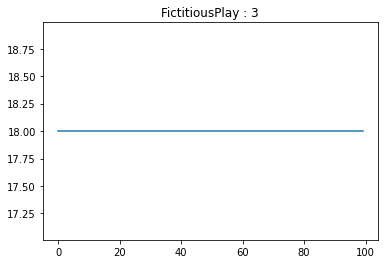

[DEBUG] (Player 0  ) Expected utility  [1.5     1.28125 0.875   1.     ]
[DEBUG] (Player 1  ) Expected utility  [0.984375 1.21875  1.125    1.1875  ]
[DEBUG] (Player 0  ) Expected utility  [1.40277778 1.42361111 0.82638889 0.97916667]
[DEBUG] (Player 1  ) Expected utility  [1.01388889 1.1875     1.10416667 1.18055556]
[DEBUG] (Player 0  ) Expected utility  [1.12222222 2.27777778 0.66111111 0.78333333]
[DEBUG] (Player 1  ) Expected utility  [0.74222222 1.85777778 0.81777778 0.96      ]
[DEBUG] (Player 0  ) Expected utility  [1.24       2.44444444 0.8        0.70222222]
[DEBUG] (Player 1  ) Expected utility  [0.74222222 1.85777778 0.81777778 0.96      ]
[DEBUG] (Player 0  ) Expected utility  [1.03333333 3.05555556 0.66666667 0.58518519]
[DEBUG] (Player 1  ) Expected utility  [0.58024691 2.28703704 0.64506173 0.80864198]
[DEBUG] (Player 0  ) Expected utility  [1.09876543 3.19444444 0.74382716 0.54012346]
[DEBUG] (Player 1  ) Expected utility  [0.58024691 2.28703704 0.64506173 0.80864198]


[DEBUG] (Player 0  ) Expected utility  [0.28408691 6.5073012  0.20179451 0.08018121]
[DEBUG] (Player 1  ) Expected utility  [0.09975369 4.02115588 0.10714286 0.17940711]
[DEBUG] (Player 0  ) Expected utility  [0.28408691 6.5073012  0.20179451 0.08018121]
[DEBUG] (Player 0  ) Expected utility  [0.27471401 6.54344172 0.19529296 0.07708393]
[DEBUG] (Player 0  ) Expected utility  [0.27471401 6.54344172 0.19529296 0.07708393]
[DEBUG] (Player 1  ) Expected utility  [0.0960679  4.03608184 0.10316126 0.17327484]
[DEBUG] (Player 0  ) Expected utility  [0.26419878 6.38945233 0.17890467 0.08076403]
[DEBUG] (Player 1  ) Expected utility  [0.09712644 3.90439486 0.09685598 0.17846518]
[DEBUG] (Player 0  ) Expected utility  [0.26419878 6.38945233 0.17890467 0.08076403]
[DEBUG] (Player 0  ) Expected utility  [0.25604048 6.42087287 0.17346616 0.07789374]
[DEBUG] (Player 1  ) Expected utility  [0.09388889 3.91941176 0.09362745 0.17251634]
[DEBUG] (Player 0  ) Expected utility  [0.25604048 6.42087287 0.1

[DEBUG] (Player 1  ) Expected utility  [0.05511725 4.14910695 0.05163133 0.10009177]
[DEBUG] (Player 0  ) Expected utility  [0.15076869 6.76738967 0.09952024 0.04415282]
[DEBUG] (Player 1  ) Expected utility  [0.0550852  4.14852443 0.0515777  0.10010482]
[DEBUG] (Player 0  ) Expected utility  [0.15076869 6.76738967 0.09952024 0.04415282]
[DEBUG] (Player 1  ) Expected utility  [0.05404586 4.15331672 0.05060454 0.09821605]
[DEBUG] (Player 1  ) Expected utility  [0.05401558 4.15275513 0.05055387 0.09822838]
[DEBUG] (Player 0  ) Expected utility  [0.14809734 6.78050221 0.09778108 0.04324163]
[DEBUG] (Player 1  ) Expected utility  [0.05301529 4.1573693  0.04961769 0.09640934]
[DEBUG] (Player 0  ) Expected utility  [0.14751459 6.81120527 0.09841087 0.04418637]
[DEBUG] (Player 1  ) Expected utility  [0.05570087 4.08755318 0.04773779 0.09855618]
[DEBUG] (Player 0  ) Expected utility  [0.14483251 6.81848998 0.09662158 0.04338298]
[DEBUG] (Player 1  ) Expected utility  [0.05466312 4.09123967 0.0

[DEBUG] (Player 1  ) Expected utility  [0.04045549 4.06847847 0.03217153 0.07152907]
[DEBUG] (Player 0  ) Expected utility  [0.10395234 6.99138237 0.07003123 0.03113076]
[DEBUG] (Player 1  ) Expected utility  [0.03992177 4.07023619 0.03173417 0.07060768]
[DEBUG] (Player 0  ) Expected utility  [0.10397296 6.99284999 0.07004831 0.03111503]
[DEBUG] (Player 1  ) Expected utility  [0.03992177 4.07023619 0.03173417 0.07060768]
[DEBUG] (Player 0  ) Expected utility  [0.10263998 6.99648453 0.06915026 0.03071612]
[DEBUG] (Player 1  ) Expected utility  [0.03940196 4.07194842 0.03130852 0.06970972]
[DEBUG] (Player 0  ) Expected utility  [0.10265981 6.99791526 0.06916669 0.03070099]
[DEBUG] (Player 1  ) Expected utility  [0.03940196 4.07194842 0.03130852 0.06970972]
[DEBUG] (Player 0  ) Expected utility  [0.1013794  7.00285373 0.06830697 0.03029781]
[DEBUG] (Player 1  ) Expected utility  [0.0388955  4.07361689 0.03089411 0.06883431]
[DEBUG] (Player 0  ) Expected utility  [0.10142605 6.99193505 0.0

[DEBUG] (Player 0  ) Expected utility  [0.07864337 7.1135834  0.05232102 0.02309501]
[DEBUG] (Player 1  ) Expected utility  [0.0317484  4.23026966 0.02428495 0.05354867]
[DEBUG] (Player 0  ) Expected utility  [0.07865179 7.11446465 0.05232801 0.02308786]
[DEBUG] (Player 1  ) Expected utility  [0.0317484  4.23026966 0.02428495 0.05354867]
[DEBUG] (Player 0  ) Expected utility  [0.0778807  7.11659984 0.05181499 0.02286151]
[DEBUG] (Player 1  ) Expected utility  [0.03143392 4.23131821 0.02403846 0.05302694]
[DEBUG] (Player 1  ) Expected utility  [0.03143392 4.23131821 0.02403846 0.05302694]
[DEBUG] (Player 0  ) Expected utility  [0.07788887 7.11746407 0.05182178 0.02285456]
[DEBUG] (Player 1  ) Expected utility  [0.03112873 4.23256308 0.02380508 0.05251212]
[DEBUG] (Player 0  ) Expected utility  [0.0771406  7.12040575 0.05132525 0.02262593]
[DEBUG] (Player 1  ) Expected utility  [0.0311256  4.23234627 0.02379692 0.05251528]
[DEBUG] (Player 0  ) Expected utility  [0.0771406  7.12040575 0.0

[DEBUG] (Player 1  ) Expected utility  [0.02522989 4.32175826 0.02019919 0.04265724]
[DEBUG] (Player 0  ) Expected utility  [0.06382189 7.22972378 0.04316527 0.0179076 ]
[DEBUG] (Player 1  ) Expected utility  [0.02522989 4.32175826 0.02019919 0.04265724]
[DEBUG] (Player 0  ) Expected utility  [0.06331537 7.23113474 0.04282269 0.01776547]
[DEBUG] (Player 1  ) Expected utility  [0.02502778 4.32246861 0.02003463 0.04232023]
[DEBUG] (Player 0  ) Expected utility  [0.0633197  7.23170121 0.04282658 0.01776168]
[DEBUG] (Player 1  ) Expected utility  [0.02502778 4.32246861 0.02003463 0.04232023]
[DEBUG] (Player 1  ) Expected utility  [0.02482889 4.32316772 0.01987272 0.0419885 ]
[DEBUG] (Player 0  ) Expected utility  [0.06282112 7.23309005 0.04248936 0.01762183]
[DEBUG] (Player 1  ) Expected utility  [0.02482889 4.32316772 0.01987272 0.0419885 ]
[DEBUG] (Player 0  ) Expected utility  [0.06282535 7.23364771 0.04249315 0.01761813]
[DEBUG] (Player 1  ) Expected utility  [0.02463491 4.32398485 0.0

[DEBUG] (Player 1  ) Expected utility  [0.02182168 4.39388213 0.01691562 0.03579922]
[DEBUG] (Player 0  ) Expected utility  [0.0532347  7.33793318 0.03626109 0.01460183]
[DEBUG] (Player 0  ) Expected utility  [0.0528798  7.33893838 0.03601935 0.01450449]
[DEBUG] (Player 1  ) Expected utility  [0.02194736 4.42331719 0.01707364 0.03567846]
[DEBUG] (Player 0  ) Expected utility  [0.0528798  7.33893838 0.03601935 0.01450449]
[DEBUG] (Player 1  ) Expected utility  [0.0218     4.4238303  0.01695729 0.03544156]
[DEBUG] (Player 1  ) Expected utility  [0.02179897 4.42373871 0.01695479 0.0354425 ]
[DEBUG] (Player 0  ) Expected utility  [0.05253204 7.34034345 0.03578309 0.01440612]
[DEBUG] (Player 1  ) Expected utility  [0.02165461 4.42433659 0.01684251 0.03520779]
[DEBUG] (Player 0  ) Expected utility  [0.05253444 7.34075117 0.03578534 0.01440385]
[DEBUG] (Player 1  ) Expected utility  [0.02165461 4.42433659 0.01684251 0.03520779]
[DEBUG] (Player 1  ) Expected utility  [0.02151115 4.4248362  0.0

[DEBUG] (Player 0  ) Expected utility  [0.04587236 7.31735222 0.03074863 0.01261434]
[DEBUG] (Player 1  ) Expected utility  [0.01865507 4.45007207 0.01473026 0.03059713]
[DEBUG] (Player 0  ) Expected utility  [0.04561027 7.31839661 0.03057332 0.01254038]
[DEBUG] (Player 1  ) Expected utility  [0.01854718 4.45045922 0.01464401 0.03042184]
[DEBUG] (Player 0  ) Expected utility  [0.04558232 7.34822372 0.03076667 0.01239324]
[DEBUG] (Player 0  ) Expected utility  [0.04532185 7.34896038 0.03059086 0.01232243]
[DEBUG] (Player 1  ) Expected utility  [0.01864301 4.47460293 0.01475494 0.03033987]
[DEBUG] (Player 0  ) Expected utility  [0.04532185 7.34896038 0.03059086 0.01232243]
[DEBUG] (Player 0  ) Expected utility  [0.04506584 7.34998966 0.03041845 0.01225096]
[DEBUG] (Player 1  ) Expected utility  [0.01853581 4.47498858 0.01466907 0.03016705]
[DEBUG] (Player 0  ) Expected utility  [0.04506584 7.34998966 0.03041845 0.01225096]
[DEBUG] (Player 1  ) Expected utility  [0.01853515 4.47492636 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01644208 4.44911874 0.01289423 0.02693399]
[DEBUG] (Player 0  ) Expected utility  [0.04014342 7.3718307  0.0272146  0.01093415]
[DEBUG] (Player 1  ) Expected utility  [0.01635858 4.44941458 0.01282802 0.02679836]
[DEBUG] (Player 0  ) Expected utility  [0.04014448 7.37206656 0.02721559 0.01093315]
[DEBUG] (Player 1  ) Expected utility  [0.01635858 4.44941458 0.01282802 0.02679836]
[DEBUG] (Player 0  ) Expected utility  [0.03994379 7.37287001 0.02707979 0.01087722]
[DEBUG] (Player 1  ) Expected utility  [0.01627592 4.44970744 0.01276248 0.02666409]
[DEBUG] (Player 0  ) Expected utility  [0.03992138 7.3983619  0.02722079 0.01076547]
[DEBUG] (Player 1  ) Expected utility  [0.01634763 4.47117348 0.01284801 0.02659989]
[DEBUG] (Player 0  ) Expected utility  [0.03972177 7.3989281  0.02708469 0.01071165]
[DEBUG] (Player 1  ) Expected utility  [0.01626544 4.47146544 0.01278272 0.02646728]
[DEBUG] (Player 0  ) Expected utility  [0.03972279 7.39916066 0.0

[DEBUG] (Player 0  ) Expected utility  [0.03577143 7.35299495 0.02392208 0.00976871]
[DEBUG] (Player 1  ) Expected utility  [0.01451038 4.47854708 0.01147033 0.02381134]
[DEBUG] (Player 0  ) Expected utility  [0.03577217 7.35318076 0.02392275 0.009768  ]
[DEBUG] (Player 1  ) Expected utility  [0.01451038 4.47854708 0.01147033 0.02381134]
[DEBUG] (Player 0  ) Expected utility  [0.03561175 7.35363246 0.02381548 0.0097242 ]
[DEBUG] (Player 1  ) Expected utility  [0.01444499 4.47878394 0.01141814 0.02370482]
[DEBUG] (Player 0  ) Expected utility  [0.03561248 7.35381661 0.02381614 0.0097235 ]
[DEBUG] (Player 1  ) Expected utility  [0.01444499 4.47878394 0.01141814 0.02370482]
[DEBUG] (Player 0  ) Expected utility  [0.03545422 7.35444681 0.02371047 0.00967941]
[DEBUG] (Player 1  ) Expected utility  [0.01438019 4.47901868 0.01136642 0.02359925]
[DEBUG] (Player 0  ) Expected utility  [0.03545422 7.35444681 0.02371047 0.00967941]
[DEBUG] (Player 1  ) Expected utility  [0.01455366 4.50206827 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01305931 4.48234151 0.01043124 0.02154128]
[DEBUG] (Player 0  ) Expected utility  [0.03222169 7.38161357 0.02169584 0.00871237]
[DEBUG] (Player 1  ) Expected utility  [0.01300598 4.48253625 0.01038828 0.02145391]
[DEBUG] (Player 0  ) Expected utility  [0.03222224 7.38176484 0.02169634 0.00871185]
[DEBUG] (Player 1  ) Expected utility  [0.01300598 4.48253625 0.01038828 0.02145391]
[DEBUG] (Player 0  ) Expected utility  [0.03209231 7.3821308  0.02160886 0.00867672]
[DEBUG] (Player 1  ) Expected utility  [0.01295308 4.4827294  0.01034568 0.02136724]
[DEBUG] (Player 0  ) Expected utility  [0.03209285 7.38228085 0.02160936 0.00867621]
[DEBUG] (Player 1  ) Expected utility  [0.01295308 4.4827294  0.01034568 0.02136724]
[DEBUG] (Player 1  ) Expected utility  [0.01290061 4.482921   0.01030342 0.02128126]
[DEBUG] (Player 1  ) Expected utility  [0.01290061 4.482921   0.01030342 0.02128126]
[DEBUG] (Player 0  ) Expected utility  [0.03196502 7.38294038 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01194357 4.4859839  0.00940069 0.01960034]
[DEBUG] (Player 0  ) Expected utility  [0.02943794 7.386337   0.01974232 0.00799956]
[DEBUG] (Player 1  ) Expected utility  [0.0118995  4.48616989 0.009366   0.01952802]
[DEBUG] (Player 0  ) Expected utility  [0.02932972 7.38676848 0.01966984 0.00796965]
[DEBUG] (Player 1  ) Expected utility  [0.01189932 4.48614365 0.00936558 0.01952816]
[DEBUG] (Player 0  ) Expected utility  [0.02932972 7.38676848 0.01966984 0.00796965]
[DEBUG] (Player 0  ) Expected utility  [0.02922229 7.38719681 0.01959789 0.00793997]
[DEBUG] (Player 1  ) Expected utility  [0.01185557 4.48632828 0.00933115 0.01945637]
[DEBUG] (Player 0  ) Expected utility  [0.02922229 7.38719681 0.01959789 0.00793997]
[DEBUG] (Player 1  ) Expected utility  [0.01185539 4.48630223 0.00933073 0.01945651]
[DEBUG] (Player 0  ) Expected utility  [0.02911525 7.38749858 0.01952611 0.00791088]
[DEBUG] (Player 1  ) Expected utility  [0.01181179 4.48645964 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01093959 4.52420878 0.00871421 0.01790043]
[DEBUG] (Player 0  ) Expected utility  [2.69719154e-02 7.41036309e+00 1.80599143e-02 7.24540948e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01104109 4.54136689 0.0087296  0.01789566]
[DEBUG] (Player 0  ) Expected utility  [2.68804852e-02 7.41062206e+00 1.79986943e-02 7.22084877e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01100353 4.54150464 0.00869969 0.01783511]
[DEBUG] (Player 0  ) Expected utility  [2.68807929e-02 7.41072821e+00 1.79989796e-02 7.22054459e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01100353 4.54150464 0.00869969 0.01783511]
[DEBUG] (Player 0  ) Expected utility  [2.67899794e-02 7.41098543e+00 1.79381723e-02 7.19615086e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01096622 4.54164146 0.00866998 0.01777496]
[DEBUG] (Player 0  ) Expected utility  [2.67902840e-02 7.41109086e+00 1.79384548e-02 7.19584975e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01096622 4.54164146 0.008669

[DEBUG] (Player 0  ) Expected utility  [2.50888570e-02 7.37034887e+00 1.65662990e-02 6.84235256e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01025523 4.52648327 0.00807448 0.01674083]
[DEBUG] (Player 0  ) Expected utility  [2.50097124e-02 7.37057172e+00 1.65140394e-02 6.82076786e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01022267 4.52660305 0.00804866 0.01668794]
[DEBUG] (Player 0  ) Expected utility  [2.50099609e-02 7.37066334e+00 1.65142600e-02 6.82052575e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01022267 4.52660305 0.00804866 0.01668794]
[DEBUG] (Player 0  ) Expected utility  [2.49313132e-02 7.37088478e+00 1.64623284e-02 6.79907755e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01019031 4.52672208 0.00802301 0.01663539]
[DEBUG] (Player 0  ) Expected utility  [2.49315595e-02 7.37097583e+00 1.64625470e-02 6.79883773e-03]
[DEBUG] (Player 1  ) Expected utility  [0.01019031 4.52672208 0.00802301 0.01663539]
[DEBUG] (Player 1  ) Expected utility  [0.01015816 4.52684036 0.007997

[DEBUG] (Player 0  ) Expected utility  [2.34686324e-02 7.35241687e+00 1.54140664e-02 6.48064346e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00955131 4.4962677  0.00743064 0.01568423]
[DEBUG] (Player 0  ) Expected utility  [2.34686324e-02 7.35241687e+00 1.54140664e-02 6.48064346e-03]
[DEBUG] (Player 0  ) Expected utility  [2.33996066e-02 7.35269053e+00 1.53687724e-02 6.46133233e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00952305 4.49637023 0.0074085  0.01563804]
[DEBUG] (Player 0  ) Expected utility  [2.33764226e-02 7.34631536e+00 1.52911414e-02 6.45410507e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00953074 4.51163155 0.00743023 0.01560812]
[DEBUG] (Player 0  ) Expected utility  [2.33076684e-02 7.34650827e+00 1.52461674e-02 6.43512241e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00950262 4.51173428 0.00740816 0.01556228]
[DEBUG] (Player 0  ) Expected utility  [2.33078679e-02 7.34658712e+00 1.52463386e-02 6.43492999e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00950262 4.5

[DEBUG] (Player 1  ) Expected utility  [0.0088187  4.49475338 0.00702343 0.01466944]
[DEBUG] (Player 0  ) Expected utility  [2.20994014e-02 7.34983618e+00 1.45373338e-02 6.06379731e-03]
[DEBUG] (Player 1  ) Expected utility  [0.0088187  4.49475338 0.00702343 0.01466944]
[DEBUG] (Player 0  ) Expected utility  [2.20381842e-02 7.35000727e+00 1.44970642e-02 6.04700009e-03]
[DEBUG] (Player 1  ) Expected utility  [0.0087942  4.49484413 0.0070038  0.01462886]
[DEBUG] (Player 0  ) Expected utility  [2.20383548e-02 7.35007654e+00 1.44972123e-02 6.04683988e-03]
[DEBUG] (Player 1  ) Expected utility  [0.0087942  4.49484413 0.0070038  0.01462886]
[DEBUG] (Player 0  ) Expected utility  [2.19774754e-02 7.35024668e+00 1.44571648e-02 6.03013590e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00876983 4.49493438 0.00698427 0.01458851]
[DEBUG] (Player 0  ) Expected utility  [2.19776446e-02 7.35031556e+00 1.44573117e-02 6.02997701e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00876983 4.49493438 0.006984

[DEBUG] (Player 1  ) Expected utility  [0.00817925 4.49002338 0.00668195 0.01377351]
[DEBUG] (Player 0  ) Expected utility  [2.08588577e-02 7.37903991e+00 1.39019062e-02 5.63406063e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00817919 4.49001113 0.00668181 0.01377355]
[DEBUG] (Player 0  ) Expected utility  [2.08588577e-02 7.37903991e+00 1.39019062e-02 5.63406063e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00815783 4.49010392 0.00666436 0.01373759]
[DEBUG] (Player 1  ) Expected utility  [0.00815776 4.49009173 0.00666422 0.01373764]
[DEBUG] (Player 0  ) Expected utility  [2.08048291e-02 7.37931379e+00 1.38659654e-02 5.61911971e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00813652 4.49018404 0.00664686 0.01370186]
[DEBUG] (Player 0  ) Expected utility  [2.08108788e-02 7.37087257e+00 1.38548061e-02 5.66106740e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00814578 4.46838405 0.00659614 0.01375256]
[DEBUG] (Player 0  ) Expected utility  [2.07568246e-02 7.37102332e+00 1.38188196e-02 5

[DEBUG] (Player 1  ) Expected utility  [0.00781143 4.47731868 0.00626585 0.01308557]
[DEBUG] (Player 0  ) Expected utility  [1.97149666e-02 7.39656169e+00 1.31879162e-02 5.34086824e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00779209 4.47738987 0.00625025 0.01305331]
[DEBUG] (Player 0  ) Expected utility  [1.97150905e-02 7.39661700e+00 1.31880278e-02 5.34075363e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00779209 4.47738987 0.00625025 0.01305331]
[DEBUG] (Player 0  ) Expected utility  [1.96665312e-02 7.39675295e+00 1.31555450e-02 5.32759907e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00777284 4.4774607  0.00623474 0.0130212 ]
[DEBUG] (Player 0  ) Expected utility  [1.96666542e-02 7.39680799e+00 1.31556558e-02 5.32748531e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00777284 4.4774607  0.00623474 0.0130212 ]
[DEBUG] (Player 0  ) Expected utility  [1.96183332e-02 7.39694328e+00 1.31233323e-02 5.31439567e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00775369 4.47753118 0.006219

[DEBUG] (Player 1  ) Expected utility  [0.00744555 4.50390886 0.00597668 0.01237862]
[DEBUG] (Player 0  ) Expected utility  [1.86797220e-02 7.41785237e+00 1.25257641e-02 5.02076235e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00742807 4.50397347 0.00596258 0.01234966]
[DEBUG] (Player 0  ) Expected utility  [1.86798267e-02 7.41790238e+00 1.25258599e-02 5.02066368e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00742807 4.50397347 0.00596258 0.01234966]
[DEBUG] (Player 0  ) Expected utility  [1.86361823e-02 7.41802501e+00 1.24965939e-02 5.00893315e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00741066 4.50403778 0.00594855 0.01232084]
[DEBUG] (Player 0  ) Expected utility  [1.86362863e-02 7.41807478e+00 1.24966890e-02 5.00883517e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00741066 4.50403778 0.00594855 0.01232084]
[DEBUG] (Player 0  ) Expected utility  [1.85929483e-02 7.41824638e+00 1.24676536e-02 4.99706226e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00739334 4.5041018  0.005934

[DEBUG] (Player 0  ) Expected utility  [1.77570972e-02 7.40854246e+00 1.18685115e-02 4.82935880e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00710596 4.47757273 0.00559693 0.01181595]
[DEBUG] (Player 0  ) Expected utility  [1.77476547e-02 7.40984326e+00 1.18552638e-02 4.82568755e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00712101 4.48299252 0.00559954 0.01181319]
[DEBUG] (Player 0  ) Expected utility  [1.77082155e-02 7.40995402e+00 1.18289188e-02 4.81496380e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00710515 4.48304996 0.005587   0.01178697]
[DEBUG] (Player 1  ) Expected utility  [0.00710515 4.48304996 0.005587   0.01178697]
[DEBUG] (Player 0  ) Expected utility  [1.77083048e-02 7.40999925e+00 1.18289987e-02 4.81488008e-03]
[DEBUG] (Player 0  ) Expected utility  [1.76691290e-02 7.41015455e+00 1.18028498e-02 4.80412090e-03]
[DEBUG] (Player 0  ) Expected utility  [1.76691290e-02 7.41015455e+00 1.18028498e-02 4.80412090e-03]
[DEBUG] (Player 1  ) Expected utility  [0.0070894  4.4

[DEBUG] (Player 0  ) Expected utility  [1.69392309e-02 7.40978212e+00 1.13261796e-02 4.60309591e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00676733 4.47539771 0.00534789 0.01128514]
[DEBUG] (Player 0  ) Expected utility  [1.69033427e-02 7.40988275e+00 1.13021834e-02 4.59334359e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00675289 4.47544129 0.00533637 0.01126124]
[DEBUG] (Player 0  ) Expected utility  [1.69034210e-02 7.40992392e+00 1.13022535e-02 4.59327090e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00675289 4.47544129 0.00533637 0.01126124]
[DEBUG] (Player 0  ) Expected utility  [1.68676844e-02 7.41002413e+00 1.12783587e-02 4.58355997e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00673855 4.47549339 0.00532499 0.01123741]
[DEBUG] (Player 0  ) Expected utility  [1.68677622e-02 7.41006512e+00 1.12784283e-02 4.58348774e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00673855 4.47549339 0.00532499 0.01123741]
[DEBUG] (Player 1  ) Expected utility  [0.00672427 4.47554528 0.005313

[DEBUG] (Player 0  ) Expected utility  [1.62054592e-02 7.41173007e+00 1.08630150e-02 4.41642172e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00643671 4.45252139 0.00506852 0.01079097]
[DEBUG] (Player 0  ) Expected utility  [1.62054592e-02 7.41173007e+00 1.08630150e-02 4.41642172e-03]
[DEBUG] (Player 0  ) Expected utility  [1.61727234e-02 7.41185936e+00 1.08410865e-02 4.40741868e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00642365 4.45256837 0.00505819 0.01076915]
[DEBUG] (Player 0  ) Expected utility  [1.61885508e-02 7.40516553e+00 1.08538062e-02 4.42832755e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00640409 4.43395622 0.00503637 0.01079081]
[DEBUG] (Player 0  ) Expected utility  [1.61558466e-02 7.40525694e+00 1.08318793e-02 4.41938144e-03]
[DEBUG] (Player 0  ) Expected utility  [1.61559155e-02 7.40529414e+00 1.08319404e-02 4.41931920e-03]
[DEBUG] (Player 1  ) Expected utility  [0.00639112 4.43400265 0.00502613 0.01076904]
[DEBUG] (Player 0  ) Expected utility  [1.61233431e-02

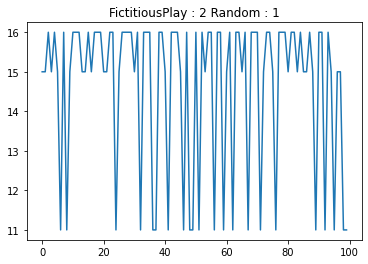

[DEBUG] (Player 0  ) Expected utility  [1.09375  1.078125 1.109375 0.828125]
[DEBUG] (Player 1  ) Expected utility  [1.03125 1.03125 1.09375 1.375  ]
[DEBUG] (Player 0  ) Expected utility  [0.86805556 1.17361111 1.29166667 0.68055556]
[DEBUG] (Player 0  ) Expected utility  [0.69444444 0.93888889 2.06666667 0.54444444]
[DEBUG] (Player 1  ) Expected utility  [1.1875     1.08333333 0.90277778 1.27083333]
[DEBUG] (Player 0  ) Expected utility  [0.69444444 0.93888889 2.06666667 0.54444444]
[DEBUG] (Player 1  ) Expected utility  [0.92444444 0.81333333 0.65777778 2.15111111]
[DEBUG] (Player 0  ) Expected utility  [0.60740741 0.77037037 2.84444444 0.4       ]
[DEBUG] (Player 1  ) Expected utility  [0.90740741 0.77777778 0.61481481 2.22962963]
[DEBUG] (Player 0  ) Expected utility  [0.60740741 0.77037037 2.84444444 0.4       ]
[DEBUG] (Player 1  ) Expected utility  [0.75617284 0.64814815 0.51234568 2.78703704]
[DEBUG] (Player 1  ) Expected utility  [0.74603175 0.62698413 0.48677249 2.85714286]


[DEBUG] (Player 1  ) Expected utility  [0.17061049 0.09342013 0.03527445 6.398443  ]
[DEBUG] (Player 0  ) Expected utility  [0.14057654 0.15079365 7.29337712 0.02317095]
[DEBUG] (Player 1  ) Expected utility  [0.17061049 0.09342013 0.03527445 6.398443  ]
[DEBUG] (Player 0  ) Expected utility  [0.13612694 0.14531141 7.35151093 0.0216491 ]
[DEBUG] (Player 1  ) Expected utility  [0.1646644  0.08983558 0.03362171 6.43683628]
[DEBUG] (Player 0  ) Expected utility  [0.13612694 0.14531141 7.35151093 0.0216491 ]
[DEBUG] (Player 1  ) Expected utility  [0.16597888 0.08851507 0.03077569 6.48590613]
[DEBUG] (Player 0  ) Expected utility  [0.13100068 0.14009466 7.42636917 0.0193712 ]
[DEBUG] (Player 1  ) Expected utility  [0.16039216 0.08522876 0.02934641 6.52235294]
[DEBUG] (Player 0  ) Expected utility  [0.13117647 0.13996732 7.43911765 0.01905229]
[DEBUG] (Player 1  ) Expected utility  [0.16039216 0.08522876 0.02934641 6.52235294]
[DEBUG] (Player 0  ) Expected utility  [0.12694497 0.13545225 7.4

[DEBUG] (Player 1  ) Expected utility  [0.09560918 0.04596112 0.01071169 7.08898944]
[DEBUG] (Player 1  ) Expected utility  [0.09376176 0.0450129  0.01042843 7.10154948]
[DEBUG] (Player 0  ) Expected utility  [7.47660350e-02 7.78421781e-02 8.06579795e+00 6.66611858e-03]
[DEBUG] (Player 1  ) Expected utility  [0.09376176 0.0450129  0.01042843 7.10154948]
[DEBUG] (Player 0  ) Expected utility  [7.47997635e-02 7.78167500e-02 8.07027092e+00 6.60511745e-03]
[DEBUG] (Player 1  ) Expected utility  [0.09199267 0.0441636  0.01023166 7.10975304]
[DEBUG] (Player 1  ) Expected utility  [0.09198437 0.0441028  0.01015866 7.11364754]
[DEBUG] (Player 0  ) Expected utility  [7.34771122e-02 7.63285576e-02 8.08769624e+00 6.36970990e-03]
[DEBUG] (Player 1  ) Expected utility  [0.09028095 0.04328608 0.00997053 7.12155159]
[DEBUG] (Player 0  ) Expected utility  [7.34771122e-02 7.63285576e-02 8.08769624e+00 6.36970990e-03]
[DEBUG] (Player 1  ) Expected utility  [0.09050592 0.04304713 0.00947432 7.13906326]
[

[DEBUG] (Player 0  ) Expected utility  [5.44593094e-02 5.60328007e-02 8.32316860e+00 3.45967960e-03]
[DEBUG] (Player 0  ) Expected utility  [5.37233728e-02 5.52756007e-02 8.32798896e+00 3.41292717e-03]
[DEBUG] (Player 1  ) Expected utility  [6.63238110e-02 3.03930666e-02 5.35506288e-03 7.34978185e+00]
[DEBUG] (Player 0  ) Expected utility  [5.37233728e-02 5.52756007e-02 8.32798896e+00 3.41292717e-03]
[DEBUG] (Player 0  ) Expected utility  [5.29706922e-02 5.45079256e-02 8.34145741e+00 3.25692781e-03]
[DEBUG] (Player 1  ) Expected utility  [6.64140877e-02 3.02956052e-02 5.15482982e-03 7.35974009e+00]
[DEBUG] (Player 0  ) Expected utility  [5.29706922e-02 5.45079256e-02 8.34145741e+00 3.25692781e-03]
[DEBUG] (Player 0  ) Expected utility  [5.22851432e-02 5.37819232e-02 8.34823007e+00 3.19342660e-03]
[DEBUG] (Player 0  ) Expected utility  [5.22851432e-02 5.37819232e-02 8.34823007e+00 3.19342660e-03]
[DEBUG] (Player 0  ) Expected utility  [5.16061154e-02 5.30834566e-02 8.35268563e+00 3.1519

[DEBUG] (Player 0  ) Expected utility  [4.23437003e-02 4.33177138e-02 8.46811521e+00 2.12260289e-03]
[DEBUG] (Player 1  ) Expected utility  [5.24161313e-02 2.33763232e-02 3.33500284e-03 7.48392456e+00]
[DEBUG] (Player 0  ) Expected utility  [4.23257016e-02 4.33019649e-02 8.47370948e+00 2.06684317e-03]
[DEBUG] (Player 1  ) Expected utility  [5.24610066e-02 2.33274346e-02 3.23515828e-03 7.49033225e+00]
[DEBUG] (Player 0  ) Expected utility  [4.18801679e-02 4.28461547e-02 8.47665004e+00 2.04508693e-03]
[DEBUG] (Player 1  ) Expected utility  [5.19074401e-02 2.30705951e-02 3.18755421e-03 7.49427124e+00]
[DEBUG] (Player 0  ) Expected utility  [4.18858950e-02 4.28417135e-02 8.47803464e+00 2.03475195e-03]
[DEBUG] (Player 1  ) Expected utility  [5.19074401e-02 2.30705951e-02 3.18755421e-03 7.49427124e+00]
[DEBUG] (Player 0  ) Expected utility  [4.14495836e-02 4.23954457e-02 8.48091441e+00 2.01355662e-03]
[DEBUG] (Player 1  ) Expected utility  [5.13654339e-02 2.28193392e-02 3.14122124e-03 7.4981

[DEBUG] (Player 0  ) Expected utility  [3.49432754e-02 3.56108222e-02 8.55989495e+00 1.44646396e-03]
[DEBUG] (Player 1  ) Expected utility  [4.33559389e-02 1.89495928e-02 2.21787699e-03 7.57666418e+00]
[DEBUG] (Player 0  ) Expected utility  [3.46294124e-02 3.52921947e-02 8.56578274e+00 1.40248319e-03]
[DEBUG] (Player 1  ) Expected utility  [4.29781894e-02 1.87784150e-02 2.19091039e-03 7.57937062e+00]
[DEBUG] (Player 0  ) Expected utility  [3.46326508e-02 3.52896697e-02 8.56673413e+00 1.39664183e-03]
[DEBUG] (Player 1  ) Expected utility  [4.29781894e-02 1.87784150e-02 2.19091039e-03 7.57937062e+00]
[DEBUG] (Player 0  ) Expected utility  [3.43340935e-02 3.49854485e-02 8.56871228e+00 1.38460182e-03]
[DEBUG] (Player 1  ) Expected utility  [4.26069655e-02 1.86102979e-02 2.16454001e-03 7.58203082e+00]
[DEBUG] (Player 0  ) Expected utility  [3.43372486e-02 3.49829884e-02 8.56964748e+00 1.37891066e-03]
[DEBUG] (Player 1  ) Expected utility  [4.26069655e-02 1.86102979e-02 2.16454001e-03 7.5820

[DEBUG] (Player 0  ) Expected utility  [2.95186736e-02 3.00014715e-02 8.62897026e+00 1.02127253e-03]
[DEBUG] (Player 1  ) Expected utility  [3.66711076e-02 1.58265486e-02 1.59793153e-03 7.63995381e+00]
[DEBUG] (Player 0  ) Expected utility  [2.95206798e-02 2.99999013e-02 8.62966397e+00 1.01765501e-03]
[DEBUG] (Player 1  ) Expected utility  [3.66711076e-02 1.58265486e-02 1.59793153e-03 7.63995381e+00]
[DEBUG] (Player 0  ) Expected utility  [2.93036159e-02 2.97793138e-02 8.63110610e+00 1.01017225e-03]
[DEBUG] (Player 1  ) Expected utility  [3.64010262e-02 1.57062931e-02 1.58152025e-03 7.64189846e+00]
[DEBUG] (Player 1  ) Expected utility  [3.64010262e-02 1.57062931e-02 1.58152025e-03 7.64189846e+00]
[DEBUG] (Player 1  ) Expected utility  [3.61353253e-02 1.55916486e-02 1.56997631e-03 7.64315666e+00]
[DEBUG] (Player 0  ) Expected utility  [2.93055780e-02 2.97777781e-02 8.63178972e+00 1.00663414e-03]
[DEBUG] (Player 1  ) Expected utility  [3.61353253e-02 1.55916486e-02 1.56997631e-03 7.6431

[DEBUG] (Player 1  ) Expected utility  [3.19787433e-02 1.36736497e-02 1.21676189e-03 7.68528171e+00]
[DEBUG] (Player 0  ) Expected utility  [2.57237286e-02 2.60886524e-02 8.67663061e+00 7.74350617e-04]
[DEBUG] (Player 1  ) Expected utility  [3.17737514e-02 1.35859981e-02 1.20896213e-03 7.68625404e+00]
[DEBUG] (Player 0  ) Expected utility  [2.55601350e-02 2.59203954e-02 8.67824979e+00 7.67039229e-04]
[DEBUG] (Player 1  ) Expected utility  [3.17734629e-02 1.35834171e-02 1.20586423e-03 7.68676501e+00]
[DEBUG] (Player 0  ) Expected utility  [2.55601350e-02 2.59203954e-02 8.67824979e+00 7.67039229e-04]
[DEBUG] (Player 1  ) Expected utility  [3.15710842e-02 1.34968985e-02 1.19818357e-03 7.68772501e+00]
[DEBUG] (Player 0  ) Expected utility  [2.53986090e-02 2.57542947e-02 8.67984847e+00 7.59850694e-04]
[DEBUG] (Player 1  ) Expected utility  [3.15708012e-02 1.34943666e-02 1.19514461e-03 7.68822954e+00]
[DEBUG] (Player 0  ) Expected utility  [2.53986090e-02 2.57542947e-02 8.67984847e+00 7.5985

[DEBUG] (Player 1  ) Expected utility  [2.81901618e-02 1.19663716e-02 9.51897265e-04 7.72123739e+00]
[DEBUG] (Player 0  ) Expected utility  [2.26636084e-02 2.29474829e-02 8.71429891e+00 6.03819428e-04]
[DEBUG] (Player 1  ) Expected utility  [2.81899629e-02 1.19645702e-02 9.49735099e-04 7.72164087e+00]
[DEBUG] (Player 0  ) Expected utility  [2.26636084e-02 2.29474829e-02 8.71429891e+00 6.03819428e-04]
[DEBUG] (Player 1  ) Expected utility  [2.80306976e-02 1.18969737e-02 9.44369364e-04 7.72239737e+00]
[DEBUG] (Player 0  ) Expected utility  [2.25364580e-02 2.28171339e-02 8.71555884e+00 5.98799085e-04]
[DEBUG] (Player 1  ) Expected utility  [2.80305020e-02 1.18952027e-02 9.42243706e-04 7.72279632e+00]
[DEBUG] (Player 0  ) Expected utility  [2.25364580e-02 2.28171339e-02 8.71555884e+00 5.98799085e-04]
[DEBUG] (Player 0  ) Expected utility  [2.24107263e-02 2.26882574e-02 8.71680470e+00 5.93853126e-04]
[DEBUG] (Player 0  ) Expected utility  [2.24107263e-02 2.26882574e-02 8.71680470e+00 5.9385

[DEBUG] (Player 0  ) Expected utility  [2.03567557e-02 2.05861931e-02 8.74308391e+00 4.87652758e-04]
[DEBUG] (Player 1  ) Expected utility  [2.53329590e-02 1.06896415e-02 7.67320568e-04 7.74952870e+00]
[DEBUG] (Player 0  ) Expected utility  [2.02534219e-02 2.04816947e-02 8.74377377e+00 4.85177363e-04]
[DEBUG] (Player 1  ) Expected utility  [2.52042246e-02 1.06340924e-02 7.61880986e-04 7.75046352e+00]
[DEBUG] (Player 0  ) Expected utility  [2.02540700e-02 2.04811840e-02 8.74410238e+00 4.84009369e-04]
[DEBUG] (Player 1  ) Expected utility  [2.52042246e-02 1.06340924e-02 7.61880986e-04 7.75046352e+00]
[DEBUG] (Player 0  ) Expected utility  [2.01517767e-02 2.03777437e-02 8.74478530e+00 4.81564877e-04]
[DEBUG] (Player 1  ) Expected utility  [2.50767920e-02 1.05791174e-02 7.56511873e-04 7.75138895e+00]
[DEBUG] (Player 1  ) Expected utility  [2.50767920e-02 1.05791174e-02 7.56511873e-04 7.75138895e+00]
[DEBUG] (Player 0  ) Expected utility  [2.01524150e-02 2.03772408e-02 8.74511062e+00 4.8041

[DEBUG] (Player 0  ) Expected utility  [1.83909974e-02 1.85794052e-02 8.76716849e+00 4.00196084e-04]
[DEBUG] (Player 1  ) Expected utility  [2.30017278e-02 9.65877341e-03 6.31662953e-04 7.77260484e+00]
[DEBUG] (Player 0  ) Expected utility  [1.83066350e-02 1.84941786e-02 8.76773227e+00 3.98360323e-04]
[DEBUG] (Player 0  ) Expected utility  [1.83071181e-02 1.84937974e-02 8.76800360e+00 3.97489810e-04]
[DEBUG] (Player 1  ) Expected utility  [2.28956254e-02 9.61330747e-03 6.27605329e-04 7.77337424e+00]
[DEBUG] (Player 1  ) Expected utility  [2.28955227e-02 9.61236073e-03 6.26469068e-04 7.77363674e+00]
[DEBUG] (Player 1  ) Expected utility  [2.27904974e-02 9.56826734e-03 6.23595356e-04 7.77413663e+00]
[DEBUG] (Player 1  ) Expected utility  [2.27904974e-02 9.56826734e-03 6.23595356e-04 7.77413663e+00]
[DEBUG] (Player 0  ) Expected utility  [1.82244725e-02 1.84086023e-02 8.76909749e+00 3.93965455e-04]
[DEBUG] (Player 1  ) Expected utility  [2.26864312e-02 9.52457662e-03 6.20747889e-04 7.7746

[DEBUG] (Player 0  ) Expected utility  [1.68426262e-02 1.70001008e-02 8.78687637e+00 3.35061754e-04]
[DEBUG] (Player 1  ) Expected utility  [2.09746572e-02 8.77261397e-03 5.27696191e-04 7.79198699e+00]
[DEBUG] (Player 0  ) Expected utility  [1.67718589e-02 1.69286718e-02 8.78734969e+00 3.33653932e-04]
[DEBUG] (Player 1  ) Expected utility  [2.08864496e-02 8.73502244e-03 5.24600684e-04 7.79262960e+00]
[DEBUG] (Player 0  ) Expected utility  [1.67722270e-02 1.69283810e-02 8.78757558e+00 3.32990691e-04]
[DEBUG] (Player 1  ) Expected utility  [2.08864496e-02 8.73502244e-03 5.24600684e-04 7.79262960e+00]
[DEBUG] (Player 1  ) Expected utility  [2.07989807e-02 8.69775158e-03 5.21538401e-04 7.79326687e+00]
[DEBUG] (Player 0  ) Expected utility  [1.67024138e-02 1.68572638e-02 8.78826896e+00 3.30942485e-04]
[DEBUG] (Player 1  ) Expected utility  [2.08018297e-02 8.69458593e-03 5.15156064e-04 7.79434482e+00]
[DEBUG] (Player 1  ) Expected utility  [2.07151554e-02 8.65835848e-03 5.13009580e-04 7.7947

[DEBUG] (Player 0  ) Expected utility  [1.54741786e-02 1.56077584e-02 8.80371769e+00 2.84046343e-04]
[DEBUG] (Player 1  ) Expected utility  [1.92759591e-02 8.03441934e-03 4.46749771e-04 7.80851227e+00]
[DEBUG] (Player 0  ) Expected utility  [1.54744677e-02 1.56075298e-02 8.80391015e+00 2.83525432e-04]
[DEBUG] (Player 1  ) Expected utility  [1.92759591e-02 8.03441934e-03 4.46749771e-04 7.80851227e+00]
[DEBUG] (Player 0  ) Expected utility  [1.54150065e-02 1.55470431e-02 8.80450103e+00 2.81915847e-04]
[DEBUG] (Player 0  ) Expected utility  [1.54141443e-02 1.55462211e-02 8.80528967e+00 2.79117557e-04]
[DEBUG] (Player 1  ) Expected utility  [1.92014737e-02 8.00282998e-03 4.44342657e-04 7.80905560e+00]
[DEBUG] (Player 0  ) Expected utility  [1.53548591e-02 1.54864280e-02 8.80568654e+00 2.78044028e-04]
[DEBUG] (Player 1  ) Expected utility  [1.92036567e-02 7.99977050e-03 4.38637939e-04 7.81016461e+00]
[DEBUG] (Player 1  ) Expected utility  [1.91297965e-02 7.96900215e-03 4.36950870e-04 7.8105

[DEBUG] (Player 1  ) Expected utility  [1.78960568e-02 7.43772585e-03 3.85025004e-04 7.82213519e+00]
[DEBUG] (Player 0  ) Expected utility  [1.43631208e-02 1.44778584e-02 8.81791202e+00 2.44316035e-04]
[DEBUG] (Player 0  ) Expected utility  [1.43118688e-02 1.44257854e-02 8.81842156e+00 2.43028259e-04]
[DEBUG] (Player 1  ) Expected utility  [1.78318647e-02 7.41061218e-03 3.83098734e-04 7.82260392e+00]
[DEBUG] (Player 0  ) Expected utility  [1.43118688e-02 1.44257854e-02 8.81842156e+00 2.43028259e-04]
[DEBUG] (Player 1  ) Expected utility  [1.78336627e-02 7.40861065e-03 3.79068129e-04 7.82340112e+00]
[DEBUG] (Player 0  ) Expected utility  [1.42600676e-02 1.43736072e-02 8.81944544e+00 2.39925214e-04]
[DEBUG] (Player 1  ) Expected utility  [1.77699231e-02 7.38170092e-03 3.77173757e-04 7.82386659e+00]
[DEBUG] (Player 0  ) Expected utility  [1.42602939e-02 1.43734281e-02 8.81960904e+00 2.39517462e-04]
[DEBUG] (Player 1  ) Expected utility  [1.77699231e-02 7.38170092e-03 3.77173757e-04 7.8238

[DEBUG] (Player 0  ) Expected utility  [1.33560790e-02 1.34553649e-02 8.83049148e+00 2.11665159e-04]
[DEBUG] (Player 1  ) Expected utility  [1.66446329e-02 6.89991758e-03 3.33696222e-04 7.83435709e+00]
[DEBUG] (Player 0  ) Expected utility  [1.33557405e-02 1.34550401e-02 8.83085074e+00 2.10562559e-04]
[DEBUG] (Player 1  ) Expected utility  [1.66460960e-02 6.89828767e-03 3.30415473e-04 7.83505336e+00]
[DEBUG] (Player 0  ) Expected utility  [1.33110001e-02 1.34099777e-02 8.83138466e+00 2.09140116e-04]
[DEBUG] (Player 1  ) Expected utility  [1.65905702e-02 6.87492690e-03 3.28874269e-04 7.83545921e+00]
[DEBUG] (Player 0  ) Expected utility  [1.33111842e-02 1.34098319e-02 8.83152730e+00 2.08808480e-04]
[DEBUG] (Player 1  ) Expected utility  [1.65905702e-02 6.87492690e-03 3.28874269e-04 7.83545921e+00]
[DEBUG] (Player 0  ) Expected utility  [1.32669610e-02 1.33652809e-02 8.83182367e+00 2.08114764e-04]
[DEBUG] (Player 1  ) Expected utility  [1.65354135e-02 6.85172378e-03 3.27346218e-04 7.8358

[DEBUG] (Player 0  ) Expected utility  [1.25195007e-02 1.26068210e-02 8.84158051e+00 1.84497905e-04]
[DEBUG] (Player 1  ) Expected utility  [1.56068304e-02 6.45366576e-03 2.90562212e-04 7.84526307e+00]
[DEBUG] (Player 0  ) Expected utility  [1.24803773e-02 1.25674247e-02 8.84184282e+00 1.83921350e-04]
[DEBUG] (Player 1  ) Expected utility  [1.55580271e-02 6.43319589e-03 2.89291570e-04 7.84562006e+00]
[DEBUG] (Player 0  ) Expected utility  [1.24805290e-02 1.25673044e-02 8.84196829e+00 1.83648003e-04]
[DEBUG] (Player 1  ) Expected utility  [1.55580271e-02 6.43319589e-03 2.89291570e-04 7.84562006e+00]
[DEBUG] (Player 1  ) Expected utility  [1.55095281e-02 6.41285544e-03 2.88031098e-04 7.84597483e+00]
[DEBUG] (Player 0  ) Expected utility  [1.24416489e-02 1.25281540e-02 8.84222896e+00 1.83075891e-04]
[DEBUG] (Player 1  ) Expected utility  [1.55095281e-02 6.41285544e-03 2.88031098e-04 7.84597483e+00]
[DEBUG] (Player 0  ) Expected utility  [1.24417992e-02 1.25280348e-02 8.84235365e+00 1.8280

[DEBUG] (Player 1  ) Expected utility  [1.46464855e-02 6.04475135e-03 2.56447654e-04 7.85459896e+00]
[DEBUG] (Player 0  ) Expected utility  [1.17473286e-02 1.18244797e-02 8.85107941e+00 1.63003563e-04]
[DEBUG] (Player 1  ) Expected utility  [1.46464855e-02 6.04475135e-03 2.56447654e-04 7.85459896e+00]
[DEBUG] (Player 0  ) Expected utility  [1.17474551e-02 1.18243794e-02 8.85119063e+00 1.62775610e-04]
[DEBUG] (Player 1  ) Expected utility  [1.46035339e-02 6.02702480e-03 2.55695608e-04 7.85480401e+00]
[DEBUG] (Player 0  ) Expected utility  [1.17131306e-02 1.17896043e-02 8.85153226e+00 1.62072310e-04]
[DEBUG] (Player 1  ) Expected utility  [1.46035076e-02 6.02677496e-03 2.55395760e-04 7.85491356e+00]
[DEBUG] (Player 0  ) Expected utility  [1.17131306e-02 1.17896043e-02 8.85153226e+00 1.62072310e-04]
[DEBUG] (Player 1  ) Expected utility  [1.45608073e-02 6.00915281e-03 2.54648989e-04 7.85511741e+00]
[DEBUG] (Player 1  ) Expected utility  [1.45607812e-02 6.00890515e-03 2.54351766e-04 7.8552

[DEBUG] (Player 1  ) Expected utility  [1.38358516e-02 5.70050705e-03 2.28895333e-04 7.86259081e+00]
[DEBUG] (Player 0  ) Expected utility  [1.10649853e-02 1.11334553e-02 8.85960215e+00 1.44867060e-04]
[DEBUG] (Player 1  ) Expected utility  [1.38358295e-02 5.70029578e-03 2.28641780e-04 7.86268867e+00]
[DEBUG] (Player 0  ) Expected utility  [1.10649853e-02 1.11334553e-02 8.85960215e+00 1.44867060e-04]
[DEBUG] (Player 1  ) Expected utility  [1.37975031e-02 5.68450549e-03 2.28008423e-04 7.86287170e+00]
[DEBUG] (Player 0  ) Expected utility  [1.10345245e-02 1.11026162e-02 8.85990596e+00 1.44276913e-04]
[DEBUG] (Player 1  ) Expected utility  [1.37974810e-02 5.68429596e-03 2.27756969e-04 7.86296901e+00]
[DEBUG] (Player 0  ) Expected utility  [1.10345245e-02 1.11026162e-02 8.85990596e+00 1.44276913e-04]
[DEBUG] (Player 1  ) Expected utility  [1.37593665e-02 5.66859349e-03 2.27127806e-04 7.86315103e+00]
[DEBUG] (Player 0  ) Expected utility  [1.10042310e-02 1.10719475e-02 8.86020810e+00 1.4369

[DEBUG] (Player 0  ) Expected utility  [1.04849096e-02 1.05464073e-02 8.86692881e+00 1.30100411e-04]
[DEBUG] (Player 1  ) Expected utility  [1.30758190e-02 5.37899513e-03 2.04801336e-04 7.87000221e+00]
[DEBUG] (Player 0  ) Expected utility  [1.04849996e-02 1.05463359e-02 8.86701748e+00 1.29938339e-04]
[DEBUG] (Player 1  ) Expected utility  [1.30758190e-02 5.37899513e-03 2.04801336e-04 7.87000221e+00]
[DEBUG] (Player 0  ) Expected utility  [1.04575519e-02 1.05187277e-02 8.86720171e+00 1.29598186e-04]
[DEBUG] (Player 1  ) Expected utility  [1.30415704e-02 5.36473610e-03 2.04051710e-04 7.87025320e+00]
[DEBUG] (Player 0  ) Expected utility  [1.04576412e-02 1.05186568e-02 8.86728992e+00 1.29437384e-04]
[DEBUG] (Player 1  ) Expected utility  [1.30415704e-02 5.36473610e-03 2.04051710e-04 7.87025320e+00]
[DEBUG] (Player 0  ) Expected utility  [1.04303366e-02 1.04911930e-02 8.86747318e+00 1.29099427e-04]
[DEBUG] (Player 1  ) Expected utility  [1.30075008e-02 5.35055244e-03 2.03307110e-04 7.8705

[DEBUG] (Player 0  ) Expected utility  [9.96270158e-03 1.00181018e-02 8.87360880e+00 1.17342628e-04]
[DEBUG] (Player 1  ) Expected utility  [1.23949707e-02 5.09192943e-03 1.84504995e-04 7.87657551e+00]
[DEBUG] (Player 1  ) Expected utility  [1.23949707e-02 5.09192943e-03 1.84504995e-04 7.87657551e+00]
[DEBUG] (Player 0  ) Expected utility  [9.96277839e-03 1.00180408e-02 8.87368849e+00 1.17204280e-04]
[DEBUG] (Player 1  ) Expected utility  [1.23642139e-02 5.07929437e-03 1.84047167e-04 7.87672246e+00]
[DEBUG] (Player 1  ) Expected utility  [1.23641980e-02 5.07914204e-03 1.83864355e-04 7.87680153e+00]
[DEBUG] (Player 0  ) Expected utility  [9.93807160e-03 9.99305979e-03 8.87393417e+00 1.16775409e-04]
[DEBUG] (Player 0  ) Expected utility  [9.93814746e-03 9.99299954e-03 8.87401307e+00 1.16638770e-04]
[DEBUG] (Player 0  ) Expected utility  [9.91348705e-03 9.96820302e-03 8.87417864e+00 1.16349343e-04]
[DEBUG] (Player 0  ) Expected utility  [9.91348705e-03 9.96820302e-03 8.87417864e+00 1.1634

[DEBUG] (Player 1  ) Expected utility  [1.18094312e-02 4.84523310e-03 1.67320870e-04 7.88245400e+00]
[DEBUG] (Player 1  ) Expected utility  [1.18094312e-02 4.84523310e-03 1.67320870e-04 7.88245400e+00]
[DEBUG] (Player 0  ) Expected utility  [9.46748203e-03 9.51764884e-03 8.87972858e+00 1.06241064e-04]
[DEBUG] (Player 1  ) Expected utility  [1.17815130e-02 4.83377864e-03 1.66925312e-04 7.88258743e+00]
[DEBUG] (Player 0  ) Expected utility  [9.46761422e-03 9.51754383e-03 8.87987294e+00 1.06002990e-04]
[DEBUG] (Player 1  ) Expected utility  [1.17815130e-02 4.83377864e-03 1.66925312e-04 7.88258743e+00]
[DEBUG] (Player 0  ) Expected utility  [9.44523215e-03 9.49504373e-03 8.88002325e+00 1.05752392e-04]
[DEBUG] (Player 0  ) Expected utility  [9.44529762e-03 9.49499172e-03 8.88009491e+00 1.05634477e-04]
[DEBUG] (Player 0  ) Expected utility  [9.42302098e-03 9.47259787e-03 8.88024451e+00 1.05385339e-04]
[DEBUG] (Player 1  ) Expected utility  [1.17536992e-02 4.82211721e-03 1.66218380e-04 7.8828

[DEBUG] (Player 0  ) Expected utility  [9.03962868e-03 9.08526998e-03 8.88521167e+00 9.67586308e-05]
[DEBUG] (Player 1  ) Expected utility  [1.12767325e-02 4.62144952e-03 1.52568059e-04 7.88773257e+00]
[DEBUG] (Player 0  ) Expected utility  [9.01922320e-03 9.06476147e-03 8.88534874e+00 9.65402141e-05]
[DEBUG] (Player 1  ) Expected utility  [1.12512652e-02 4.61090316e-03 1.52086619e-04 7.88791946e+00]
[DEBUG] (Player 0  ) Expected utility  [9.01928048e-03 9.06471595e-03 8.88541442e+00 9.64370554e-05]
[DEBUG] (Player 1  ) Expected utility  [1.12512652e-02 4.61090316e-03 1.52086619e-04 7.88791946e+00]
[DEBUG] (Player 0  ) Expected utility  [8.99902368e-03 9.04425472e-03 8.88561625e+00 9.61173920e-05]
[DEBUG] (Player 1  ) Expected utility  [1.12259127e-02 4.60040482e-03 1.51607963e-04 7.88810551e+00]
[DEBUG] (Player 0  ) Expected utility  [8.99885243e-03 9.04408818e-03 8.88588898e+00 9.55554363e-05]
[DEBUG] (Player 1  ) Expected utility  [1.12263629e-02 4.59990177e-03 1.50597537e-04 7.8884

[DEBUG] (Player 1  ) Expected utility  [1.07667137e-02 4.40787397e-03 1.39382042e-04 7.89266886e+00]
[DEBUG] (Player 0  ) Expected utility  [8.64871930e-03 8.69051133e-03 8.89015627e+00 8.85821461e-05]
[DEBUG] (Player 0  ) Expected utility  [8.63013970e-03 8.67166172e-03 8.89040181e+00 8.82104669e-05]
[DEBUG] (Player 0  ) Expected utility  [8.63013970e-03 8.67166172e-03 8.89040181e+00 8.82104669e-05]
[DEBUG] (Player 0  ) Expected utility  [8.61154026e-03 8.65297280e-03 8.89052677e+00 8.80203582e-05]
[DEBUG] (Player 1  ) Expected utility  [1.07434888e-02 4.39817499e-03 1.38842530e-04 7.89289901e+00]
[DEBUG] (Player 0  ) Expected utility  [8.61139022e-03 8.65282670e-03 8.89077674e+00 8.75276349e-05]
[DEBUG] (Player 1  ) Expected utility  [1.07438835e-02 4.39773381e-03 1.37956546e-04 7.89319263e+00]
[DEBUG] (Player 0  ) Expected utility  [8.59287110e-03 8.63421847e-03 8.89090117e+00 8.73394034e-05]
[DEBUG] (Player 1  ) Expected utility  [1.07207681e-02 4.38817754e-03 1.37541321e-04 7.8933

[DEBUG] (Player 1  ) Expected utility  [1.03221560e-02 4.22177912e-03 1.27993622e-04 7.89714202e+00]
[DEBUG] (Player 1  ) Expected utility  [1.03221469e-02 4.22169132e-03 1.27888260e-04 7.89719672e+00]
[DEBUG] (Player 0  ) Expected utility  [8.25604862e-03 8.29414179e-03 8.89503303e+00 8.09049900e-05]
[DEBUG] (Player 1  ) Expected utility  [1.03008202e-02 4.21296882e-03 1.27624028e-04 7.89729870e+00]
[DEBUG] (Player 0  ) Expected utility  [8.25591641e-03 8.29401292e-03 8.89526298e+00 8.04705781e-05]
[DEBUG] (Player 0  ) Expected utility  [8.23889390e-03 8.27691186e-03 8.89537737e+00 8.03046594e-05]
[DEBUG] (Player 1  ) Expected utility  [1.03011681e-02 4.21257977e-03 1.26842862e-04 7.89756885e+00]
[DEBUG] (Player 0  ) Expected utility  [8.23889390e-03 8.27691186e-03 8.89537737e+00 8.03046594e-05]
[DEBUG] (Player 0  ) Expected utility  [8.22198502e-03 8.25984653e-03 8.89554613e+00 8.00609463e-05]
[DEBUG] (Player 0  ) Expected utility  [8.22198502e-03 8.25984653e-03 8.89554613e+00 8.0060

[DEBUG] (Player 1  ) Expected utility  [9.91286338e-03 4.05083934e-03 1.18039593e-04 7.90120663e+00]


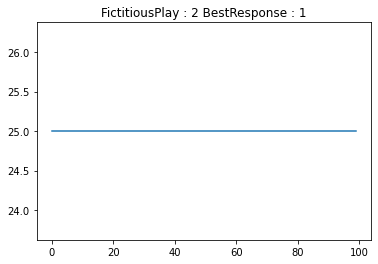

[DEBUG] (Player 0  ) Expected utility  [1.09375 0.90625 1.0625  1.34375]
[DEBUG] (Player 0  ) Expected utility  [1.42361111 0.88888889 1.13194444 1.1875    ]
[DEBUG] (Player 1  ) Expected utility  [1.203125 1.140625 1.09375  1.171875]
[DEBUG] (Player 0  ) Expected utility  [2.27777778 0.71111111 0.90555556 0.95      ]
[DEBUG] (Player 1  ) Expected utility  [1.21666667 1.27222222 0.98888889 0.96111111]
[DEBUG] (Player 0  ) Expected utility  [2.27777778 0.71111111 0.90555556 0.95      ]
[DEBUG] (Player 1  ) Expected utility  [0.97333333 2.03555556 0.79111111 0.76888889]
[DEBUG] (Player 0  ) Expected utility  [2.93333333 0.71481481 0.82222222 0.71851852]
[DEBUG] (Player 1  ) Expected utility  [0.92962963 2.18518519 0.72592593 0.74444444]
[DEBUG] (Player 0  ) Expected utility  [2.93333333 0.71481481 0.82222222 0.71851852]
[DEBUG] (Player 1  ) Expected utility  [0.77469136 2.73148148 0.60493827 0.62037037]
[DEBUG] (Player 0  ) Expected utility  [3.41798942 0.68253968 0.74338624 0.57407407]


[DEBUG] (Player 1  ) Expected utility  [0.18978712 6.49520584 0.2169247  0.1617259 ]
[DEBUG] (Player 1  ) Expected utility  [0.18978712 6.49520584 0.2169247  0.1617259 ]
[DEBUG] (Player 0  ) Expected utility  [2.06830577 0.28008445 0.23218684 0.11096939]
[DEBUG] (Player 0  ) Expected utility  [2.06814548 0.27114683 0.22460946 0.10685145]
[DEBUG] (Player 1  ) Expected utility  [0.18315634 6.53811144 0.20952069 0.15601296]
[DEBUG] (Player 0  ) Expected utility  [1.82310974 0.27376373 0.22515213 0.10740015]
[DEBUG] (Player 1  ) Expected utility  [0.18664755 6.55864867 0.21805274 0.15894943]
[DEBUG] (Player 0  ) Expected utility  [1.8301217  0.26463827 0.21764706 0.10382015]
[DEBUG] (Player 1  ) Expected utility  [0.18035948 6.59911765 0.21088235 0.15352941]
[DEBUG] (Player 0  ) Expected utility  [1.82117647 0.26529412 0.21803922 0.10356209]
[DEBUG] (Player 1  ) Expected utility  [0.18035948 6.59911765 0.21088235 0.15352941]
[DEBUG] (Player 0  ) Expected utility  [1.82770398 0.25673624 0.2

[DEBUG] (Player 1  ) Expected utility  [0.10795392 7.15824978 0.13306076 0.09125027]
[DEBUG] (Player 0  ) Expected utility  [1.21546954 0.16092757 0.1293009  0.05865796]
[DEBUG] (Player 1  ) Expected utility  [0.10795392 7.15824978 0.13306076 0.09125027]
[DEBUG] (Player 0  ) Expected utility  [1.21687362 0.1578912  0.12686126 0.0575512 ]
[DEBUG] (Player 1  ) Expected utility  [0.10590958 7.17172316 0.13057896 0.08950727]
[DEBUG] (Player 0  ) Expected utility  [1.21336181 0.15801063 0.12693327 0.05750696]
[DEBUG] (Player 1  ) Expected utility  [0.10590958 7.17172316 0.13057896 0.08950727]
[DEBUG] (Player 0  ) Expected utility  [1.21132449 0.15519738 0.12465071 0.05640019]
[DEBUG] (Player 1  ) Expected utility  [0.10394122 7.18470889 0.12818803 0.0878296 ]
[DEBUG] (Player 0  ) Expected utility  [1.21132449 0.15519738 0.12465071 0.05640019]
[DEBUG] (Player 1  ) Expected utility  [0.10454884 7.19242171 0.12967613 0.08832043]
[DEBUG] (Player 0  ) Expected utility  [1.12914455 0.1528163  0.1

[DEBUG] (Player 0  ) Expected utility  [0.85797845 0.11270556 0.08959159 0.03990103]
[DEBUG] (Player 1  ) Expected utility  [0.07541244 7.41592228 0.09538816 0.06349057]
[DEBUG] (Player 1  ) Expected utility  [0.07443306 7.41988025 0.09414935 0.06266601]
[DEBUG] (Player 0  ) Expected utility  [0.85797845 0.11270556 0.08959159 0.03990103]
[DEBUG] (Player 1  ) Expected utility  [0.07443306 7.41988025 0.09414935 0.06266601]
[DEBUG] (Player 0  ) Expected utility  [0.85660912 0.11128096 0.08845174 0.03936882]
[DEBUG] (Player 1  ) Expected utility  [0.07347716 7.42627626 0.09295346 0.06185587]
[DEBUG] (Player 0  ) Expected utility  [0.85482872 0.11131906 0.08847482 0.03935516]
[DEBUG] (Player 0  ) Expected utility  [0.85527301 0.10989189 0.08734052 0.03885061]
[DEBUG] (Player 0  ) Expected utility  [0.85527301 0.10989189 0.08734052 0.03885061]
[DEBUG] (Player 1  ) Expected utility  [0.07347716 7.42627626 0.09295346 0.06185587]
[DEBUG] (Player 0  ) Expected utility  [0.85396896 0.10853705 0.0

[DEBUG] (Player 1  ) Expected utility  [0.05794135 7.55284904 0.07425288 0.04867115]
[DEBUG] (Player 0  ) Expected utility  [0.66278751 0.08583206 0.06786177 0.02994002]
[DEBUG] (Player 1  ) Expected utility  [0.05794078 7.55434596 0.07425838 0.04866813]
[DEBUG] (Player 1  ) Expected utility  [0.05736711 7.55665923 0.07352315 0.04818626]
[DEBUG] (Player 0  ) Expected utility  [0.66278751 0.08583206 0.06786177 0.02994002]
[DEBUG] (Player 1  ) Expected utility  [0.05736711 7.55665923 0.07352315 0.04818626]
[DEBUG] (Player 0  ) Expected utility  [0.66187391 0.08500777 0.06720689 0.02964044]
[DEBUG] (Player 0  ) Expected utility  [0.6607832  0.08502462 0.06721712 0.0296345 ]
[DEBUG] (Player 0  ) Expected utility  [0.66097761 0.08419914 0.06656453 0.02934678]
[DEBUG] (Player 0  ) Expected utility  [0.66097761 0.08419914 0.06656453 0.02934678]
[DEBUG] (Player 1  ) Expected utility  [0.05680415 7.56039559 0.07280761 0.04771094]
[DEBUG] (Player 1  ) Expected utility  [0.0568031  7.5632478  0.0

[DEBUG] (Player 1  ) Expected utility  [0.0470415  7.63777789 0.06076116 0.03945795]
[DEBUG] (Player 0  ) Expected utility  [0.53967992 0.06986147 0.05505526 0.02415154]
[DEBUG] (Player 1  ) Expected utility  [0.04666493 7.64027932 0.06027808 0.03914071]
[DEBUG] (Player 0  ) Expected utility  [0.53893358 0.06987064 0.05506084 0.02414834]
[DEBUG] (Player 1  ) Expected utility  [0.04666493 7.64027932 0.06027808 0.03914071]
[DEBUG] (Player 1  ) Expected utility  [0.04629434 7.64274142 0.05980262 0.03882854]
[DEBUG] (Player 0  ) Expected utility  [0.53903876 0.06931611 0.05462385 0.02395669]
[DEBUG] (Player 1  ) Expected utility  [0.04629434 7.64274142 0.05980262 0.03882854]
[DEBUG] (Player 0  ) Expected utility  [0.53830412 0.06932506 0.05462929 0.02395357]
[DEBUG] (Player 1  ) Expected utility  [0.04592982 7.6442092  0.05933173 0.0385228 ]
[DEBUG] (Player 0  ) Expected utility  [0.5376843  0.06878794 0.05420445 0.02376191]
[DEBUG] (Player 1  ) Expected utility  [0.0459296  7.64516512 0.0

[DEBUG] (Player 0  ) Expected utility  [0.46696004 0.05888029 0.04631208 0.02023187]
[DEBUG] (Player 1  ) Expected utility  [0.03929535 7.69614586 0.0509893  0.03292826]
[DEBUG] (Player 0  ) Expected utility  [0.4545747  0.0589034  0.04631767 0.02023748]
[DEBUG] (Player 1  ) Expected utility  [0.03932694 7.69736533 0.05106679 0.03295306]
[DEBUG] (Player 0  ) Expected utility  [0.45463697 0.05851071 0.04600889 0.02010256]
[DEBUG] (Player 1  ) Expected utility  [0.03906465 7.69910909 0.05072814 0.03273247]
[DEBUG] (Player 0  ) Expected utility  [0.45410909 0.05851602 0.04601212 0.02010072]
[DEBUG] (Player 1  ) Expected utility  [0.03906465 7.69910909 0.05072814 0.03273247]
[DEBUG] (Player 0  ) Expected utility  [0.45417047 0.05812849 0.04570741 0.0199676 ]
[DEBUG] (Player 1  ) Expected utility  [0.03880583 7.70082994 0.05039395 0.03251481]
[DEBUG] (Player 0  ) Expected utility  [0.4536495  0.0581337  0.04571057 0.0199658 ]
[DEBUG] (Player 1  ) Expected utility  [0.03880583 7.70082994 0.0

[DEBUG] (Player 1  ) Expected utility  [0.03396256 7.73790884 0.04424398 0.02843838]
[DEBUG] (Player 0  ) Expected utility  [0.40221052 0.05089593 0.039967   0.01741343]
[DEBUG] (Player 1  ) Expected utility  [0.03396256 7.73790884 0.04424398 0.02843838]
[DEBUG] (Player 0  ) Expected utility  [0.40185466 0.05060683 0.03973938 0.01731218]
[DEBUG] (Player 1  ) Expected utility  [0.03376731 7.73920791 0.04399088 0.02827436]
[DEBUG] (Player 0  ) Expected utility  [0.39268063 0.05062143 0.03974293 0.01731574]
[DEBUG] (Player 1  ) Expected utility  [0.03378729 7.74011552 0.0440399  0.02829001]
[DEBUG] (Player 0  ) Expected utility  [0.39272    0.05033217 0.03951583 0.01721679]
[DEBUG] (Player 1  ) Expected utility  [0.03359416 7.74140016 0.0437894  0.02812778]
[DEBUG] (Player 0  ) Expected utility  [0.39232708 0.05033551 0.03951787 0.01721564]
[DEBUG] (Player 1  ) Expected utility  [0.03359416 7.74140016 0.0437894  0.02812778]
[DEBUG] (Player 0  ) Expected utility  [0.39236596 0.05004952 0.0

[DEBUG] (Player 0  ) Expected utility  [0.35323465 0.04481722 0.03515089 0.01528423]
[DEBUG] (Player 1  ) Expected utility  [0.02990331 7.76957969 0.03907087 0.02502515]
[DEBUG] (Player 0  ) Expected utility  [0.35326223 0.04459087 0.03497336 0.01520704]
[DEBUG] (Player 1  ) Expected utility  [0.02975225 7.77058502 0.03887435 0.02489837]
[DEBUG] (Player 0  ) Expected utility  [0.35295278 0.04459318 0.03497477 0.01520625]
[DEBUG] (Player 1  ) Expected utility  [0.02975225 7.77058502 0.03887435 0.02489837]
[DEBUG] (Player 0  ) Expected utility  [0.3526737  0.04437137 0.0348004  0.01512905]
[DEBUG] (Player 0  ) Expected utility  [0.34560674 0.04438118 0.0348028  0.01513145]
[DEBUG] (Player 1  ) Expected utility  [0.0296027  7.77158031 0.0386798  0.02477286]
[DEBUG] (Player 0  ) Expected utility  [0.34563319 0.04415928 0.03462878 0.01505579]
[DEBUG] (Player 1  ) Expected utility  [0.0296161  7.77267268 0.03871354 0.02478298]
[DEBUG] (Player 0  ) Expected utility  [0.34563319 0.04415928 0.0

[DEBUG] (Player 1  ) Expected utility  [0.02671028 7.79473986 0.03497934 0.02234272]
[DEBUG] (Player 1  ) Expected utility  [0.02671028 7.79473986 0.03497934 0.02234272]
[DEBUG] (Player 0  ) Expected utility  [0.31491285 0.03985464 0.03122925 0.01355764]
[DEBUG] (Player 0  ) Expected utility  [0.31468408 0.03967755 0.03109021 0.01349629]
[DEBUG] (Player 1  ) Expected utility  [0.02658996 7.79522304 0.03482177 0.02224208]
[DEBUG] (Player 0  ) Expected utility  [0.31468408 0.03967755 0.03109021 0.01349629]
[DEBUG] (Player 1  ) Expected utility  [0.02658994 7.79553804 0.03482235 0.0222418 ]
[DEBUG] (Player 1  ) Expected utility  [0.02647068 7.79632912 0.03466676 0.02214179]
[DEBUG] (Player 1  ) Expected utility  [0.02647068 7.79632912 0.03466676 0.02214179]
[DEBUG] (Player 0  ) Expected utility  [0.31421361 0.03950363 0.03095337 0.01343494]
[DEBUG] (Player 1  ) Expected utility  [0.02635251 7.79680373 0.034512   0.02204294]
[DEBUG] (Player 1  ) Expected utility  [0.02636197 7.79736228 0.0

[DEBUG] (Player 0  ) Expected utility  [0.28407588 0.0360275  0.0282092  0.01223104]
[DEBUG] (Player 1  ) Expected utility  [0.0241331  7.81468865 0.03166181 0.02017967]
[DEBUG] (Player 0  ) Expected utility  [0.28409007 0.03588164 0.028095   0.01218152]
[DEBUG] (Player 1  ) Expected utility  [0.02403498 7.81533976 0.03153353 0.02009744]
[DEBUG] (Player 0  ) Expected utility  [0.28388674 0.03588284 0.02809573 0.01218111]
[DEBUG] (Player 1  ) Expected utility  [0.02403498 7.81533976 0.03153353 0.02009744]
[DEBUG] (Player 0  ) Expected utility  [0.28390081 0.03573815 0.02798244 0.01213199]
[DEBUG] (Player 1  ) Expected utility  [0.02393766 7.81598564 0.03140628 0.02001587]
[DEBUG] (Player 0  ) Expected utility  [0.28369912 0.03573934 0.02798316 0.01213159]
[DEBUG] (Player 1  ) Expected utility  [0.02393766 7.81598564 0.03140628 0.02001587]
[DEBUG] (Player 1  ) Expected utility  [0.02384112 7.81662633 0.03128006 0.01993497]
[DEBUG] (Player 1  ) Expected utility  [0.02384112 7.81662633 0.0

[DEBUG] (Player 1  ) Expected utility  [0.0219278  7.83143057 0.02881124 0.01833018]
[DEBUG] (Player 0  ) Expected utility  [0.25857078 0.03287165 0.02572227 0.0111406 ]
[DEBUG] (Player 1  ) Expected utility  [0.0219278  7.83143057 0.02881124 0.01833018]
[DEBUG] (Player 0  ) Expected utility  [0.25858151 0.03275035 0.02562735 0.01109949]
[DEBUG] (Player 1  ) Expected utility  [0.02184687 7.83196939 0.02870525 0.01826239]
[DEBUG] (Player 0  ) Expected utility  [0.2584131  0.03275125 0.0256279  0.01109918]
[DEBUG] (Player 1  ) Expected utility  [0.02184687 7.83196939 0.02870525 0.01826239]
[DEBUG] (Player 0  ) Expected utility  [0.25842374 0.03263084 0.02553368 0.01105838]
[DEBUG] (Player 1  ) Expected utility  [0.02176654 7.83250428 0.02860004 0.0181951 ]
[DEBUG] (Player 0  ) Expected utility  [0.25825657 0.03263173 0.02553422 0.01105807]
[DEBUG] (Player 1  ) Expected utility  [0.02176654 7.83250428 0.02860004 0.0181951 ]
[DEBUG] (Player 0  ) Expected utility  [0.25826712 0.0325122  0.0

[DEBUG] (Player 0  ) Expected utility  [0.24070422 0.03022007 0.02363701 0.0102282 ]
[DEBUG] (Player 1  ) Expected utility  [0.02016018 7.84512294 0.02652145 0.01684835]
[DEBUG] (Player 0  ) Expected utility  [0.23741925 0.0301207  0.02355764 0.01019429]
[DEBUG] (Player 1  ) Expected utility  [0.02009183 7.84557807 0.0264318  0.01679112]
[DEBUG] (Player 0  ) Expected utility  [0.23727653 0.03012139 0.02355806 0.01019405]
[DEBUG] (Player 1  ) Expected utility  [0.02009183 7.84557807 0.0264318  0.01679112]
[DEBUG] (Player 0  ) Expected utility  [0.23728477 0.03001963 0.02347848 0.01015961]
[DEBUG] (Player 1  ) Expected utility  [0.02002395 7.84603013 0.02634276 0.01673428]
[DEBUG] (Player 0  ) Expected utility  [0.23714301 0.03002033 0.0234789  0.01015937]
[DEBUG] (Player 1  ) Expected utility  [0.02002395 7.84603013 0.02634276 0.01673428]
[DEBUG] (Player 0  ) Expected utility  [0.23715118 0.02991925 0.02339984 0.01012517]
[DEBUG] (Player 1  ) Expected utility  [0.01995652 7.84647916 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01865288 7.85647705 0.02456037 0.01558554]
[DEBUG] (Player 0  ) Expected utility  [0.222142   0.02787997 0.02179697 0.00942481]
[DEBUG] (Player 1  ) Expected utility  [0.0185944  7.85686654 0.02448358 0.01553659]
[DEBUG] (Player 0  ) Expected utility  [0.222142   0.02787997 0.02179697 0.00942481]
[DEBUG] (Player 1  ) Expected utility  [0.01859574 7.85698001 0.02448686 0.01553763]
[DEBUG] (Player 0  ) Expected utility  [0.21934337 0.02779525 0.02172945 0.00939595]
[DEBUG] (Player 1  ) Expected utility  [0.01853959 7.85753469 0.02441536 0.01549051]
[DEBUG] (Player 0  ) Expected utility  [0.21922164 0.0277958  0.02172978 0.00939577]
[DEBUG] (Player 1  ) Expected utility  [0.01853959 7.85753469 0.02441536 0.01549051]
[DEBUG] (Player 0  ) Expected utility  [0.21922811 0.02770921 0.02166209 0.0093665 ]
[DEBUG] (Player 1  ) Expected utility  [0.01848183 7.85791938 0.0243395  0.01544216]
[DEBUG] (Player 0  ) Expected utility  [0.21910714 0.02770975 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01730772 7.86686185 0.02281019 0.01445883]
[DEBUG] (Player 0  ) Expected utility  [0.20644377 0.02595076 0.02028114 0.00876422]
[DEBUG] (Player 1  ) Expected utility  [0.01730772 7.86686185 0.02281019 0.01445883]
[DEBUG] (Player 0  ) Expected utility  [0.20633755 0.02595121 0.02028141 0.00876407]
[DEBUG] (Player 0  ) Expected utility  [0.20623725 0.02587621 0.02022272 0.00873845]
[DEBUG] (Player 1  ) Expected utility  [0.0172574  7.86719701 0.02274404 0.01441672]
[DEBUG] (Player 0  ) Expected utility  [0.20623725 0.02587621 0.02022272 0.00873845]
[DEBUG] (Player 1  ) Expected utility  [0.01726004 7.86743955 0.02275053 0.01441878]
[DEBUG] (Player 0  ) Expected utility  [0.20382445 0.02580313 0.02016458 0.00871359]
[DEBUG] (Player 1  ) Expected utility  [0.01721001 7.86777279 0.02268474 0.01437691]
[DEBUG] (Player 0  ) Expected utility  [0.2037194  0.02580357 0.02016484 0.00871344]
[DEBUG] (Player 1  ) Expected utility  [0.01721001 7.86777279 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01618751 7.87555223 0.02135068 0.01352084]
[DEBUG] (Player 0  ) Expected utility  [0.19263343 0.02427197 0.01896289 0.0081899 ]
[DEBUG] (Player 1  ) Expected utility  [0.01618751 7.87555223 0.02135068 0.01352084]
[DEBUG] (Player 0  ) Expected utility  [0.19263775 0.02420602 0.01891136 0.00816764]
[DEBUG] (Player 1  ) Expected utility  [0.01614352 7.87584526 0.0212928  0.01348404]
[DEBUG] (Player 0  ) Expected utility  [0.19254522 0.02420638 0.01891158 0.00816752]
[DEBUG] (Player 1  ) Expected utility  [0.01614352 7.87584526 0.0212928  0.01348404]
[DEBUG] (Player 0  ) Expected utility  [0.19245748 0.02414114 0.01886054 0.00814527]
[DEBUG] (Player 1  ) Expected utility  [0.01609976 7.87613671 0.02123522 0.01344744]
[DEBUG] (Player 0  ) Expected utility  [0.19245748 0.02414114 0.01886054 0.00814527]
[DEBUG] (Player 1  ) Expected utility  [0.01610191 7.87634814 0.02124048 0.0134491 ]
[DEBUG] (Player 0  ) Expected utility  [0.1903559  0.02407745 0.0

[DEBUG] (Player 0  ) Expected utility  [0.1806369  0.0227968  0.01780533 0.00768633]
[DEBUG] (Player 1  ) Expected utility  [0.01520344 7.88317758 0.02006655 0.0126971 ]
[DEBUG] (Player 0  ) Expected utility  [0.18064046 0.02273865 0.01775991 0.00766672]
[DEBUG] (Player 1  ) Expected utility  [0.01516465 7.88343595 0.02001547 0.01266465]
[DEBUG] (Player 1  ) Expected utility  [0.01516465 7.88343595 0.02001547 0.01266465]
[DEBUG] (Player 1  ) Expected utility  [0.01512607 7.88359065 0.01996454 0.01263243]
[DEBUG] (Player 0  ) Expected utility  [0.18055872 0.02273895 0.01776009 0.00766662]
[DEBUG] (Player 1  ) Expected utility  [0.01512607 7.88359065 0.01996454 0.01263243]
[DEBUG] (Player 0  ) Expected utility  [0.18048095 0.02268138 0.01771508 0.00764701]
[DEBUG] (Player 0  ) Expected utility  [0.18040004 0.02268168 0.01771526 0.00764691]
[DEBUG] (Player 0  ) Expected utility  [0.18040356 0.02262411 0.0176703  0.00762751]
[DEBUG] (Player 1  ) Expected utility  [0.01508767 7.88394878 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01433213 7.88992237 0.01892801 0.01196793]
[DEBUG] (Player 0  ) Expected utility  [0.17005039 0.02143897 0.01674062 0.00722369]
[DEBUG] (Player 1  ) Expected utility  [0.01429767 7.8901519  0.0188826  0.01193912]
[DEBUG] (Player 0  ) Expected utility  [0.16997766 0.02143922 0.01674077 0.00722361]
[DEBUG] (Player 1  ) Expected utility  [0.01429767 7.8901519  0.0188826  0.01193912]
[DEBUG] (Player 0  ) Expected utility  [0.16998062 0.02138781 0.01670062 0.00720628]
[DEBUG] (Player 1  ) Expected utility  [0.01426339 7.89038032 0.01883741 0.01191045]
[DEBUG] (Player 0  ) Expected utility  [0.16990824 0.02138806 0.01670078 0.0072062 ]
[DEBUG] (Player 1  ) Expected utility  [0.01426339 7.89038032 0.01883741 0.01191045]
[DEBUG] (Player 0  ) Expected utility  [0.16991119 0.02133689 0.01666082 0.00718896]
[DEBUG] (Player 1  ) Expected utility  [0.01422926 7.89060766 0.01879243 0.01188191]
[DEBUG] (Player 0  ) Expected utility  [0.16983915 0.02133714 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01355525 7.89593083 0.01791163 0.01131794]
[DEBUG] (Player 0  ) Expected utility  [0.16063359 0.02027981 0.01583197 0.00682906]
[DEBUG] (Player 1  ) Expected utility  [0.01352444 7.89613607 0.01787101 0.01129218]
[DEBUG] (Player 0  ) Expected utility  [0.16056846 0.02028002 0.0158321  0.00682899]
[DEBUG] (Player 1  ) Expected utility  [0.01352444 7.89613607 0.01787101 0.01129218]
[DEBUG] (Player 0  ) Expected utility  [0.16057096 0.02023403 0.0157962  0.0068135 ]
[DEBUG] (Player 1  ) Expected utility  [0.01349377 7.89634039 0.01783056 0.01126654]
[DEBUG] (Player 0  ) Expected utility  [0.16050613 0.02023424 0.01579633 0.00681343]
[DEBUG] (Player 1  ) Expected utility  [0.01349377 7.89634039 0.01783056 0.01126654]
[DEBUG] (Player 0  ) Expected utility  [0.16050861 0.02018846 0.01576059 0.00679802]
[DEBUG] (Player 1  ) Expected utility  [0.01346324 7.89654379 0.0177903  0.01124102]
[DEBUG] (Player 0  ) Expected utility  [0.16044407 0.02018867 0.0

[DEBUG] (Player 0  ) Expected utility  [0.15348616 0.01923893 0.0150168  0.00647506]
[DEBUG] (Player 1  ) Expected utility  [0.01282944 7.90136706 0.01695956 0.0107109 ]
[DEBUG] (Player 0  ) Expected utility  [0.15214661 0.01923972 0.01501699 0.00647525]
[DEBUG] (Player 1  ) Expected utility  [0.01283052 7.90150191 0.01696222 0.01071174]
[DEBUG] (Player 0  ) Expected utility  [0.15214874 0.01919834 0.0149847  0.00646133]
[DEBUG] (Player 1  ) Expected utility  [0.01280293 7.90168574 0.01692581 0.01068867]
[DEBUG] (Player 0  ) Expected utility  [0.15209033 0.01919852 0.01498481 0.00646127]
[DEBUG] (Player 1  ) Expected utility  [0.01280293 7.90168574 0.01692581 0.01068867]
[DEBUG] (Player 0  ) Expected utility  [0.15209245 0.01915732 0.01495265 0.0064474 ]
[DEBUG] (Player 1  ) Expected utility  [0.01277545 7.90186879 0.01688955 0.0106657 ]
[DEBUG] (Player 0  ) Expected utility  [0.15203429 0.0191575  0.01495276 0.00644734]
[DEBUG] (Player 1  ) Expected utility  [0.01277545 7.90186879 0.0

[DEBUG] (Player 1  ) Expected utility  [0.0122034  7.90621892 0.01613906 0.01018731]
[DEBUG] (Player 0  ) Expected utility  [0.14577186 0.01830025 0.01428153 0.00615619]
[DEBUG] (Player 1  ) Expected utility  [0.0122034  7.90621892 0.01613906 0.01018731]
[DEBUG] (Player 0  ) Expected utility  [0.14572082 0.01826298 0.01425242 0.00614355]
[DEBUG] (Player 1  ) Expected utility  [0.01217844 7.9063852  0.01610611 0.01016645]
[DEBUG] (Player 0  ) Expected utility  [0.14451334 0.01826365 0.01425259 0.00614371]
[DEBUG] (Player 1  ) Expected utility  [0.01217937 7.90650682 0.01610838 0.01016717]
[DEBUG] (Player 0  ) Expected utility  [0.14451516 0.01822638 0.0142235  0.00613118]
[DEBUG] (Player 1  ) Expected utility  [0.01215451 7.90667243 0.01607556 0.0101464 ]
[DEBUG] (Player 0  ) Expected utility  [0.14446248 0.01822653 0.01422359 0.00613112]
[DEBUG] (Player 1  ) Expected utility  [0.01215451 7.90667243 0.01607556 0.0101464 ]
[DEBUG] (Player 0  ) Expected utility  [0.14446429 0.01818941 0.0

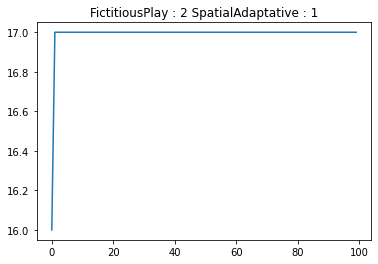

[DEBUG] (Player 2  ) Expected utility  [1.61728395 1.12345679 1.58333333 1.74074074]
[DEBUG] (Player 2  ) Expected utility  [1.61728395 1.12345679 1.58333333 1.74074074]
[DEBUG] (Player 2  ) Expected utility  [1.29382716 0.89876543 1.26666667 2.78518519]
[DEBUG] (Player 2  ) Expected utility  [1.29382716 0.89876543 1.26666667 2.78518519]
[DEBUG] (Player 2  ) Expected utility  [1.0781893  0.74897119 1.05555556 3.48148148]
[DEBUG] (Player 2  ) Expected utility  [1.0781893  0.74897119 1.05555556 3.48148148]
[DEBUG] (Player 2  ) Expected utility  [0.92416226 0.64197531 0.9047619  3.97883598]
[DEBUG] (Player 2  ) Expected utility  [0.92416226 0.64197531 0.9047619  3.97883598]
[DEBUG] (Player 2  ) Expected utility  [0.80864198 0.5617284  0.79166667 4.35185185]
[DEBUG] (Player 2  ) Expected utility  [0.80864198 0.5617284  0.79166667 4.35185185]
[DEBUG] (Player 2  ) Expected utility  [0.70965608 0.5244709  0.61243386 4.25793651]
[DEBUG] (Player 2  ) Expected utility  [0.71485261 0.52891156 0.6

[DEBUG] (Player 2  ) Expected utility  [0.09005355 0.07958083 0.07345415 4.83821357]
[DEBUG] (Player 2  ) Expected utility  [0.08835443 0.0780793  0.07206822 4.84380257]
[DEBUG] (Player 2  ) Expected utility  [0.08835443 0.0780793  0.07206822 4.84380257]
[DEBUG] (Player 2  ) Expected utility  [0.08371053 0.07665664 0.06843537 4.69807051]
[DEBUG] (Player 2  ) Expected utility  [0.0828838  0.07637758 0.06850947 4.67121517]
[DEBUG] (Player 2  ) Expected utility  [0.08137682 0.0749889  0.06726385 4.67621112]
[DEBUG] (Player 2  ) Expected utility  [0.08137682 0.0749889  0.06726385 4.67621112]
[DEBUG] (Player 2  ) Expected utility  [0.07992367 0.07364981 0.06606271 4.68102865]
[DEBUG] (Player 2  ) Expected utility  [0.07992367 0.07364981 0.06606271 4.68102865]
[DEBUG] (Player 2  ) Expected utility  [0.0785215  0.07235771 0.06490371 4.68567713]
[DEBUG] (Player 2  ) Expected utility  [0.0785215  0.07235771 0.06490371 4.68567713]
[DEBUG] (Player 2  ) Expected utility  [0.07716768 0.07111016 0.0

[DEBUG] (Player 2  ) Expected utility  [0.03218096 0.04024749 0.03024306 3.76079808]
[DEBUG] (Player 2  ) Expected utility  [0.03218096 0.04024749 0.03024306 3.76079808]
[DEBUG] (Player 2  ) Expected utility  [0.03186546 0.0398529  0.02994656 3.76192678]
[DEBUG] (Player 2  ) Expected utility  [0.03186546 0.0398529  0.02994656 3.76192678]
[DEBUG] (Player 2  ) Expected utility  [0.03155609 0.03946598 0.02965581 3.76303355]
[DEBUG] (Player 2  ) Expected utility  [0.03155609 0.03946598 0.02965581 3.76303355]
[DEBUG] (Player 2  ) Expected utility  [0.03067785 0.03911649 0.0289635  3.7097001 ]
[DEBUG] (Player 2  ) Expected utility  [0.03041378 0.03905476 0.02895541 3.69195402]
[DEBUG] (Player 2  ) Expected utility  [0.03012413 0.03868281 0.02867964 3.69299842]
[DEBUG] (Player 2  ) Expected utility  [0.03012413 0.03868281 0.02867964 3.69299842]
[DEBUG] (Player 2  ) Expected utility  [0.02983994 0.03831788 0.02840908 3.69402312]
[DEBUG] (Player 2  ) Expected utility  [0.02983994 0.03831788 0.0

[DEBUG] (Player 2  ) Expected utility  [0.0174478  0.02712948 0.01837686 3.25872715]
[DEBUG] (Player 2  ) Expected utility  [0.01733148 0.02694861 0.01825434 3.25917355]
[DEBUG] (Player 2  ) Expected utility  [0.01733148 0.02694861 0.01825434 3.25917355]
[DEBUG] (Player 2  ) Expected utility  [0.0172167  0.02677015 0.01813345 3.25961404]
[DEBUG] (Player 2  ) Expected utility  [0.0172167  0.02677015 0.01813345 3.25961404]
[DEBUG] (Player 2  ) Expected utility  [0.01710343 0.02659403 0.01801415 3.26004873]
[DEBUG] (Player 2  ) Expected utility  [0.01710343 0.02659403 0.01801415 3.26004873]
[DEBUG] (Player 2  ) Expected utility  [0.01699165 0.02642021 0.01789641 3.26047774]
[DEBUG] (Player 2  ) Expected utility  [0.01699165 0.02642021 0.01789641 3.26047774]
[DEBUG] (Player 2  ) Expected utility  [0.01664501 0.02624116 0.01766752 3.23095387]
[DEBUG] (Player 2  ) Expected utility  [0.01658758 0.02623936 0.01764017 3.22367935]
[DEBUG] (Player 2  ) Expected utility  [0.01648056 0.02607007 0.0

[DEBUG] (Player 2  ) Expected utility  [0.01145007 0.02036437 0.0130338  3.00115049]
[DEBUG] (Player 2  ) Expected utility  [0.01145007 0.02036437 0.0130338  3.00115049]
[DEBUG] (Player 2  ) Expected utility  [0.01124845 0.02025784 0.01290067 2.9778255 ]
[DEBUG] (Player 2  ) Expected utility  [0.01124845 0.02025784 0.01290067 2.9778255 ]
[DEBUG] (Player 2  ) Expected utility  [0.01119221 0.02015655 0.01283617 2.97805339]
[DEBUG] (Player 2  ) Expected utility  [0.01119221 0.02015655 0.01283617 2.97805339]
[DEBUG] (Player 2  ) Expected utility  [0.01113653 0.02005627 0.01277231 2.97827902]
[DEBUG] (Player 2  ) Expected utility  [0.01113653 0.02005627 0.01277231 2.97827902]
[DEBUG] (Player 2  ) Expected utility  [0.0110814  0.01995698 0.01270908 2.97850241]
[DEBUG] (Player 2  ) Expected utility  [0.0110814  0.01995698 0.01270908 2.97850241]
[DEBUG] (Player 2  ) Expected utility  [0.01102681 0.01985867 0.01264647 2.97872361]
[DEBUG] (Player 2  ) Expected utility  [0.01102681 0.01985867 0.0

[DEBUG] (Player 2  ) Expected utility  [0.00824665 0.01636329 0.01003773 2.81403545]
[DEBUG] (Player 2  ) Expected utility  [0.00821327 0.01629705 0.0099971  2.81417611]
[DEBUG] (Player 2  ) Expected utility  [0.00821327 0.01629705 0.0099971  2.81417611]
[DEBUG] (Player 2  ) Expected utility  [0.00818015 0.01623133 0.00995679 2.81431562]
[DEBUG] (Player 2  ) Expected utility  [0.00818015 0.01623133 0.00995679 2.81431562]
[DEBUG] (Player 2  ) Expected utility  [0.00809481 0.01616864 0.00988318 2.80281776]
[DEBUG] (Player 2  ) Expected utility  [0.00807091 0.01616404 0.0098813  2.79883948]
[DEBUG] (Player 2  ) Expected utility  [0.00803863 0.01609939 0.00984178 2.79897601]
[DEBUG] (Player 2  ) Expected utility  [0.00803863 0.01609939 0.00984178 2.79897601]
[DEBUG] (Player 2  ) Expected utility  [0.0080066  0.01603525 0.00980257 2.79911145]
[DEBUG] (Player 2  ) Expected utility  [0.0080066  0.01603525 0.00980257 2.79911145]
[DEBUG] (Player 2  ) Expected utility  [0.00797483 0.01597161 0.0

[DEBUG] (Player 2  ) Expected utility  [0.00632382 0.01363034 0.00811419 2.68576543]
[DEBUG] (Player 2  ) Expected utility  [0.00632382 0.01363034 0.00811419 2.68576543]
[DEBUG] (Player 2  ) Expected utility  [0.00630246 0.01358429 0.00808678 2.68585865]
[DEBUG] (Player 2  ) Expected utility  [0.00630246 0.01358429 0.00808678 2.68585865]
[DEBUG] (Player 2  ) Expected utility  [0.00628124 0.01353855 0.00805955 2.68595125]
[DEBUG] (Player 2  ) Expected utility  [0.00628124 0.01353855 0.00805955 2.68595125]
[DEBUG] (Player 2  ) Expected utility  [0.00626016 0.01349312 0.00803251 2.68604322]
[DEBUG] (Player 2  ) Expected utility  [0.00626016 0.01349312 0.00803251 2.68604322]
[DEBUG] (Player 2  ) Expected utility  [0.00621239 0.01344881 0.00798967 2.67912826]
[DEBUG] (Player 2  ) Expected utility  [0.006194   0.01344679 0.00798476 2.67503926]
[DEBUG] (Player 2  ) Expected utility  [0.00617335 0.01340197 0.00795815 2.67512963]
[DEBUG] (Player 2  ) Expected utility  [0.00617335 0.01340197 0.0

[DEBUG] (Player 2  ) Expected utility  [0.0051234  0.0117146  0.00683329 2.60078433]
[DEBUG] (Player 2  ) Expected utility  [0.00509031 0.01168008 0.00680505 2.59571392]
[DEBUG] (Player 2  ) Expected utility  [0.00507834 0.01167977 0.00679955 2.59233626]
[DEBUG] (Player 2  ) Expected utility  [0.00506362 0.01164591 0.00677984 2.59240236]
[DEBUG] (Player 2  ) Expected utility  [0.00506362 0.01164591 0.00677984 2.59240236]
[DEBUG] (Player 2  ) Expected utility  [0.00504898 0.01161226 0.00676025 2.59246808]
[DEBUG] (Player 2  ) Expected utility  [0.00504898 0.01161226 0.00676025 2.59246808]
[DEBUG] (Player 2  ) Expected utility  [0.00503443 0.01157879 0.00674076 2.59253343]
[DEBUG] (Player 2  ) Expected utility  [0.00503443 0.01157879 0.00674076 2.59253343]
[DEBUG] (Player 2  ) Expected utility  [0.00501997 0.01154552 0.00672139 2.5925984 ]
[DEBUG] (Player 2  ) Expected utility  [0.00501997 0.01154552 0.00672139 2.5925984 ]
[DEBUG] (Player 2  ) Expected utility  [0.00498539 0.0115124  0.0

[DEBUG] (Player 2  ) Expected utility  [0.00424724 0.01024423 0.00587088 2.52780112]
[DEBUG] (Player 2  ) Expected utility  [0.00424724 0.01024423 0.00587088 2.52780112]
[DEBUG] (Player 2  ) Expected utility  [0.00423643 0.01021816 0.00585594 2.52785072]
[DEBUG] (Player 2  ) Expected utility  [0.00423643 0.01021816 0.00585594 2.52785072]
[DEBUG] (Player 2  ) Expected utility  [0.00420533 0.01019171 0.00583176 2.52132352]
[DEBUG] (Player 2  ) Expected utility  [0.00420533 0.01019171 0.00583176 2.52132352]
[DEBUG] (Player 2  ) Expected utility  [0.00419468 0.01016591 0.00581699 2.5213725 ]
[DEBUG] (Player 2  ) Expected utility  [0.00419468 0.01016591 0.00581699 2.5213725 ]
[DEBUG] (Player 2  ) Expected utility  [0.00418409 0.01014024 0.0058023  2.52142122]
[DEBUG] (Player 2  ) Expected utility  [0.00418409 0.01014024 0.0058023  2.52142122]
[DEBUG] (Player 2  ) Expected utility  [0.00417355 0.01011469 0.00578769 2.52146971]
[DEBUG] (Player 2  ) Expected utility  [0.00417355 0.01011469 0.0

[DEBUG] (Player 2  ) Expected utility  [0.0036195  0.00912253 0.00515516 2.47057101]
[DEBUG] (Player 2  ) Expected utility  [0.00361129 0.00910185 0.00514347 2.47060947]
[DEBUG] (Player 2  ) Expected utility  [0.00361129 0.00910185 0.00514347 2.47060947]
[DEBUG] (Player 2  ) Expected utility  [0.00360312 0.00908125 0.00513184 2.47064775]
[DEBUG] (Player 2  ) Expected utility  [0.00360312 0.00908125 0.00513184 2.47064775]
[DEBUG] (Player 2  ) Expected utility  [0.00359499 0.00906075 0.00512025 2.47068586]
[DEBUG] (Player 2  ) Expected utility  [0.00359499 0.00906075 0.00512025 2.47068586]
[DEBUG] (Player 2  ) Expected utility  [0.00357253 0.00903999 0.00510215 2.46549242]
[DEBUG] (Player 2  ) Expected utility  [0.00357253 0.00903999 0.00510215 2.46549242]
[DEBUG] (Player 2  ) Expected utility  [0.0035645  0.00901967 0.00509069 2.46553011]
[DEBUG] (Player 2  ) Expected utility  [0.0035645  0.00901967 0.00509069 2.46553011]
[DEBUG] (Player 2  ) Expected utility  [0.00355651 0.00899945 0.0

[DEBUG] (Player 2  ) Expected utility  [0.00313788 0.00820546 0.00458427 2.4245589 ]
[DEBUG] (Player 2  ) Expected utility  [0.00313788 0.00820546 0.00458427 2.4245589 ]
[DEBUG] (Player 2  ) Expected utility  [0.00313148 0.00818871 0.00457492 2.42458945]
[DEBUG] (Player 2  ) Expected utility  [0.00313148 0.00818871 0.00457492 2.42458945]
[DEBUG] (Player 2  ) Expected utility  [0.0031251  0.00817204 0.0045656  2.42461987]
[DEBUG] (Player 2  ) Expected utility  [0.0031251  0.00817204 0.0045656  2.42461987]
[DEBUG] (Player 2  ) Expected utility  [0.00311875 0.00815543 0.00455632 2.42465016]
[DEBUG] (Player 2  ) Expected utility  [0.00311875 0.00815543 0.00455632 2.42465016]
[DEBUG] (Player 2  ) Expected utility  [0.00311242 0.00813888 0.00454708 2.42468033]
[DEBUG] (Player 2  ) Expected utility  [0.00311242 0.00813888 0.00454708 2.42468033]
[DEBUG] (Player 2  ) Expected utility  [0.0030978  0.00812254 0.00453328 2.4211812 ]
[DEBUG] (Player 2  ) Expected utility  [0.00309561 0.00812215 0.0

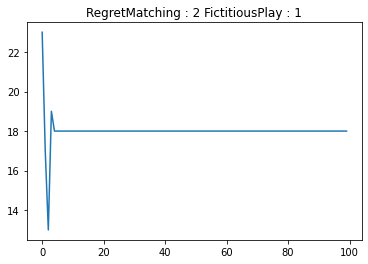

[DEBUG] (Player 0  ) Expected utility  [1.125   0.78125 1.1875  1.03125]
[DEBUG] (Player 0  ) Expected utility  [1.01388889 0.70138889 1.27083333 1.02777778]
[DEBUG] (Player 0  ) Expected utility  [0.72839506 0.55308642 1.99012346 0.68888889]
[DEBUG] (Player 0  ) Expected utility  [0.72839506 0.55308642 1.99012346 0.68888889]
[DEBUG] (Player 0  ) Expected utility  [0.60699588 0.46090535 2.48765432 0.57407407]
[DEBUG] (Player 0  ) Expected utility  [0.60699588 0.46090535 2.48765432 0.57407407]
[DEBUG] (Player 0  ) Expected utility  [0.52028219 0.39506173 2.84303351 0.49206349]
[DEBUG] (Player 0  ) Expected utility  [0.52028219 0.39506173 2.84303351 0.49206349]
[DEBUG] (Player 0  ) Expected utility  [0.45524691 0.34567901 3.1095679  0.43055556]
[DEBUG] (Player 0  ) Expected utility  [0.45524691 0.34567901 3.1095679  0.43055556]
[DEBUG] (Player 0  ) Expected utility  [0.40466392 0.30727023 3.31687243 0.38271605]
[DEBUG] (Player 0  ) Expected utility  [0.48185941 0.35827664 3.23469388 0.48

[DEBUG] (Player 0  ) Expected utility  [0.08361691 0.05647225 4.4381529  0.08314208]
[DEBUG] (Player 0  ) Expected utility  [0.08203924 0.05540673 4.44327976 0.08157336]
[DEBUG] (Player 0  ) Expected utility  [0.08203924 0.05540673 4.44327976 0.08157336]
[DEBUG] (Player 0  ) Expected utility  [0.08051999 0.05438068 4.44821674 0.08006274]
[DEBUG] (Player 0  ) Expected utility  [0.07968123 0.0545767  4.50544224 0.07831934]
[DEBUG] (Player 0  ) Expected utility  [0.07823248 0.05358439 4.5102609  0.07689535]
[DEBUG] (Player 0  ) Expected utility  [0.07823248 0.05358439 4.5102609  0.07689535]
[DEBUG] (Player 0  ) Expected utility  [0.07683547 0.05262753 4.51490746 0.07552222]
[DEBUG] (Player 0  ) Expected utility  [0.07683547 0.05262753 4.51490746 0.07552222]
[DEBUG] (Player 0  ) Expected utility  [0.07548748 0.05170424 4.51939098 0.07419727]
[DEBUG] (Player 0  ) Expected utility  [0.07548748 0.05170424 4.51939098 0.07419727]
[DEBUG] (Player 0  ) Expected utility  [0.07418598 0.05081279 4.5

[DEBUG] (Player 0  ) Expected utility  [0.04136428 0.0284864  4.50251553 0.04060449]
[DEBUG] (Player 0  ) Expected utility  [0.04136428 0.0284864  4.50251553 0.04060449]
[DEBUG] (Player 0  ) Expected utility  [0.04095875 0.02820712 4.50386682 0.04020641]
[DEBUG] (Player 0  ) Expected utility  [0.04095875 0.02820712 4.50386682 0.04020641]
[DEBUG] (Player 0  ) Expected utility  [0.04056109 0.02793327 4.50519188 0.03981606]
[DEBUG] (Player 0  ) Expected utility  [0.04056109 0.02793327 4.50519188 0.03981606]
[DEBUG] (Player 0  ) Expected utility  [0.04017108 0.02766468 4.50649145 0.03943321]
[DEBUG] (Player 0  ) Expected utility  [0.04011091 0.02774792 4.48393362 0.03922633]
[DEBUG] (Player 0  ) Expected utility  [0.0397289  0.02748366 4.48520206 0.03885275]
[DEBUG] (Player 0  ) Expected utility  [0.0397289  0.02748366 4.48520206 0.03885275]
[DEBUG] (Player 0  ) Expected utility  [0.0393541  0.02722438 4.48644657 0.03848621]
[DEBUG] (Player 0  ) Expected utility  [0.0393541  0.02722438 4.4

[DEBUG] (Player 0  ) Expected utility  [0.02931954 0.02012093 4.60503033 0.02853226]
[DEBUG] (Player 0  ) Expected utility  [0.02912408 0.01998679 4.60566116 0.02834205]
[DEBUG] (Player 0  ) Expected utility  [0.02912408 0.01998679 4.60566116 0.02834205]
[DEBUG] (Player 0  ) Expected utility  [0.0289312  0.01985443 4.60628363 0.02815435]
[DEBUG] (Player 0  ) Expected utility  [0.0289312  0.01985443 4.60628363 0.02815435]
[DEBUG] (Player 0  ) Expected utility  [0.02874087 0.0197238  4.60689791 0.02796913]
[DEBUG] (Player 0  ) Expected utility  [0.02874087 0.0197238  4.60689791 0.02796913]
[DEBUG] (Player 0  ) Expected utility  [0.02855302 0.01959489 4.60750416 0.02778632]
[DEBUG] (Player 0  ) Expected utility  [0.02855302 0.01959489 4.60750416 0.02778632]
[DEBUG] (Player 0  ) Expected utility  [0.02836761 0.01946765 4.60810254 0.02760589]
[DEBUG] (Player 0  ) Expected utility  [0.02847372 0.0195003  4.59204721 0.02763176]
[DEBUG] (Player 0  ) Expected utility  [0.02829002 0.01937449 4.5

[DEBUG] (Player 0  ) Expected utility  [0.02221108 0.01513749 4.64727322 0.02086839]
[DEBUG] (Player 0  ) Expected utility  [0.02221108 0.01513749 4.64727322 0.02086839]
[DEBUG] (Player 0  ) Expected utility  [0.02209946 0.01506142 4.6476325  0.02076352]
[DEBUG] (Player 0  ) Expected utility  [0.02206953 0.0150474  4.6642717  0.0206761 ]
[DEBUG] (Player 0  ) Expected utility  [0.02193591 0.0149964  4.65493921 0.0205105 ]
[DEBUG] (Player 0  ) Expected utility  [0.02193591 0.0149964  4.65493921 0.0205105 ]
[DEBUG] (Player 0  ) Expected utility  [0.02182678 0.01492179 4.65529188 0.02040846]
[DEBUG] (Player 0  ) Expected utility  [0.02182678 0.01492179 4.65529188 0.02040846]
[DEBUG] (Player 0  ) Expected utility  [0.02171873 0.01484792 4.65564106 0.02030743]
[DEBUG] (Player 0  ) Expected utility  [0.02171873 0.01484792 4.65564106 0.02030743]
[DEBUG] (Player 0  ) Expected utility  [0.02161174 0.01477477 4.6559868  0.02020739]
[DEBUG] (Player 0  ) Expected utility  [0.02161174 0.01477477 4.6

[DEBUG] (Player 0  ) Expected utility  [0.01810868 0.01240676 4.69945371 0.0169716 ]
[DEBUG] (Player 0  ) Expected utility  [0.01803536 0.01235653 4.6996886  0.01690289]
[DEBUG] (Player 0  ) Expected utility  [0.01803536 0.01235653 4.6996886  0.01690289]
[DEBUG] (Player 0  ) Expected utility  [0.01796264 0.01230671 4.69992159 0.01683473]
[DEBUG] (Player 0  ) Expected utility  [0.01796264 0.01230671 4.69992159 0.01683473]
[DEBUG] (Player 0  ) Expected utility  [0.0178905  0.01225728 4.70015272 0.01676712]
[DEBUG] (Player 0  ) Expected utility  [0.01785106 0.01225361 4.67822346 0.0168433 ]
[DEBUG] (Player 0  ) Expected utility  [0.01777965 0.0122046  4.67845167 0.01677593]
[DEBUG] (Player 0  ) Expected utility  [0.01777965 0.0122046  4.67845167 0.01677593]
[DEBUG] (Player 0  ) Expected utility  [0.01770882 0.01215598 4.67867806 0.0167091 ]
[DEBUG] (Player 0  ) Expected utility  [0.01770882 0.01215598 4.67867806 0.0167091 ]
[DEBUG] (Player 0  ) Expected utility  [0.01763854 0.01210774 4.6

[DEBUG] (Player 0  ) Expected utility  [0.01492567 0.01022728 4.67584502 0.01394873]
[DEBUG] (Player 0  ) Expected utility  [0.01492567 0.01022728 4.67584502 0.01394873]
[DEBUG] (Player 0  ) Expected utility  [0.01487524 0.01019273 4.67600731 0.01390161]
[DEBUG] (Player 0  ) Expected utility  [0.01487524 0.01019273 4.67600731 0.01390161]
[DEBUG] (Player 0  ) Expected utility  [0.01482516 0.01015841 4.67616852 0.0138548 ]
[DEBUG] (Player 0  ) Expected utility  [0.01482516 0.01015841 4.67616852 0.0138548 ]
[DEBUG] (Player 0  ) Expected utility  [0.01477541 0.01012432 4.67632864 0.01380831]
[DEBUG] (Player 0  ) Expected utility  [0.01477541 0.01012432 4.67632864 0.01380831]
[DEBUG] (Player 0  ) Expected utility  [0.01472599 0.01009046 4.67648769 0.01376213]
[DEBUG] (Player 0  ) Expected utility  [0.01466551 0.01000134 4.67489682 0.01377706]
[DEBUG] (Player 0  ) Expected utility  [0.01461662 0.00996801 4.67505475 0.01373114]
[DEBUG] (Player 0  ) Expected utility  [0.01461662 0.00996801 4.6

[DEBUG] (Player 0  ) Expected utility  [0.01295397 0.00885976 4.69702075 0.01214602]
[DEBUG] (Player 0  ) Expected utility  [0.01291632 0.008834   4.69714123 0.01211072]
[DEBUG] (Player 0  ) Expected utility  [0.01292673 0.00888229 4.69833937 0.01219765]
[DEBUG] (Player 0  ) Expected utility  [0.01288926 0.00885655 4.69845918 0.0121623 ]
[DEBUG] (Player 0  ) Expected utility  [0.01288926 0.00885655 4.69845918 0.0121623 ]
[DEBUG] (Player 0  ) Expected utility  [0.01285201 0.00883095 4.69857829 0.01212714]
[DEBUG] (Player 0  ) Expected utility  [0.01285201 0.00883095 4.69857829 0.01212714]
[DEBUG] (Player 0  ) Expected utility  [0.01281497 0.0088055  4.69869672 0.0120922 ]
[DEBUG] (Player 0  ) Expected utility  [0.01281497 0.0088055  4.69869672 0.0120922 ]
[DEBUG] (Player 0  ) Expected utility  [0.01277814 0.0087802  4.69881447 0.01205745]
[DEBUG] (Player 0  ) Expected utility  [0.01277814 0.0087802  4.69881447 0.01205745]
[DEBUG] (Player 0  ) Expected utility  [0.01274153 0.00875504 4.6

[DEBUG] (Player 0  ) Expected utility  [0.01132469 0.00781935 4.69216914 0.01053909]
[DEBUG] (Player 0  ) Expected utility  [0.01132469 0.00781935 4.69216914 0.01053909]
[DEBUG] (Player 0  ) Expected utility  [0.01129588 0.00779945 4.69226122 0.01051227]
[DEBUG] (Player 0  ) Expected utility  [0.01129588 0.00779945 4.69226122 0.01051227]
[DEBUG] (Player 0  ) Expected utility  [0.01126721 0.00777966 4.69235283 0.01048559]
[DEBUG] (Player 0  ) Expected utility  [0.01130326 0.00784882 4.69368101 0.01050351]
[DEBUG] (Player 0  ) Expected utility  [0.01127464 0.00782895 4.69377218 0.01047692]
[DEBUG] (Player 0  ) Expected utility  [0.01127464 0.00782895 4.69377218 0.01047692]
[DEBUG] (Player 0  ) Expected utility  [0.01124617 0.00780918 4.69386289 0.01045047]
[DEBUG] (Player 0  ) Expected utility  [0.01124617 0.00780918 4.69386289 0.01045047]
[DEBUG] (Player 0  ) Expected utility  [0.01121784 0.00778951 4.69395315 0.01042414]
[DEBUG] (Player 0  ) Expected utility  [0.01121784 0.00778951 4.6

[DEBUG] (Player 0  ) Expected utility  [0.01018961 0.007134   4.720309   0.00943807]
[DEBUG] (Player 0  ) Expected utility  [0.0101665  0.00711782 4.72038248 0.00941667]
[DEBUG] (Player 0  ) Expected utility  [0.0101665  0.00711782 4.72038248 0.00941667]
[DEBUG] (Player 0  ) Expected utility  [0.0101435  0.00710172 4.72045562 0.00939537]
[DEBUG] (Player 0  ) Expected utility  [0.0101435  0.00710172 4.72045562 0.00939537]
[DEBUG] (Player 0  ) Expected utility  [0.0101206  0.00708569 4.72052844 0.00937416]
[DEBUG] (Player 0  ) Expected utility  [0.0101206  0.00708569 4.72052844 0.00937416]
[DEBUG] (Player 0  ) Expected utility  [0.01009781 0.00706973 4.72060093 0.00935305]
[DEBUG] (Player 0  ) Expected utility  [0.01012405 0.00709783 4.73265741 0.00935701]
[DEBUG] (Player 0  ) Expected utility  [0.0101013  0.00708188 4.73272976 0.00933598]
[DEBUG] (Player 0  ) Expected utility  [0.0101013  0.00708188 4.73272976 0.00933598]
[DEBUG] (Player 0  ) Expected utility  [0.01007865 0.007066   4.7

[DEBUG] (Player 0  ) Expected utility  [0.00921258 0.0064768  4.73337048 0.00848088]
[DEBUG] (Player 0  ) Expected utility  [0.00922451 0.00648654 4.73928749 0.00850032]
[DEBUG] (Player 0  ) Expected utility  [0.00920568 0.0064733  4.73934719 0.00848297]
[DEBUG] (Player 0  ) Expected utility  [0.00920568 0.0064733  4.73934719 0.00848297]
[DEBUG] (Player 0  ) Expected utility  [0.00918694 0.00646012 4.73940665 0.0084657 ]
[DEBUG] (Player 0  ) Expected utility  [0.00918694 0.00646012 4.73940665 0.0084657 ]
[DEBUG] (Player 0  ) Expected utility  [0.00916826 0.00644699 4.73946587 0.00844849]
[DEBUG] (Player 0  ) Expected utility  [0.00916826 0.00644699 4.73946587 0.00844849]
[DEBUG] (Player 0  ) Expected utility  [0.00914967 0.00643391 4.73952485 0.00843135]
[DEBUG] (Player 0  ) Expected utility  [0.00914967 0.00643391 4.73952485 0.00843135]
[DEBUG] (Player 0  ) Expected utility  [0.00913114 0.00642089 4.73958359 0.00841429]
[DEBUG] (Player 0  ) Expected utility  [0.00911249 0.00640504 4.7

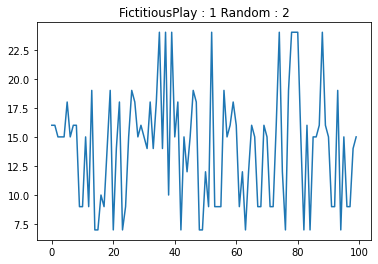

[DEBUG] (Player 0  ) Expected utility  [1.171875 1.1875   0.96875  0.796875]
[DEBUG] (Player 0  ) Expected utility  [1.125      1.22916667 0.79861111 0.82638889]
[DEBUG] (Player 0  ) Expected utility  [1.01728395 2.5037037  0.54320988 0.44197531]
[DEBUG] (Player 0  ) Expected utility  [1.01728395 2.5037037  0.54320988 0.44197531]
[DEBUG] (Player 0  ) Expected utility  [0.84773663 3.12962963 0.4526749  0.36831276]
[DEBUG] (Player 0  ) Expected utility  [0.84773663 3.12962963 0.4526749  0.36831276]
[DEBUG] (Player 0  ) Expected utility  [0.72663139 3.57671958 0.38800705 0.31569665]
[DEBUG] (Player 0  ) Expected utility  [0.72663139 3.57671958 0.38800705 0.31569665]
[DEBUG] (Player 0  ) Expected utility  [0.63580247 3.91203704 0.33950617 0.27623457]
[DEBUG] (Player 0  ) Expected utility  [0.63580247 3.91203704 0.33950617 0.27623457]
[DEBUG] (Player 0  ) Expected utility  [0.56515775 4.17283951 0.30178326 0.24554184]
[DEBUG] (Player 0  ) Expected utility  [0.59435626 4.20634921 0.31569665 

[DEBUG] (Player 0  ) Expected utility  [0.07603936 5.50875145 0.09456447 0.07199008]
[DEBUG] (Player 0  ) Expected utility  [0.07460465 5.51511505 0.09278024 0.07063178]
[DEBUG] (Player 0  ) Expected utility  [0.07460465 5.51511505 0.09278024 0.07063178]
[DEBUG] (Player 0  ) Expected utility  [0.07322309 5.52124295 0.09106208 0.06932378]
[DEBUG] (Player 0  ) Expected utility  [0.07413259 5.33566344 0.09226808 0.07121198]
[DEBUG] (Player 0  ) Expected utility  [0.07278473 5.34137003 0.09059048 0.06991721]
[DEBUG] (Player 0  ) Expected utility  [0.07278473 5.34137003 0.09059048 0.06991721]
[DEBUG] (Player 0  ) Expected utility  [0.071485   5.34687282 0.08897279 0.06866869]
[DEBUG] (Player 0  ) Expected utility  [0.071485   5.34687282 0.08897279 0.06866869]
[DEBUG] (Player 0  ) Expected utility  [0.07023088 5.35218252 0.08741186 0.06746398]
[DEBUG] (Player 0  ) Expected utility  [0.07023088 5.35218252 0.08741186 0.06746398]
[DEBUG] (Player 0  ) Expected utility  [0.06902    5.35730914 0.0

[DEBUG] (Player 0  ) Expected utility  [0.0374436  5.94232618 0.04716901 0.03864368]
[DEBUG] (Player 0  ) Expected utility  [0.03707287 5.94414582 0.04670199 0.03826107]
[DEBUG] (Player 0  ) Expected utility  [0.03707287 5.94414582 0.04670199 0.03826107]
[DEBUG] (Player 0  ) Expected utility  [0.03670941 5.94592978 0.04624413 0.03788596]
[DEBUG] (Player 0  ) Expected utility  [0.03670941 5.94592978 0.04624413 0.03788596]
[DEBUG] (Player 0  ) Expected utility  [0.03635301 5.94767909 0.04579515 0.03751813]
[DEBUG] (Player 0  ) Expected utility  [0.03635301 5.94767909 0.04579515 0.03751813]
[DEBUG] (Player 0  ) Expected utility  [0.03600346 5.94939477 0.04535482 0.03715738]
[DEBUG] (Player 0  ) Expected utility  [0.03600346 5.94939477 0.04535482 0.03715738]
[DEBUG] (Player 0  ) Expected utility  [0.03595897 5.9841668  0.04459541 0.03705957]
[DEBUG] (Player 0  ) Expected utility  [0.03595897 5.9841668  0.04459541 0.03705957]
[DEBUG] (Player 0  ) Expected utility  [0.03561974 5.98582722 0.0

[DEBUG] (Player 0  ) Expected utility  [0.02493479 6.16484353 0.03103917 0.02648408]
[DEBUG] (Player 0  ) Expected utility  [0.02499987 6.08604687 0.0314874  0.02660979]
[DEBUG] (Player 0  ) Expected utility  [0.02483724 6.07214876 0.03133637 0.0264519 ]
[DEBUG] (Player 0  ) Expected utility  [0.02483724 6.07214876 0.03133637 0.0264519 ]
[DEBUG] (Player 0  ) Expected utility  [0.02467276 6.07296943 0.03112884 0.02627672]
[DEBUG] (Player 0  ) Expected utility  [0.02467276 6.07296943 0.03112884 0.02627672]
[DEBUG] (Player 0  ) Expected utility  [0.02451043 6.07377931 0.03092405 0.02610385]
[DEBUG] (Player 0  ) Expected utility  [0.02451043 6.07377931 0.03092405 0.02610385]
[DEBUG] (Player 0  ) Expected utility  [0.02435024 6.07457859 0.03072193 0.02593324]
[DEBUG] (Player 0  ) Expected utility  [0.02435024 6.07457859 0.03072193 0.02593324]
[DEBUG] (Player 0  ) Expected utility  [0.02419212 6.0753675  0.03052244 0.02576484]
[DEBUG] (Player 0  ) Expected utility  [0.02414925 6.10814577 0.0

[DEBUG] (Player 0  ) Expected utility  [0.01815726 6.18774048 0.02368922 0.01978223]
[DEBUG] (Player 0  ) Expected utility  [0.01815726 6.18774048 0.02368922 0.01978223]
[DEBUG] (Player 0  ) Expected utility  [0.01806556 6.18822374 0.02356958 0.01968232]
[DEBUG] (Player 0  ) Expected utility  [0.01806556 6.18822374 0.02356958 0.01968232]
[DEBUG] (Player 0  ) Expected utility  [0.01797478 6.18870215 0.02345114 0.01958341]
[DEBUG] (Player 0  ) Expected utility  [0.0181324  6.13454962 0.02372469 0.01963646]
[DEBUG] (Player 0  ) Expected utility  [0.01804174 6.1350191  0.02360606 0.01953828]
[DEBUG] (Player 0  ) Expected utility  [0.01804174 6.1350191  0.02360606 0.01953828]
[DEBUG] (Player 0  ) Expected utility  [0.01795198 6.13548391 0.02348862 0.01944107]
[DEBUG] (Player 0  ) Expected utility  [0.01795198 6.13548391 0.02348862 0.01944107]
[DEBUG] (Player 0  ) Expected utility  [0.01786311 6.13594412 0.02337234 0.01934483]
[DEBUG] (Player 0  ) Expected utility  [0.01786311 6.13594412 0.0

[DEBUG] (Player 0  ) Expected utility  [0.01497408 5.99423854 0.01991864 0.01615056]
[DEBUG] (Player 0  ) Expected utility  [0.01491321 5.99454061 0.01983767 0.01608491]
[DEBUG] (Player 0  ) Expected utility  [0.01491321 5.99454061 0.01983767 0.01608491]
[DEBUG] (Player 0  ) Expected utility  [0.01485284 5.99484023 0.01975735 0.01601979]
[DEBUG] (Player 0  ) Expected utility  [0.01485284 5.99484023 0.01975735 0.01601979]
[DEBUG] (Player 0  ) Expected utility  [0.01479295 5.99513744 0.01967769 0.01595519]
[DEBUG] (Player 0  ) Expected utility  [0.01479295 5.99513744 0.01967769 0.01595519]
[DEBUG] (Player 0  ) Expected utility  [0.01473354 5.99543225 0.01959866 0.01589112]
[DEBUG] (Player 0  ) Expected utility  [0.0147592  6.00620674 0.01956982 0.015911  ]
[DEBUG] (Player 0  ) Expected utility  [0.01470017 6.00649972 0.01949154 0.01584736]
[DEBUG] (Player 0  ) Expected utility  [0.01470017 6.00649972 0.01949154 0.01584736]
[DEBUG] (Player 0  ) Expected utility  [0.0146416  6.00679037 0.0

[DEBUG] (Player 0  ) Expected utility  [0.01249255 6.06673122 0.01653868 0.01351332]
[DEBUG] (Player 0  ) Expected utility  [0.01251531 6.02316186 0.01665997 0.01354974]
[DEBUG] (Player 0  ) Expected utility  [0.01247288 6.02337235 0.0166035  0.01350381]
[DEBUG] (Player 0  ) Expected utility  [0.01247288 6.02337235 0.0166035  0.01350381]
[DEBUG] (Player 0  ) Expected utility  [0.01243074 6.02358142 0.01654741 0.01345819]
[DEBUG] (Player 0  ) Expected utility  [0.01243074 6.02358142 0.01654741 0.01345819]
[DEBUG] (Player 0  ) Expected utility  [0.01238889 6.02378908 0.01649169 0.01341288]
[DEBUG] (Player 0  ) Expected utility  [0.01238889 6.02378908 0.01649169 0.01341288]
[DEBUG] (Player 0  ) Expected utility  [0.01234732 6.02399535 0.01643635 0.01336787]
[DEBUG] (Player 0  ) Expected utility  [0.01234732 6.02399535 0.01643635 0.01336787]
[DEBUG] (Player 0  ) Expected utility  [0.01230602 6.02420023 0.01638138 0.01332316]
[DEBUG] (Player 0  ) Expected utility  [0.01232974 6.03409767 0.0

[DEBUG] (Player 0  ) Expected utility  [0.01078777 6.0433283  0.01429946 0.01165368]
[DEBUG] (Player 0  ) Expected utility  [0.01075632 6.04348423 0.01425777 0.0116197 ]
[DEBUG] (Player 0  ) Expected utility  [0.01075632 6.04348423 0.01425777 0.0116197 ]
[DEBUG] (Player 0  ) Expected utility  [0.01072505 6.04363924 0.01421632 0.01158592]
[DEBUG] (Player 0  ) Expected utility  [0.01071673 6.04844048 0.01420873 0.01157207]
[DEBUG] (Player 0  ) Expected utility  [0.01067822 6.06180073 0.01414472 0.01153219]
[DEBUG] (Player 0  ) Expected utility  [0.01067822 6.06180073 0.01414472 0.01153219]
[DEBUG] (Player 0  ) Expected utility  [0.01064735 6.06195442 0.01410384 0.01149886]
[DEBUG] (Player 0  ) Expected utility  [0.01064735 6.06195442 0.01410384 0.01149886]
[DEBUG] (Player 0  ) Expected utility  [0.01061667 6.06210721 0.01406319 0.01146572]
[DEBUG] (Player 0  ) Expected utility  [0.01061667 6.06210721 0.01406319 0.01146572]
[DEBUG] (Player 0  ) Expected utility  [0.01058616 6.06225913 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00920208 6.07588604 0.01247512 0.01017369]
[DEBUG] (Player 0  ) Expected utility  [0.00920208 6.07588604 0.01247512 0.01017369]
[DEBUG] (Player 0  ) Expected utility  [0.0091786  6.07600588 0.0124433  0.01014773]
[DEBUG] (Player 0  ) Expected utility  [0.0091786  6.07600588 0.0124433  0.01014773]
[DEBUG] (Player 0  ) Expected utility  [0.00915525 6.07612512 0.01241164 0.01012191]
[DEBUG] (Player 0  ) Expected utility  [0.00915525 6.07612512 0.01241164 0.01012191]
[DEBUG] (Player 0  ) Expected utility  [0.00913201 6.07624375 0.01238014 0.01009622]
[DEBUG] (Player 0  ) Expected utility  [0.00917689 6.08180491 0.01239513 0.01007686]
[DEBUG] (Player 0  ) Expected utility  [0.00914788 6.09273038 0.01234661 0.01004712]
[DEBUG] (Player 0  ) Expected utility  [0.00914788 6.09273038 0.01234661 0.01004712]
[DEBUG] (Player 0  ) Expected utility  [0.00912478 6.09284813 0.01231543 0.01002175]
[DEBUG] (Player 0  ) Expected utility  [0.00912478 6.09284813 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00833019 6.05972071 0.01126628 0.0090469 ]
[DEBUG] (Player 0  ) Expected utility  [0.00829589 6.06496073 0.01122756 0.00905129]
[DEBUG] (Player 0  ) Expected utility  [0.00827704 6.06505558 0.01120204 0.00903072]
[DEBUG] (Player 0  ) Expected utility  [0.00827277 6.07484524 0.01118801 0.00902719]
[DEBUG] (Player 0  ) Expected utility  [0.00825401 6.0749398  0.01116264 0.00900672]
[DEBUG] (Player 0  ) Expected utility  [0.00825401 6.0749398  0.01116264 0.00900672]
[DEBUG] (Player 0  ) Expected utility  [0.00823534 6.07503394 0.01113738 0.00898634]
[DEBUG] (Player 0  ) Expected utility  [0.00823534 6.07503394 0.01113738 0.00898634]
[DEBUG] (Player 0  ) Expected utility  [0.00821675 6.07512766 0.01111224 0.00896606]
[DEBUG] (Player 0  ) Expected utility  [0.00821675 6.07512766 0.01111224 0.00896606]
[DEBUG] (Player 0  ) Expected utility  [0.00819824 6.07522095 0.01108721 0.00894586]
[DEBUG] (Player 0  ) Expected utility  [0.0082132  6.08301026 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00735219 6.16326083 0.00999683 0.00804   ]
[DEBUG] (Player 0  ) Expected utility  [0.00733713 6.16333911 0.00997634 0.00802353]
[DEBUG] (Player 0  ) Expected utility  [0.00733713 6.16333911 0.00997634 0.00802353]
[DEBUG] (Player 0  ) Expected utility  [0.00732212 6.16341707 0.00995594 0.00800712]
[DEBUG] (Player 0  ) Expected utility  [0.00735136 6.14539497 0.01000727 0.00800195]
[DEBUG] (Player 0  ) Expected utility  [0.00733635 6.14547239 0.00998684 0.00798562]
[DEBUG] (Player 0  ) Expected utility  [0.00733635 6.14547239 0.00998684 0.00798562]
[DEBUG] (Player 0  ) Expected utility  [0.00732141 6.14554949 0.0099665  0.00796936]
[DEBUG] (Player 0  ) Expected utility  [0.00732141 6.14554949 0.0099665  0.00796936]
[DEBUG] (Player 0  ) Expected utility  [0.00730653 6.14562628 0.00994625 0.00795316]
[DEBUG] (Player 0  ) Expected utility  [0.00730653 6.14562628 0.00994625 0.00795316]
[DEBUG] (Player 0  ) Expected utility  [0.00729171 6.14570276 0.0

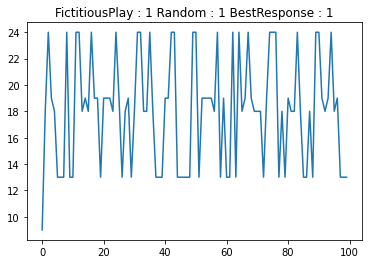

[DEBUG] (Player 0  ) Expected utility  [1.109375 0.65625  1.046875 1.0625  ]
[DEBUG] (Player 0  ) Expected utility  [1.26388889 0.47916667 1.09722222 1.11111111]
[DEBUG] (Player 0  ) Expected utility  [2.35555556 0.23209877 0.95802469 0.88888889]
[DEBUG] (Player 0  ) Expected utility  [2.35555556 0.23209877 0.95802469 0.88888889]
[DEBUG] (Player 0  ) Expected utility  [2.94444444 0.19341564 0.79835391 0.74074074]
[DEBUG] (Player 0  ) Expected utility  [2.94444444 0.19341564 0.79835391 0.74074074]
[DEBUG] (Player 0  ) Expected utility  [3.36507937 0.16578483 0.68430335 0.63492063]
[DEBUG] (Player 0  ) Expected utility  [3.36507937 0.16578483 0.68430335 0.63492063]
[DEBUG] (Player 0  ) Expected utility  [3.68055556 0.14506173 0.59876543 0.55555556]
[DEBUG] (Player 0  ) Expected utility  [3.68055556 0.14506173 0.59876543 0.55555556]
[DEBUG] (Player 0  ) Expected utility  [3.92592593 0.12894376 0.53223594 0.49382716]
[DEBUG] (Player 0  ) Expected utility  [3.65608466 0.15432099 0.54056437 

[DEBUG] (Player 0  ) Expected utility  [4.47596154 0.04334837 0.09526353 0.093107  ]
[DEBUG] (Player 0  ) Expected utility  [4.47596154 0.04334837 0.09526353 0.093107  ]
[DEBUG] (Player 0  ) Expected utility  [4.48113208 0.04253048 0.09346611 0.09135026]
[DEBUG] (Player 0  ) Expected utility  [4.48113208 0.04253048 0.09346611 0.09135026]
[DEBUG] (Player 0  ) Expected utility  [4.48611111 0.04174287 0.09173525 0.08965859]
[DEBUG] (Player 0  ) Expected utility  [4.33192946 0.04257262 0.0904982  0.08983622]
[DEBUG] (Player 0  ) Expected utility  [4.38152046 0.04071975 0.08888773 0.0883863 ]
[DEBUG] (Player 0  ) Expected utility  [4.38152046 0.04071975 0.08888773 0.0883863 ]
[DEBUG] (Player 0  ) Expected utility  [4.38603439 0.03999261 0.08730045 0.08680798]
[DEBUG] (Player 0  ) Expected utility  [4.38603439 0.03999261 0.08730045 0.08680798]
[DEBUG] (Player 0  ) Expected utility  [4.39038994 0.03929099 0.08576886 0.08528503]
[DEBUG] (Player 0  ) Expected utility  [4.39038994 0.03929099 0.0

[DEBUG] (Player 0  ) Expected utility  [4.73709042 0.02146727 0.04857526 0.04788369]
[DEBUG] (Player 0  ) Expected utility  [4.738541   0.02125472 0.04809432 0.04740959]
[DEBUG] (Player 0  ) Expected utility  [4.738541   0.02125472 0.04809432 0.04740959]
[DEBUG] (Player 0  ) Expected utility  [4.73996313 0.02104634 0.0476228  0.04694479]
[DEBUG] (Player 0  ) Expected utility  [4.73996313 0.02104634 0.0476228  0.04694479]
[DEBUG] (Player 0  ) Expected utility  [4.74135764 0.02084201 0.04716045 0.04648902]
[DEBUG] (Player 0  ) Expected utility  [4.74135764 0.02084201 0.04716045 0.04648902]
[DEBUG] (Player 0  ) Expected utility  [4.74272534 0.02064161 0.04670698 0.04604201]
[DEBUG] (Player 0  ) Expected utility  [4.76953345 0.02010725 0.04691476 0.04620338]
[DEBUG] (Player 0  ) Expected utility  [4.77088268 0.01991575 0.04646795 0.04576334]
[DEBUG] (Player 0  ) Expected utility  [4.77088268 0.01991575 0.04646795 0.04576334]
[DEBUG] (Player 0  ) Expected utility  [4.77220646 0.01972787 0.0

[DEBUG] (Player 0  ) Expected utility  [4.53573559 0.01662299 0.03253859 0.03203435]
[DEBUG] (Player 0  ) Expected utility  [4.53041661 0.01673377 0.03236399 0.03191181]
[DEBUG] (Player 0  ) Expected utility  [4.5638843  0.01637769 0.03216422 0.03173666]
[DEBUG] (Player 0  ) Expected utility  [4.5638843  0.01637769 0.03216422 0.03173666]
[DEBUG] (Player 0  ) Expected utility  [4.56450112 0.01626923 0.03195121 0.03152649]
[DEBUG] (Player 0  ) Expected utility  [4.56450112 0.01626923 0.03195121 0.03152649]
[DEBUG] (Player 0  ) Expected utility  [4.56510983 0.0161622  0.03174101 0.03131907]
[DEBUG] (Player 0  ) Expected utility  [4.56510983 0.0161622  0.03174101 0.03131907]
[DEBUG] (Player 0  ) Expected utility  [4.56571058 0.01605656 0.03153355 0.03111437]
[DEBUG] (Player 0  ) Expected utility  [4.56571058 0.01605656 0.03153355 0.03111437]
[DEBUG] (Player 0  ) Expected utility  [4.56630353 0.0159523  0.03132879 0.03091233]
[DEBUG] (Player 0  ) Expected utility  [4.55609593 0.01598395 0.0

[DEBUG] (Player 0  ) Expected utility  [4.50874734 0.01332236 0.02440858 0.02385573]
[DEBUG] (Player 0  ) Expected utility  [4.50909948 0.01325507 0.0242853  0.02373524]
[DEBUG] (Player 0  ) Expected utility  [4.50909948 0.01325507 0.0242853  0.02373524]
[DEBUG] (Player 0  ) Expected utility  [4.50944808 0.01318846 0.02416326 0.02361597]
[DEBUG] (Player 0  ) Expected utility  [4.52721782 0.0131899  0.02413746 0.02354739]
[DEBUG] (Player 0  ) Expected utility  [4.47990857 0.01338139 0.02399942 0.02338884]
[DEBUG] (Player 0  ) Expected utility  [4.47990857 0.01338139 0.02399942 0.02338884]
[DEBUG] (Player 0  ) Expected utility  [4.48024798 0.01331482 0.02388002 0.02327248]
[DEBUG] (Player 0  ) Expected utility  [4.48024798 0.01331482 0.02388002 0.02327248]
[DEBUG] (Player 0  ) Expected utility  [4.48058403 0.0132489  0.02376181 0.02315727]
[DEBUG] (Player 0  ) Expected utility  [4.48058403 0.0132489  0.02376181 0.02315727]
[DEBUG] (Player 0  ) Expected utility  [4.48091678 0.01318364 0.0

[DEBUG] (Player 0  ) Expected utility  [4.36629799 0.01167717 0.01957502 0.01900664]
[DEBUG] (Player 0  ) Expected utility  [4.36629799 0.01167717 0.01957502 0.01900664]
[DEBUG] (Player 0  ) Expected utility  [4.36651623 0.01162989 0.01949577 0.01892969]
[DEBUG] (Player 0  ) Expected utility  [4.36651623 0.01162989 0.01949577 0.01892969]
[DEBUG] (Player 0  ) Expected utility  [4.3667327  0.01158299 0.01941716 0.01885336]
[DEBUG] (Player 0  ) Expected utility  [4.3667327  0.01158299 0.01941716 0.01885336]
[DEBUG] (Player 0  ) Expected utility  [4.36694744 0.01153648 0.01933918 0.01877765]
[DEBUG] (Player 0  ) Expected utility  [4.35665097 0.01158268 0.01927058 0.01874055]
[DEBUG] (Player 0  ) Expected utility  [4.32148162 0.01168808 0.01918302 0.01863978]
[DEBUG] (Player 0  ) Expected utility  [4.32148162 0.01168808 0.01918302 0.01863978]
[DEBUG] (Player 0  ) Expected utility  [4.32169073 0.01164151 0.0191066  0.01856552]
[DEBUG] (Player 0  ) Expected utility  [4.32169073 0.01164151 0.0

[DEBUG] (Player 0  ) Expected utility  [4.41918983 0.00951485 0.01624768 0.0157831 ]
[DEBUG] (Player 0  ) Expected utility  [4.38792271 0.00964673 0.01613852 0.01567844]
[DEBUG] (Player 0  ) Expected utility  [4.38792271 0.00964673 0.01613852 0.01567844]
[DEBUG] (Player 0  ) Expected utility  [4.38807501 0.00961414 0.016084   0.01562547]
[DEBUG] (Player 0  ) Expected utility  [4.38807501 0.00961414 0.016084   0.01562547]
[DEBUG] (Player 0  ) Expected utility  [4.38822629 0.00958177 0.01602985 0.01557286]
[DEBUG] (Player 0  ) Expected utility  [4.38822629 0.00958177 0.01602985 0.01557286]
[DEBUG] (Player 0  ) Expected utility  [4.38837655 0.00954961 0.01597605 0.0155206 ]
[DEBUG] (Player 0  ) Expected utility  [4.38837655 0.00954961 0.01597605 0.0155206 ]
[DEBUG] (Player 0  ) Expected utility  [4.3885258  0.00951767 0.01592262 0.01546869]
[DEBUG] (Player 0  ) Expected utility  [4.40031726 0.00952987 0.01597242 0.01550565]
[DEBUG] (Player 0  ) Expected utility  [4.36965406 0.00960645 0.0

[DEBUG] (Player 0  ) Expected utility  [4.36072167 0.008475   0.01395345 0.01351761]
[DEBUG] (Player 0  ) Expected utility  [4.36083418 0.00845029 0.01391277 0.0134782 ]
[DEBUG] (Player 0  ) Expected utility  [4.36083418 0.00845029 0.01391277 0.0134782 ]
[DEBUG] (Player 0  ) Expected utility  [4.36094603 0.00842573 0.01387233 0.01343902]
[DEBUG] (Player 0  ) Expected utility  [4.39958268 0.00835427 0.01390452 0.01344962]
[DEBUG] (Player 0  ) Expected utility  [4.39969487 0.00833005 0.01386422 0.01341064]
[DEBUG] (Player 0  ) Expected utility  [4.39969487 0.00833005 0.01386422 0.01341064]
[DEBUG] (Player 0  ) Expected utility  [4.39980641 0.00830598 0.01382415 0.01337188]
[DEBUG] (Player 0  ) Expected utility  [4.39980641 0.00830598 0.01382415 0.01337188]
[DEBUG] (Player 0  ) Expected utility  [4.39991731 0.00828204 0.01378431 0.01333334]
[DEBUG] (Player 0  ) Expected utility  [4.39991731 0.00828204 0.01378431 0.01333334]
[DEBUG] (Player 0  ) Expected utility  [4.40002757 0.00825824 0.0

[DEBUG] (Player 0  ) Expected utility  [4.44201454 0.00728631 0.01238624 0.01191902]
[DEBUG] (Player 0  ) Expected utility  [4.44210261 0.00726767 0.01235456 0.01188854]
[DEBUG] (Player 0  ) Expected utility  [4.44210261 0.00726767 0.01235456 0.01188854]
[DEBUG] (Player 0  ) Expected utility  [4.44219023 0.00724913 0.01232304 0.01185821]
[DEBUG] (Player 0  ) Expected utility  [4.44219023 0.00724913 0.01232304 0.01185821]
[DEBUG] (Player 0  ) Expected utility  [4.4422774  0.00723069 0.01229168 0.01182804]
[DEBUG] (Player 0  ) Expected utility  [4.4422774  0.00723069 0.01229168 0.01182804]
[DEBUG] (Player 0  ) Expected utility  [4.44236413 0.00721234 0.01226049 0.01179802]
[DEBUG] (Player 0  ) Expected utility  [4.43507552 0.00723197 0.01223245 0.01178389]
[DEBUG] (Player 0  ) Expected utility  [4.41240343 0.00727513 0.01219687 0.01174264]
[DEBUG] (Player 0  ) Expected utility  [4.41240343 0.00727513 0.01219687 0.01174264]
[DEBUG] (Player 0  ) Expected utility  [4.4124887  0.00725676 0.0

[DEBUG] (Player 0  ) Expected utility  [4.31359275 0.00680647 0.01096488 0.01047586]
[DEBUG] (Player 0  ) Expected utility  [4.27778004 0.00688523 0.01095323 0.01049261]
[DEBUG] (Player 0  ) Expected utility  [4.27784694 0.00686958 0.01092833 0.01046876]
[DEBUG] (Player 0  ) Expected utility  [4.27784694 0.00686958 0.01092833 0.01046876]
[DEBUG] (Player 0  ) Expected utility  [4.27791353 0.006854   0.01090355 0.01044503]
[DEBUG] (Player 0  ) Expected utility  [4.27791353 0.006854   0.01090355 0.01044503]
[DEBUG] (Player 0  ) Expected utility  [4.27797982 0.00683849 0.01087889 0.0104214 ]
[DEBUG] (Player 0  ) Expected utility  [4.27797982 0.00683849 0.01087889 0.0104214 ]
[DEBUG] (Player 0  ) Expected utility  [4.27804581 0.00682306 0.01085433 0.01039787]
[DEBUG] (Player 0  ) Expected utility  [4.27804581 0.00682306 0.01085433 0.01039787]
[DEBUG] (Player 0  ) Expected utility  [4.27811151 0.00680769 0.01082988 0.01037445]
[DEBUG] (Player 0  ) Expected utility  [4.27957618 0.0068285  0.0

[DEBUG] (Player 0  ) Expected utility  [4.26937461 0.0062989  0.00988773 0.00939935]
[DEBUG] (Player 0  ) Expected utility  [4.26942883 0.00628599 0.00986747 0.00938009]
[DEBUG] (Player 0  ) Expected utility  [4.26942883 0.00628599 0.00986747 0.00938009]
[DEBUG] (Player 0  ) Expected utility  [4.26948284 0.00627314 0.00984729 0.0093609 ]
[DEBUG] (Player 0  ) Expected utility  [4.27289635 0.006248   0.00982798 0.0093286 ]
[DEBUG] (Player 0  ) Expected utility  [4.29042517 0.00619756 0.00981127 0.00931711]
[DEBUG] (Player 0  ) Expected utility  [4.29042517 0.00619756 0.00981127 0.00931711]
[DEBUG] (Player 0  ) Expected utility  [4.29047899 0.00618494 0.00979128 0.00929813]
[DEBUG] (Player 0  ) Expected utility  [4.29047899 0.00618494 0.00979128 0.00929813]
[DEBUG] (Player 0  ) Expected utility  [4.2905326  0.00617237 0.00977138 0.00927924]
[DEBUG] (Player 0  ) Expected utility  [4.2905326  0.00617237 0.00977138 0.00927924]
[DEBUG] (Player 0  ) Expected utility  [4.290586   0.00615985 0.0

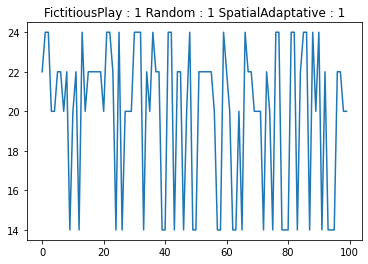

[DEBUG] (Player 0  ) Expected utility  [1.140625 1.03125  0.96875  1.21875 ]
[DEBUG] (Player 0  ) Expected utility  [1.21296296 0.62037037 0.65432099 1.22839506]
[DEBUG] (Player 0  ) Expected utility  [0.97037037 0.4962963  0.52345679 1.9654321 ]
[DEBUG] (Player 0  ) Expected utility  [0.97037037 0.4962963  0.52345679 1.9654321 ]
[DEBUG] (Player 0  ) Expected utility  [0.80864198 0.41358025 0.43621399 2.45679012]
[DEBUG] (Player 0  ) Expected utility  [0.80864198 0.41358025 0.43621399 2.45679012]
[DEBUG] (Player 0  ) Expected utility  [0.69312169 0.35449735 0.37389771 2.80776014]
[DEBUG] (Player 0  ) Expected utility  [0.69312169 0.35449735 0.37389771 2.80776014]
[DEBUG] (Player 0  ) Expected utility  [0.60648148 0.31018519 0.32716049 3.07098765]
[DEBUG] (Player 0  ) Expected utility  [0.60648148 0.31018519 0.32716049 3.07098765]
[DEBUG] (Player 0  ) Expected utility  [0.53909465 0.27572016 0.29080933 3.27572016]
[DEBUG] (Player 0  ) Expected utility  [0.55379189 0.36243386 0.38536155 

[DEBUG] (Player 0  ) Expected utility  [0.07224069 0.07649441 0.07628997 4.01676427]
[DEBUG] (Player 0  ) Expected utility  [0.07087766 0.07505112 0.07485053 4.02140435]
[DEBUG] (Player 0  ) Expected utility  [0.07087766 0.07505112 0.07485053 4.02140435]
[DEBUG] (Player 0  ) Expected utility  [0.06956511 0.07366128 0.07346441 4.02587258]
[DEBUG] (Player 0  ) Expected utility  [0.0682488  0.07519125 0.07624991 4.41021099]
[DEBUG] (Player 0  ) Expected utility  [0.06700791 0.07382414 0.07486354 4.41492779]
[DEBUG] (Player 0  ) Expected utility  [0.06700791 0.07382414 0.07486354 4.41492779]
[DEBUG] (Player 0  ) Expected utility  [0.06581134 0.07250585 0.0735267  4.41947614]
[DEBUG] (Player 0  ) Expected utility  [0.06581134 0.07250585 0.0735267  4.41947614]
[DEBUG] (Player 0  ) Expected utility  [0.06465676 0.07123382 0.07223675 4.42386489]
[DEBUG] (Player 0  ) Expected utility  [0.06465676 0.07123382 0.07223675 4.42386489]
[DEBUG] (Player 0  ) Expected utility  [0.06354199 0.07000565 0.0

[DEBUG] (Player 0  ) Expected utility  [0.036801   0.03996921 0.0422037  4.40401459]
[DEBUG] (Player 0  ) Expected utility  [0.036801   0.03996921 0.0422037  4.40401459]
[DEBUG] (Player 0  ) Expected utility  [0.0364402  0.03957735 0.04178994 4.40533632]
[DEBUG] (Player 0  ) Expected utility  [0.0364402  0.03957735 0.04178994 4.40533632]
[DEBUG] (Player 0  ) Expected utility  [0.03608642 0.0391931  0.04138421 4.40663239]
[DEBUG] (Player 0  ) Expected utility  [0.03608642 0.0391931  0.04138421 4.40663239]
[DEBUG] (Player 0  ) Expected utility  [0.03573943 0.03881625 0.04098629 4.40790353]
[DEBUG] (Player 0  ) Expected utility  [0.03601274 0.03896962 0.04146423 4.40488861]
[DEBUG] (Player 0  ) Expected utility  [0.03614174 0.0383269  0.03974653 4.38839444]
[DEBUG] (Player 0  ) Expected utility  [0.03614174 0.0383269  0.03974653 4.38839444]
[DEBUG] (Player 0  ) Expected utility  [0.03580078 0.03796533 0.03937157 4.38961208]
[DEBUG] (Player 0  ) Expected utility  [0.03580078 0.03796533 0.0

[DEBUG] (Player 0  ) Expected utility  [0.02414638 0.02779305 0.02820751 4.64113262]
[DEBUG] (Player 0  ) Expected utility  [0.02398541 0.02760777 0.02801946 4.64176839]
[DEBUG] (Player 0  ) Expected utility  [0.02398541 0.02760777 0.02801946 4.64176839]
[DEBUG] (Player 0  ) Expected utility  [0.02372177 0.02750669 0.02788533 4.68438402]
[DEBUG] (Player 0  ) Expected utility  [0.02351548 0.0275295  0.02799914 4.65311684]
[DEBUG] (Player 0  ) Expected utility  [0.02342495 0.02731556 0.02784429 4.64087397]
[DEBUG] (Player 0  ) Expected utility  [0.02342495 0.02731556 0.02784429 4.64087397]
[DEBUG] (Player 0  ) Expected utility  [0.02327184 0.02713703 0.0276623  4.64148469]
[DEBUG] (Player 0  ) Expected utility  [0.02327184 0.02713703 0.0276623  4.64148469]
[DEBUG] (Player 0  ) Expected utility  [0.02312073 0.02696081 0.02748268 4.64208748]
[DEBUG] (Player 0  ) Expected utility  [0.02322591 0.02700608 0.02750986 4.64601919]
[DEBUG] (Player 0  ) Expected utility  [0.02307607 0.02683185 0.0

[DEBUG] (Player 0  ) Expected utility  [0.01781891 0.0209546  0.02125125 4.60392606]
[DEBUG] (Player 0  ) Expected utility  [0.01781891 0.0209546  0.02125125 4.60392606]
[DEBUG] (Player 0  ) Expected utility  [0.01772936 0.0208493  0.02114446 4.60428198]
[DEBUG] (Player 0  ) Expected utility  [0.01783699 0.02086561 0.02126679 4.59672736]
[DEBUG] (Player 0  ) Expected utility  [0.01785527 0.02071018 0.02080342 4.58760152]
[DEBUG] (Player 0  ) Expected utility  [0.01785527 0.02071018 0.02080342 4.58760152]
[DEBUG] (Player 0  ) Expected utility  [0.01776644 0.02060715 0.02069992 4.5879491 ]
[DEBUG] (Player 0  ) Expected utility  [0.01776644 0.02060715 0.02069992 4.5879491 ]
[DEBUG] (Player 0  ) Expected utility  [0.01767849 0.02050513 0.02059744 4.58829323]
[DEBUG] (Player 0  ) Expected utility  [0.01767849 0.02050513 0.02059744 4.58829323]
[DEBUG] (Player 0  ) Expected utility  [0.0175914  0.02040412 0.02049598 4.58863397]
[DEBUG] (Player 0  ) Expected utility  [0.0175914  0.02040412 0.0

[DEBUG] (Player 0  ) Expected utility  [0.0143211  0.01695757 0.01655736 4.64107857]
[DEBUG] (Player 0  ) Expected utility  [0.01426312 0.01688891 0.01649033 4.64131054]
[DEBUG] (Player 0  ) Expected utility  [0.01426312 0.01688891 0.01649033 4.64131054]
[DEBUG] (Player 0  ) Expected utility  [0.01420561 0.01682081 0.01642384 4.64154064]
[DEBUG] (Player 0  ) Expected utility  [0.01420561 0.01682081 0.01642384 4.64154064]
[DEBUG] (Player 0  ) Expected utility  [0.01414856 0.01675326 0.01635788 4.64176889]
[DEBUG] (Player 0  ) Expected utility  [0.01411874 0.01677212 0.01635135 4.65075337]
[DEBUG] (Player 0  ) Expected utility  [0.01417112 0.01666371 0.01643536 4.67828322]
[DEBUG] (Player 0  ) Expected utility  [0.01417112 0.01666371 0.01643536 4.67828322]
[DEBUG] (Player 0  ) Expected utility  [0.01411466 0.01659732 0.01636989 4.6785096 ]
[DEBUG] (Player 0  ) Expected utility  [0.01411466 0.01659732 0.01636989 4.6785096 ]
[DEBUG] (Player 0  ) Expected utility  [0.01405865 0.01653146 0.0

[DEBUG] (Player 0  ) Expected utility  [0.01215442 0.01402946 0.01411576 4.64188779]
[DEBUG] (Player 0  ) Expected utility  [0.01215442 0.01402946 0.01411576 4.64188779]
[DEBUG] (Player 0  ) Expected utility  [0.01211335 0.01398206 0.01406807 4.64204891]
[DEBUG] (Player 0  ) Expected utility  [0.01211335 0.01398206 0.01406807 4.64204891]
[DEBUG] (Player 0  ) Expected utility  [0.01207257 0.01393498 0.0140207  4.64220894]
[DEBUG] (Player 0  ) Expected utility  [0.01207257 0.01393498 0.0140207  4.64220894]
[DEBUG] (Player 0  ) Expected utility  [0.01203206 0.01388822 0.01397365 4.6423679 ]
[DEBUG] (Player 0  ) Expected utility  [0.01203206 0.01388822 0.01397365 4.6423679 ]
[DEBUG] (Player 0  ) Expected utility  [0.01199182 0.01384177 0.01392692 4.64252579]
[DEBUG] (Player 0  ) Expected utility  [0.0120868  0.01381886 0.01382161 4.63075238]
[DEBUG] (Player 0  ) Expected utility  [0.01204651 0.0137728  0.01377554 4.63090883]
[DEBUG] (Player 0  ) Expected utility  [0.01204651 0.0137728  0.0

[DEBUG] (Player 0  ) Expected utility  [0.01053185 0.01207803 0.01198012 4.66772777]
[DEBUG] (Player 0  ) Expected utility  [0.01053185 0.01207803 0.01198012 4.66772777]
[DEBUG] (Player 0  ) Expected utility  [0.01050124 0.01204292 0.01194529 4.66784749]
[DEBUG] (Player 0  ) Expected utility  [0.01049716 0.01207392 0.01202375 4.72164278]
[DEBUG] (Player 0  ) Expected utility  [0.01047037 0.01203279 0.01198522 4.71680385]
[DEBUG] (Player 0  ) Expected utility  [0.01047037 0.01203279 0.01198522 4.71680385]
[DEBUG] (Player 0  ) Expected utility  [0.01044011 0.01199801 0.01195058 4.71692344]
[DEBUG] (Player 0  ) Expected utility  [0.01044011 0.01199801 0.01195058 4.71692344]
[DEBUG] (Player 0  ) Expected utility  [0.01041002 0.01196344 0.01191614 4.71704233]
[DEBUG] (Player 0  ) Expected utility  [0.01041002 0.01196344 0.01191614 4.71704233]
[DEBUG] (Player 0  ) Expected utility  [0.01038011 0.01192906 0.0118819  4.71716054]
[DEBUG] (Player 0  ) Expected utility  [0.01038011 0.01192906 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00915524 0.01058797 0.01062425 4.63103577]
[DEBUG] (Player 0  ) Expected utility  [0.00915524 0.01058797 0.01062425 4.63103577]
[DEBUG] (Player 0  ) Expected utility  [0.00913188 0.01056096 0.01059715 4.63112711]
[DEBUG] (Player 0  ) Expected utility  [0.00913188 0.01056096 0.01059715 4.63112711]
[DEBUG] (Player 0  ) Expected utility  [0.00910865 0.01053409 0.01057018 4.63121799]
[DEBUG] (Player 0  ) Expected utility  [0.00910865 0.01053409 0.01057018 4.63121799]
[DEBUG] (Player 0  ) Expected utility  [0.00908553 0.01050735 0.01054335 4.63130841]
[DEBUG] (Player 0  ) Expected utility  [0.00914016 0.01049341 0.0104818  4.62218231]
[DEBUG] (Player 0  ) Expected utility  [0.00911702 0.01046684 0.01045526 4.62227209]
[DEBUG] (Player 0  ) Expected utility  [0.00911702 0.01046684 0.01045526 4.62227209]
[DEBUG] (Player 0  ) Expected utility  [0.00909399 0.01044041 0.01042886 4.62236142]
[DEBUG] (Player 0  ) Expected utility  [0.00909399 0.01044041 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00808882 0.0094752  0.00944989 4.66943948]
[DEBUG] (Player 0  ) Expected utility  [0.00806386 0.00946283 0.00935388 4.67932443]
[DEBUG] (Player 0  ) Expected utility  [0.00806386 0.00946283 0.00935388 4.67932443]
[DEBUG] (Player 0  ) Expected utility  [0.00804558 0.00944137 0.00933267 4.67939727]
[DEBUG] (Player 0  ) Expected utility  [0.00804558 0.00944137 0.00933267 4.67939727]
[DEBUG] (Player 0  ) Expected utility  [0.00802737 0.00942001 0.00931155 4.67946978]
[DEBUG] (Player 0  ) Expected utility  [0.00802737 0.00942001 0.00931155 4.67946978]
[DEBUG] (Player 0  ) Expected utility  [0.00800925 0.00939874 0.00929053 4.67954197]
[DEBUG] (Player 0  ) Expected utility  [0.00800925 0.00939874 0.00929053 4.67954197]
[DEBUG] (Player 0  ) Expected utility  [0.00799121 0.00937758 0.00926961 4.67961383]
[DEBUG] (Player 0  ) Expected utility  [0.00798197 0.00940131 0.00931372 4.72599148]
[DEBUG] (Player 0  ) Expected utility  [0.00796403 0.00938018 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00712745 0.00861849 0.00846993 4.78232555]
[DEBUG] (Player 0  ) Expected utility  [0.00712745 0.00861849 0.00846993 4.78232555]
[DEBUG] (Player 0  ) Expected utility  [0.00711288 0.00860087 0.00845261 4.78238604]
[DEBUG] (Player 0  ) Expected utility  [0.0071202  0.00859017 0.0084475  4.77147997]
[DEBUG] (Player 0  ) Expected utility  [0.00711049 0.00856559 0.0084269  4.76434286]
[DEBUG] (Player 0  ) Expected utility  [0.00706671 0.00857389 0.00843707 4.74933337]
[DEBUG] (Player 0  ) Expected utility  [0.00705231 0.00855643 0.00841989 4.74939296]
[DEBUG] (Player 0  ) Expected utility  [0.00705231 0.00855643 0.00841989 4.74939296]
[DEBUG] (Player 0  ) Expected utility  [0.00703798 0.00853904 0.00840277 4.7494523 ]
[DEBUG] (Player 0  ) Expected utility  [0.00703798 0.00853904 0.00840277 4.7494523 ]
[DEBUG] (Player 0  ) Expected utility  [0.0070237  0.00852172 0.00838573 4.7495114 ]
[DEBUG] (Player 0  ) Expected utility  [0.0070237  0.00852172 0.0

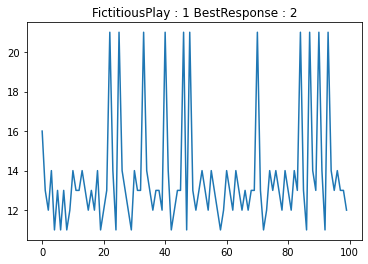

[DEBUG] (Player 0  ) Expected utility  [1.28125  1.40625  1.03125  0.859375]
[DEBUG] (Player 0  ) Expected utility  [1.28125  1.40625  1.03125  0.859375]
[DEBUG] (Player 0  ) Expected utility  [0.95555556 2.16666667 1.00555556 0.72222222]
[DEBUG] (Player 0  ) Expected utility  [1.02666667 2.33777778 1.09333333 0.64      ]
[DEBUG] (Player 0  ) Expected utility  [0.96090535 3.30246914 1.04115226 0.41152263]
[DEBUG] (Player 0  ) Expected utility  [0.96090535 3.30246914 1.04115226 0.41152263]
[DEBUG] (Player 0  ) Expected utility  [0.82363316 3.77425044 0.89241623 0.35273369]
[DEBUG] (Player 0  ) Expected utility  [0.82363316 3.77425044 0.89241623 0.35273369]
[DEBUG] (Player 0  ) Expected utility  [0.72067901 4.12808642 0.7808642  0.30864198]
[DEBUG] (Player 0  ) Expected utility  [0.72067901 4.12808642 0.7808642  0.30864198]
[DEBUG] (Player 0  ) Expected utility  [0.64060357 4.40329218 0.69410151 0.27434842]
[DEBUG] (Player 0  ) Expected utility  [0.65306122 4.69387755 0.76303855 0.223922

[DEBUG] (Player 0  ) Expected utility  [0.11496254 7.28381872 0.14816134 0.0247639 ]
[DEBUG] (Player 0  ) Expected utility  [0.11496254 7.28381872 0.14816134 0.0247639 ]
[DEBUG] (Player 0  ) Expected utility  [0.11279344 7.29223283 0.14536584 0.02429666]
[DEBUG] (Player 0  ) Expected utility  [0.11279344 7.29223283 0.14536584 0.02429666]
[DEBUG] (Player 0  ) Expected utility  [0.11070467 7.30033531 0.14267388 0.02384672]
[DEBUG] (Player 0  ) Expected utility  [0.11070467 7.30033531 0.14267388 0.02384672]
[DEBUG] (Player 0  ) Expected utility  [0.10859224 7.3168567  0.14033338 0.02321894]
[DEBUG] (Player 0  ) Expected utility  [0.10873051 7.32924186 0.14053433 0.0229819 ]
[DEBUG] (Player 0  ) Expected utility  [0.10678889 7.33679259 0.13802479 0.02257151]
[DEBUG] (Player 0  ) Expected utility  [0.10678889 7.33679259 0.13802479 0.02257151]
[DEBUG] (Player 0  ) Expected utility  [0.10491541 7.34407838 0.1356033  0.02217552]
[DEBUG] (Player 0  ) Expected utility  [0.10491541 7.34407838 0.1

[DEBUG] (Player 0  ) Expected utility  [0.0598946  7.62206916 0.07846339 0.01151535]
[DEBUG] (Player 0  ) Expected utility  [0.05930158 7.62440316 0.07768652 0.01140133]
[DEBUG] (Player 0  ) Expected utility  [0.05930158 7.62440316 0.07768652 0.01140133]
[DEBUG] (Player 0  ) Expected utility  [0.0587202  7.62669139 0.07692489 0.01128956]
[DEBUG] (Player 0  ) Expected utility  [0.0587202  7.62669139 0.07692489 0.01128956]
[DEBUG] (Player 0  ) Expected utility  [0.0581501  7.6289352  0.07617805 0.01117995]
[DEBUG] (Player 0  ) Expected utility  [0.0581501  7.6289352  0.07617805 0.01117995]
[DEBUG] (Player 0  ) Expected utility  [0.05759096 7.63113585 0.07544556 0.01107245]
[DEBUG] (Player 0  ) Expected utility  [0.057596   7.63738403 0.07551326 0.01100658]
[DEBUG] (Player 0  ) Expected utility  [0.05704747 7.63954453 0.07479409 0.01090176]
[DEBUG] (Player 0  ) Expected utility  [0.05704747 7.63954453 0.07479409 0.01090176]
[DEBUG] (Player 0  ) Expected utility  [0.05650928 7.64166427 0.0

[DEBUG] (Player 0  ) Expected utility  [4.04921497e-02 7.74017819e+00 5.33291050e-02 7.47470591e-03]
[DEBUG] (Player 0  ) Expected utility  [4.04921497e-02 7.74017819e+00 5.33291050e-02 7.47470591e-03]
[DEBUG] (Player 0  ) Expected utility  [4.02203903e-02 7.74125296e+00 5.29711915e-02 7.42454010e-03]
[DEBUG] (Player 0  ) Expected utility  [4.02220459e-02 7.74439367e+00 5.29945519e-02 7.40162391e-03]
[DEBUG] (Player 0  ) Expected utility  [3.99538989e-02 7.74545455e+00 5.26412548e-02 7.35227975e-03]
[DEBUG] (Player 0  ) Expected utility  [3.99538989e-02 7.74545455e+00 5.26412548e-02 7.35227975e-03]
[DEBUG] (Player 0  ) Expected utility  [3.96893036e-02 7.74650137e+00 5.22926373e-02 7.30358916e-03]
[DEBUG] (Player 0  ) Expected utility  [3.96893036e-02 7.74650137e+00 5.22926373e-02 7.30358916e-03]
[DEBUG] (Player 0  ) Expected utility  [3.94281897e-02 7.74753442e+00 5.19486068e-02 7.25553923e-03]
[DEBUG] (Player 0  ) Expected utility  [3.94281897e-02 7.74753442e+00 5.19486068e-02 7.2555

[DEBUG] (Player 0  ) Expected utility  [3.17165558e-02 7.79551667e+00 4.18804228e-02 5.73521808e-03]
[DEBUG] (Player 0  ) Expected utility  [3.17165558e-02 7.79551667e+00 4.18804228e-02 5.73521808e-03]
[DEBUG] (Player 0  ) Expected utility  [3.15504193e-02 7.79816078e+00 4.16714680e-02 5.69373668e-03]
[DEBUG] (Player 0  ) Expected utility  [3.15504193e-02 7.79816078e+00 4.16714680e-02 5.69373668e-03]
[DEBUG] (Player 0  ) Expected utility  [3.13852338e-02 7.79881577e+00 4.14532927e-02 5.66392654e-03]
[DEBUG] (Player 0  ) Expected utility  [3.13852338e-02 7.79881577e+00 4.14532927e-02 5.66392654e-03]
[DEBUG] (Player 0  ) Expected utility  [3.12217691e-02 7.79946394e+00 4.12373902e-02 5.63442692e-03]
[DEBUG] (Player 0  ) Expected utility  [3.12217691e-02 7.79946394e+00 4.12373902e-02 5.63442692e-03]
[DEBUG] (Player 0  ) Expected utility  [3.10599982e-02 7.80010540e+00 4.10237249e-02 5.60523300e-03]
[DEBUG] (Player 0  ) Expected utility  [3.10599982e-02 7.80010540e+00 4.10237249e-02 5.6052

[DEBUG] (Player 0  ) Expected utility  [2.60675820e-02 7.83278227e+00 3.44854802e-02 4.64312825e-03]
[DEBUG] (Player 0  ) Expected utility  [2.60675820e-02 7.83278227e+00 3.44854802e-02 4.64312825e-03]
[DEBUG] (Player 0  ) Expected utility  [2.59547354e-02 7.83323040e+00 3.43361925e-02 4.62302813e-03]
[DEBUG] (Player 0  ) Expected utility  [2.59547354e-02 7.83323040e+00 3.43361925e-02 4.62302813e-03]
[DEBUG] (Player 0  ) Expected utility  [2.58428615e-02 7.83367466e+00 3.41881916e-02 4.60310128e-03]
[DEBUG] (Player 0  ) Expected utility  [2.58428615e-02 7.83367466e+00 3.41881916e-02 4.60310128e-03]
[DEBUG] (Player 0  ) Expected utility  [2.57319479e-02 7.83411511e+00 3.40414612e-02 4.58334548e-03]
[DEBUG] (Player 0  ) Expected utility  [2.57319479e-02 7.83411511e+00 3.40414612e-02 4.58334548e-03]
[DEBUG] (Player 0  ) Expected utility  [2.56219823e-02 7.83455179e+00 3.38959849e-02 4.56375854e-03]
[DEBUG] (Player 0  ) Expected utility  [2.56215971e-02 7.83462191e+00 3.38965282e-02 4.5633

[DEBUG] (Player 0  ) Expected utility  [2.21262626e-02 7.85759041e+00 2.93049169e-02 3.90428474e-03]
[DEBUG] (Player 0  ) Expected utility  [2.21262626e-02 7.85759041e+00 2.93049169e-02 3.90428474e-03]
[DEBUG] (Player 0  ) Expected utility  [2.20449161e-02 7.85791378e+00 2.91971782e-02 3.88993075e-03]
[DEBUG] (Player 0  ) Expected utility  [2.20449161e-02 7.85791378e+00 2.91971782e-02 3.88993075e-03]
[DEBUG] (Player 0  ) Expected utility  [2.19641654e-02 7.85823479e+00 2.90902289e-02 3.87568192e-03]
[DEBUG] (Player 0  ) Expected utility  [2.19641654e-02 7.85823479e+00 2.90902289e-02 3.87568192e-03]
[DEBUG] (Player 0  ) Expected utility  [2.18840043e-02 7.85855345e+00 2.89840601e-02 3.86153710e-03]
[DEBUG] (Player 0  ) Expected utility  [2.18840043e-02 7.85855345e+00 2.89840601e-02 3.86153710e-03]
[DEBUG] (Player 0  ) Expected utility  [2.18046811e-02 7.85982989e+00 2.88824655e-02 3.84373274e-03]
[DEBUG] (Player 0  ) Expected utility  [2.18046811e-02 7.85982989e+00 2.88824655e-02 3.8437

[DEBUG] (Player 0  ) Expected utility  [1.92202367e-02 7.87598654e+00 2.54777720e-02 3.36763415e-03]
[DEBUG] (Player 0  ) Expected utility  [1.92202367e-02 7.87598654e+00 2.54777720e-02 3.36763415e-03]
[DEBUG] (Player 0  ) Expected utility  [1.91588302e-02 7.87623084e+00 2.53963734e-02 3.35687493e-03]
[DEBUG] (Player 0  ) Expected utility  [1.91588302e-02 7.87623084e+00 2.53963734e-02 3.35687493e-03]
[DEBUG] (Player 0  ) Expected utility  [1.90978148e-02 7.87647359e+00 2.53154932e-02 3.34618425e-03]
[DEBUG] (Player 0  ) Expected utility  [1.90979839e-02 7.87720832e+00 2.53180348e-02 3.34366582e-03]
[DEBUG] (Player 0  ) Expected utility  [1.90373553e-02 7.87744954e+00 2.52376600e-02 3.33305100e-03]
[DEBUG] (Player 0  ) Expected utility  [1.90373553e-02 7.87744954e+00 2.52376600e-02 3.33305100e-03]
[DEBUG] (Player 0  ) Expected utility  [1.89771106e-02 7.87768924e+00 2.51577940e-02 3.32250337e-03]
[DEBUG] (Player 0  ) Expected utility  [1.89771106e-02 7.87768924e+00 2.51577940e-02 3.3225

[DEBUG] (Player 0  ) Expected utility  [1.69889386e-02 7.89017262e+00 2.25348958e-02 2.96033497e-03]
[DEBUG] (Player 0  ) Expected utility  [1.69889386e-02 7.89017262e+00 2.25348958e-02 2.96033497e-03]
[DEBUG] (Player 0  ) Expected utility  [1.69409473e-02 7.89036367e+00 2.24712379e-02 2.95197244e-03]
[DEBUG] (Player 0  ) Expected utility  [1.69410647e-02 7.89094400e+00 2.24730149e-02 2.95020980e-03]
[DEBUG] (Player 0  ) Expected utility  [1.68933434e-02 7.89113399e+00 2.24097106e-02 2.94189935e-03]
[DEBUG] (Player 0  ) Expected utility  [1.68933434e-02 7.89113399e+00 2.24097106e-02 2.94189935e-03]
[DEBUG] (Player 0  ) Expected utility  [1.68458902e-02 7.89132290e+00 2.23467620e-02 2.93363558e-03]
[DEBUG] (Player 0  ) Expected utility  [1.68458902e-02 7.89132290e+00 2.23467620e-02 2.93363558e-03]
[DEBUG] (Player 0  ) Expected utility  [1.67987028e-02 7.89151076e+00 2.22841660e-02 2.92541812e-03]
[DEBUG] (Player 0  ) Expected utility  [1.67987028e-02 7.89151076e+00 2.22841660e-02 2.9254

[DEBUG] (Player 0  ) Expected utility  [1.52218211e-02 7.90144575e+00 2.02015324e-02 2.64073120e-03]
[DEBUG] (Player 0  ) Expected utility  [1.52219059e-02 7.90191570e+00 2.02028231e-02 2.63944979e-03]
[DEBUG] (Player 0  ) Expected utility  [1.51833694e-02 7.90206919e+00 2.01516767e-02 2.63276764e-03]
[DEBUG] (Player 0  ) Expected utility  [1.51833694e-02 7.90206919e+00 2.01516767e-02 2.63276764e-03]
[DEBUG] (Player 0  ) Expected utility  [1.51450276e-02 7.90222190e+00 2.01007887e-02 2.62611923e-03]
[DEBUG] (Player 0  ) Expected utility  [1.51450276e-02 7.90222190e+00 2.01007887e-02 2.62611923e-03]
[DEBUG] (Player 0  ) Expected utility  [1.51068789e-02 7.90237385e+00 2.00501570e-02 2.61950432e-03]
[DEBUG] (Player 0  ) Expected utility  [1.51068789e-02 7.90237385e+00 2.00501570e-02 2.61950432e-03]
[DEBUG] (Player 0  ) Expected utility  [1.50689219e-02 7.90252503e+00 1.99997797e-02 2.61292265e-03]
[DEBUG] (Player 0  ) Expected utility  [1.50689219e-02 7.90252503e+00 1.99997797e-02 2.6129

[DEBUG] (Player 0  ) Expected utility  [1.37877476e-02 7.91100803e+00 1.83070435e-02 2.38233735e-03]
[DEBUG] (Player 0  ) Expected utility  [1.37877476e-02 7.91100803e+00 1.83070435e-02 2.38233735e-03]
[DEBUG] (Player 0  ) Expected utility  [1.37561243e-02 7.91113404e+00 1.82650548e-02 2.37687328e-03]
[DEBUG] (Player 0  ) Expected utility  [1.37561243e-02 7.91113404e+00 1.82650548e-02 2.37687328e-03]
[DEBUG] (Player 0  ) Expected utility  [1.37246458e-02 7.91125946e+00 1.82232584e-02 2.37143421e-03]
[DEBUG] (Player 0  ) Expected utility  [1.37246458e-02 7.91125946e+00 1.82232584e-02 2.37143421e-03]
[DEBUG] (Player 0  ) Expected utility  [1.36933110e-02 7.91138432e+00 1.81816528e-02 2.36601997e-03]
[DEBUG] (Player 0  ) Expected utility  [1.36933110e-02 7.91138432e+00 1.81816528e-02 2.36601997e-03]
[DEBUG] (Player 0  ) Expected utility  [1.36621189e-02 7.91150860e+00 1.81402367e-02 2.36063041e-03]
[DEBUG] (Player 0  ) Expected utility  [1.36618281e-02 7.91160923e+00 1.81406455e-02 2.3603

[DEBUG] (Player 0  ) Expected utility  [1.26005646e-02 7.91855724e+00 1.67365668e-02 2.17078564e-03]
[DEBUG] (Player 0  ) Expected utility  [1.26005646e-02 7.91855724e+00 1.67365668e-02 2.17078564e-03]
[DEBUG] (Player 0  ) Expected utility  [1.25741483e-02 7.91866253e+00 1.67014797e-02 2.16623472e-03]
[DEBUG] (Player 0  ) Expected utility  [1.25741483e-02 7.91866253e+00 1.67014797e-02 2.16623472e-03]
[DEBUG] (Player 0  ) Expected utility  [1.25478425e-02 7.91876738e+00 1.66665393e-02 2.16170285e-03]
[DEBUG] (Player 0  ) Expected utility  [1.25478425e-02 7.91876738e+00 1.66665393e-02 2.16170285e-03]
[DEBUG] (Player 0  ) Expected utility  [1.25216466e-02 7.91887179e+00 1.66317449e-02 2.15718990e-03]
[DEBUG] (Player 0  ) Expected utility  [1.25216935e-02 7.91919131e+00 1.66324649e-02 2.15647418e-03]
[DEBUG] (Player 0  ) Expected utility  [1.24956067e-02 7.91929529e+00 1.65978139e-02 2.15198152e-03]
[DEBUG] (Player 0  ) Expected utility  [1.24956067e-02 7.91929529e+00 1.65978139e-02 2.1519

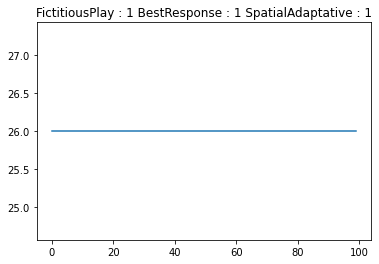

[DEBUG] (Player 0  ) Expected utility  [1.34375  1.390625 1.078125 1.40625 ]
[DEBUG] (Player 0  ) Expected utility  [1.32291667 1.47395833 1.05729167 1.38541667]
[DEBUG] (Player 0  ) Expected utility  [1.00246914 1.99012346 0.7037037  1.01975309]
[DEBUG] (Player 0  ) Expected utility  [1.00246914 1.99012346 0.7037037  1.01975309]
[DEBUG] (Player 0  ) Expected utility  [0.83539095 2.48765432 0.58641975 0.84979424]
[DEBUG] (Player 0  ) Expected utility  [0.83539095 2.48765432 0.58641975 0.84979424]
[DEBUG] (Player 0  ) Expected utility  [0.71604938 2.84303351 0.5026455  0.72839506]
[DEBUG] (Player 0  ) Expected utility  [0.71604938 2.84303351 0.5026455  0.72839506]
[DEBUG] (Player 0  ) Expected utility  [0.62654321 3.1095679  0.43981481 0.63734568]
[DEBUG] (Player 0  ) Expected utility  [0.62654321 3.1095679  0.43981481 0.63734568]
[DEBUG] (Player 0  ) Expected utility  [0.5569273  3.31687243 0.3909465  0.56652949]
[DEBUG] (Player 0  ) Expected utility  [0.42290249 2.40816327 0.37131519 

[DEBUG] (Player 0  ) Expected utility  [0.03472882 1.01727867 0.07132399 0.02587185]
[DEBUG] (Player 0  ) Expected utility  [0.03407356 1.01845381 0.06997826 0.0253837 ]
[DEBUG] (Player 0  ) Expected utility  [0.03407356 1.01845381 0.06997826 0.0253837 ]
[DEBUG] (Player 0  ) Expected utility  [0.03344256 1.01958543 0.06868237 0.02491363]
[DEBUG] (Player 0  ) Expected utility  [0.03267187 0.98357397 0.06911023 0.02393574]
[DEBUG] (Player 0  ) Expected utility  [0.03163145 0.93784963 0.06782273 0.02252749]
[DEBUG] (Player 0  ) Expected utility  [0.03163145 0.93784963 0.06782273 0.02252749]
[DEBUG] (Player 0  ) Expected utility  [0.03106661 0.93881582 0.06661161 0.02212521]
[DEBUG] (Player 0  ) Expected utility  [0.03106661 0.93881582 0.06661161 0.02212521]
[DEBUG] (Player 0  ) Expected utility  [0.03052158 0.93974811 0.06544298 0.02173705]
[DEBUG] (Player 0  ) Expected utility  [0.03052158 0.93974811 0.06544298 0.02173705]
[DEBUG] (Player 0  ) Expected utility  [0.02999534 0.94064825 0.0

[DEBUG] (Player 0  ) Expected utility  [0.01411184 0.55601895 0.03800292 0.00716119]
[DEBUG] (Player 0  ) Expected utility  [0.01411184 0.55601895 0.03800292 0.00716119]
[DEBUG] (Player 0  ) Expected utility  [0.01397349 0.55618582 0.03763034 0.00709098]
[DEBUG] (Player 0  ) Expected utility  [0.01397349 0.55618582 0.03763034 0.00709098]
[DEBUG] (Player 0  ) Expected utility  [0.01383782 0.55634946 0.037265   0.00702214]
[DEBUG] (Player 0  ) Expected utility  [0.01383782 0.55634946 0.037265   0.00702214]
[DEBUG] (Player 0  ) Expected utility  [0.01370477 0.55650994 0.03690668 0.00695462]
[DEBUG] (Player 0  ) Expected utility  [0.0136387  0.54569597 0.03692017 0.00682876]
[DEBUG] (Player 0  ) Expected utility  [0.01339153 0.53170609 0.0366211  0.00658354]
[DEBUG] (Player 0  ) Expected utility  [0.01339153 0.53170609 0.0366211  0.00658354]
[DEBUG] (Player 0  ) Expected utility  [0.01326519 0.53185362 0.03627561 0.00652143]
[DEBUG] (Player 0  ) Expected utility  [0.01326519 0.53185362 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00871416 0.39470923 0.02607205 0.00342599]
[DEBUG] (Player 0  ) Expected utility  [0.00859223 0.38214876 0.02592202 0.00329538]
[DEBUG] (Player 0  ) Expected utility  [0.00859223 0.38214876 0.02592202 0.00329538]
[DEBUG] (Player 0  ) Expected utility  [0.00853533 0.38220041 0.02575035 0.00327356]
[DEBUG] (Player 0  ) Expected utility  [0.00853533 0.38220041 0.02575035 0.00327356]
[DEBUG] (Player 0  ) Expected utility  [0.00847917 0.38225138 0.02558094 0.00325202]
[DEBUG] (Player 0  ) Expected utility  [0.00847917 0.38225138 0.02558094 0.00325202]
[DEBUG] (Player 0  ) Expected utility  [0.00842376 0.38230168 0.02541375 0.00323077]
[DEBUG] (Player 0  ) Expected utility  [0.00842376 0.38230168 0.02541375 0.00323077]
[DEBUG] (Player 0  ) Expected utility  [0.00836906 0.38235133 0.02524872 0.00320979]
[DEBUG] (Player 0  ) Expected utility  [0.00836906 0.38235133 0.02524872 0.00320979]
[DEBUG] (Player 0  ) Expected utility  [0.00829335 0.37578182 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00618238 0.29825731 0.01976088 0.00194274]
[DEBUG] (Player 0  ) Expected utility  [0.00618238 0.29825731 0.01976088 0.00194274]
[DEBUG] (Player 0  ) Expected utility  [0.00615131 0.29828037 0.01966158 0.00193297]
[DEBUG] (Player 0  ) Expected utility  [0.00615131 0.29828037 0.01966158 0.00193297]
[DEBUG] (Player 0  ) Expected utility  [0.00609333 0.29107867 0.0195736  0.00187704]
[DEBUG] (Player 0  ) Expected utility  [0.00609333 0.29107867 0.0195736  0.00187704]
[DEBUG] (Player 0  ) Expected utility  [0.00606301 0.29110072 0.01947622 0.0018677 ]
[DEBUG] (Player 0  ) Expected utility  [0.00606301 0.29110072 0.01947622 0.0018677 ]
[DEBUG] (Player 0  ) Expected utility  [0.006033   0.29112256 0.0193798  0.00185846]
[DEBUG] (Player 0  ) Expected utility  [0.006033   0.29112256 0.0193798  0.00185846]
[DEBUG] (Player 0  ) Expected utility  [0.00600328 0.29114418 0.01928434 0.0018493 ]
[DEBUG] (Player 0  ) Expected utility  [0.00600328 0.29114418 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00479444 0.23966628 0.01597437 0.00125444]
[DEBUG] (Player 0  ) Expected utility  [0.00477503 0.23967826 0.0159097  0.00124936]
[DEBUG] (Player 0  ) Expected utility  [0.00477503 0.23967826 0.0159097  0.00124936]
[DEBUG] (Player 0  ) Expected utility  [0.00475578 0.23969014 0.01584554 0.00124432]
[DEBUG] (Player 0  ) Expected utility  [0.00475578 0.23969014 0.01584554 0.00124432]
[DEBUG] (Player 0  ) Expected utility  [0.00473668 0.23970192 0.01578191 0.00123932]
[DEBUG] (Player 0  ) Expected utility  [0.00472259 0.23502828 0.01578731 0.00121529]
[DEBUG] (Player 0  ) Expected utility  [0.0047037  0.23503974 0.01572416 0.00121043]
[DEBUG] (Player 0  ) Expected utility  [0.0047037  0.23503974 0.01572416 0.00121043]
[DEBUG] (Player 0  ) Expected utility  [0.00468496 0.23505112 0.01566152 0.00120561]
[DEBUG] (Player 0  ) Expected utility  [0.00468496 0.23505112 0.01566152 0.00120561]
[DEBUG] (Player 0  ) Expected utility  [0.00466637 0.2350624  0.0

[DEBUG] (Player 0  ) Expected utility  [0.0039002  0.20220891 0.0133598  0.00088068]
[DEBUG] (Player 0  ) Expected utility  [0.00389697 0.20032218 0.01335992 0.00087335]
[DEBUG] (Player 0  ) Expected utility  [0.00388381 0.20032914 0.01331478 0.0008704 ]
[DEBUG] (Player 0  ) Expected utility  [0.00388381 0.20032914 0.01331478 0.0008704 ]
[DEBUG] (Player 0  ) Expected utility  [0.00387073 0.20033604 0.01326995 0.00086746]
[DEBUG] (Player 0  ) Expected utility  [0.00387073 0.20033604 0.01326995 0.00086746]
[DEBUG] (Player 0  ) Expected utility  [0.00385774 0.2003429  0.01322542 0.00086455]
[DEBUG] (Player 0  ) Expected utility  [0.00385774 0.2003429  0.01322542 0.00086455]
[DEBUG] (Player 0  ) Expected utility  [0.00384484 0.20034972 0.01318119 0.00086166]
[DEBUG] (Player 0  ) Expected utility  [0.00383727 0.19744089 0.01318433 0.00084905]
[DEBUG] (Player 0  ) Expected utility  [0.00382387 0.1970873  0.0131404  0.00084484]
[DEBUG] (Player 0  ) Expected utility  [0.00382387 0.1970873  0.0

[DEBUG] (Player 0  ) Expected utility  [0.00329486 0.17455164 0.01151229 0.00065394]
[DEBUG] (Player 0  ) Expected utility  [0.00328528 0.17455612 0.01147882 0.00065204]
[DEBUG] (Player 0  ) Expected utility  [0.00328311 0.17355416 0.01147966 0.00064831]
[DEBUG] (Player 0  ) Expected utility  [0.00327039 0.17207698 0.01144763 0.00064094]
[DEBUG] (Player 0  ) Expected utility  [0.00327039 0.17207698 0.01144763 0.00064094]
[DEBUG] (Player 0  ) Expected utility  [0.00326093 0.17208134 0.01141455 0.00063908]
[DEBUG] (Player 0  ) Expected utility  [0.00326093 0.17208134 0.01141455 0.00063908]
[DEBUG] (Player 0  ) Expected utility  [0.00325154 0.17208568 0.01138165 0.00063724]
[DEBUG] (Player 0  ) Expected utility  [0.00325154 0.17208568 0.01138165 0.00063724]
[DEBUG] (Player 0  ) Expected utility  [0.00324219 0.17208999 0.01134895 0.00063541]
[DEBUG] (Player 0  ) Expected utility  [0.00324219 0.17208999 0.01134895 0.00063541]
[DEBUG] (Player 0  ) Expected utility  [0.0032329  0.17209428 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00284107 0.15270416 0.01008956 0.00050028]
[DEBUG] (Player 0  ) Expected utility  [0.00284107 0.15270416 0.01008956 0.00050028]
[DEBUG] (Player 0  ) Expected utility  [0.00283384 0.15270716 0.01006389 0.000499  ]
[DEBUG] (Player 0  ) Expected utility  [0.00283384 0.15270716 0.01006389 0.000499  ]
[DEBUG] (Player 0  ) Expected utility  [0.00282664 0.15271014 0.01003834 0.00049774]
[DEBUG] (Player 0  ) Expected utility  [0.00282664 0.15271014 0.01003834 0.00049774]
[DEBUG] (Player 0  ) Expected utility  [0.0028159  0.15081096 0.01001433 0.00049031]
[DEBUG] (Player 0  ) Expected utility  [0.0028159  0.15081096 0.01001433 0.00049031]
[DEBUG] (Player 0  ) Expected utility  [0.00280879 0.15081387 0.00998904 0.00048907]
[DEBUG] (Player 0  ) Expected utility  [0.00280879 0.15081387 0.00998904 0.00048907]
[DEBUG] (Player 0  ) Expected utility  [0.00280171 0.15081677 0.00996388 0.00048784]
[DEBUG] (Player 0  ) Expected utility  [0.00280171 0.15081677 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00250215 0.1357151  0.00900019 0.00039593]
[DEBUG] (Player 0  ) Expected utility  [0.00249648 0.13571721 0.00897978 0.00039503]
[DEBUG] (Player 0  ) Expected utility  [0.00249648 0.13571721 0.00897978 0.00039503]
[DEBUG] (Player 0  ) Expected utility  [0.00249083 0.13571932 0.00895946 0.00039414]
[DEBUG] (Player 0  ) Expected utility  [0.00249083 0.13571932 0.00895946 0.00039414]
[DEBUG] (Player 0  ) Expected utility  [0.0024852  0.13572141 0.00893924 0.00039325]
[DEBUG] (Player 0  ) Expected utility  [0.0024852  0.13572141 0.00893924 0.00039325]
[DEBUG] (Player 0  ) Expected utility  [0.00247961 0.13572349 0.00891911 0.00039236]
[DEBUG] (Player 0  ) Expected utility  [0.00247804 0.13505908 0.00892005 0.0003902 ]
[DEBUG] (Player 0  ) Expected utility  [0.00247152 0.13422225 0.00890005 0.00038716]
[DEBUG] (Player 0  ) Expected utility  [0.00247152 0.13422225 0.00890005 0.00038716]
[DEBUG] (Player 0  ) Expected utility  [0.00246598 0.13422429 0.0

[DEBUG] (Player 0  ) Expected utility  [0.00223249 0.12337225 0.00810574 0.00032372]
[DEBUG] (Player 0  ) Expected utility  [0.0022306  0.12212962 0.00810648 0.00032047]
[DEBUG] (Player 0  ) Expected utility  [0.00222605 0.12213116 0.00808993 0.00031982]
[DEBUG] (Player 0  ) Expected utility  [0.00222605 0.12213116 0.00808993 0.00031982]
[DEBUG] (Player 0  ) Expected utility  [0.00222152 0.12213269 0.00807346 0.00031917]
[DEBUG] (Player 0  ) Expected utility  [0.00222152 0.12213269 0.00807346 0.00031917]
[DEBUG] (Player 0  ) Expected utility  [0.002217   0.12213422 0.00805705 0.00031852]
[DEBUG] (Player 0  ) Expected utility  [0.002217   0.12213422 0.00805705 0.00031852]
[DEBUG] (Player 0  ) Expected utility  [0.00221251 0.12213574 0.0080407  0.00031787]
[DEBUG] (Player 0  ) Expected utility  [0.00221251 0.12213574 0.0080407  0.00031787]
[DEBUG] (Player 0  ) Expected utility  [0.00220803 0.12213725 0.00802443 0.00031723]
[DEBUG] (Player 0  ) Expected utility  [0.00220665 0.1211334  0.0

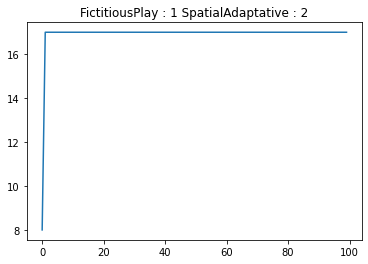

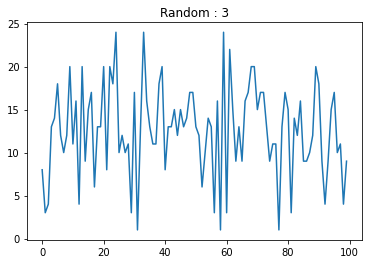

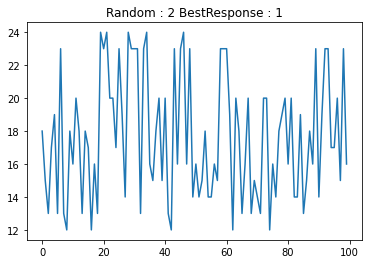

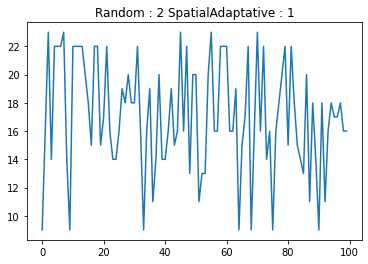

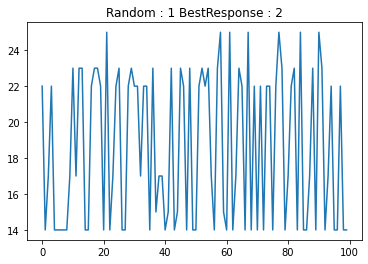

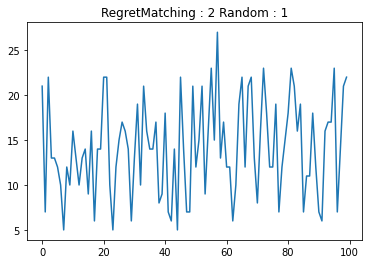

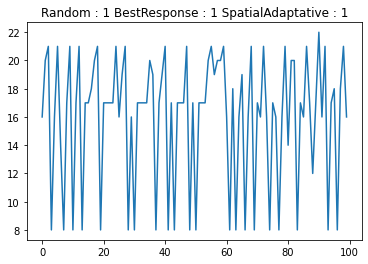

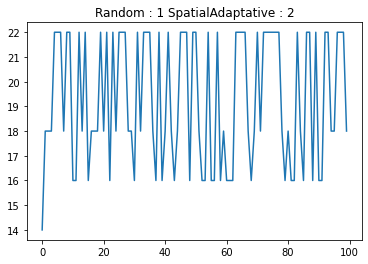

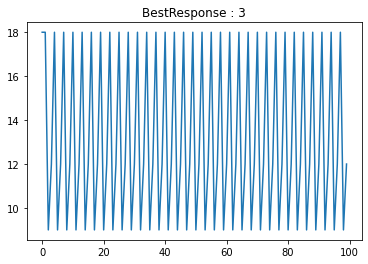

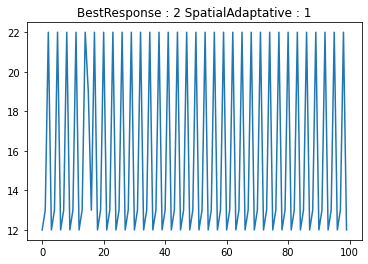

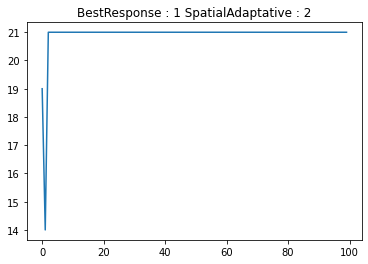

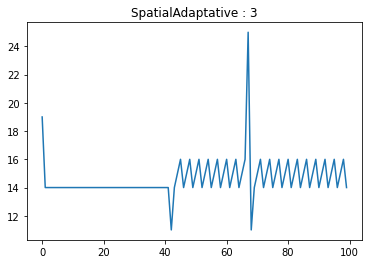

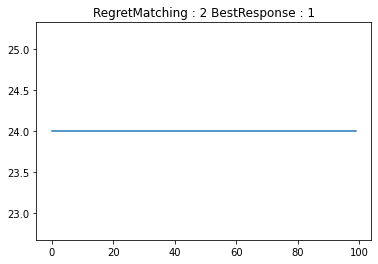

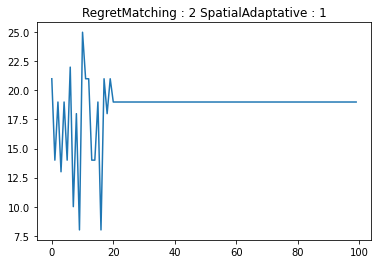

[DEBUG] (Player 1  ) Expected utility  [1.39583333 1.125      1.125      0.84375   ]
[DEBUG] (Player 1  ) Expected utility  [1.32638889 1.20833333 1.1875     0.83333333]
[DEBUG] (Player 1  ) Expected utility  [2.12222222 0.96666667 0.95       0.66666667]
[DEBUG] (Player 2  ) Expected utility  [1.109375  0.9140625 1.15625   0.90625  ]
[DEBUG] (Player 1  ) Expected utility  [2.12222222 0.96666667 0.95       0.66666667]
[DEBUG] (Player 2  ) Expected utility  [1.03333333 0.89444444 1.2        0.92222222]
[DEBUG] (Player 1  ) Expected utility  [2.65277778 0.80555556 0.79166667 0.55555556]
[DEBUG] (Player 2  ) Expected utility  [0.78148148 0.71111111 1.91851852 0.76666667]
[DEBUG] (Player 1  ) Expected utility  [2.46666667 0.82962963 0.82222222 0.52962963]
[DEBUG] (Player 2  ) Expected utility  [0.78148148 0.71111111 1.91851852 0.76666667]
[DEBUG] (Player 1  ) Expected utility  [2.81904762 0.71111111 0.7047619  0.45396825]
[DEBUG] (Player 2  ) Expected utility  [0.62433862 0.58994709 2.39682

[DEBUG] (Player 2  ) Expected utility  [0.17179803 0.11281668 3.48126319 0.17672414]
[DEBUG] (Player 1  ) Expected utility  [5.40552428 0.23007565 0.16489268 0.10709887]
[DEBUG] (Player 2  ) Expected utility  [0.17179803 0.11281668 3.48126319 0.17672414]
[DEBUG] (Player 1  ) Expected utility  [5.57178474 0.22262284 0.15572859 0.1072456 ]
[DEBUG] (Player 2  ) Expected utility  [0.17863888 0.10414772 3.01881514 0.16660838]
[DEBUG] (Player 1  ) Expected utility  [5.75393439 0.22270406 0.15122054 0.11226131]
[DEBUG] (Player 2  ) Expected utility  [0.17863888 0.10414772 3.01881514 0.16660838]
[DEBUG] (Player 1  ) Expected utility  [5.77606491 0.21528059 0.14617985 0.10851927]
[DEBUG] (Player 2  ) Expected utility  [0.17287582 0.10052288 3.03       0.16111111]
[DEBUG] (Player 1  ) Expected utility  [5.77941176 0.21568627 0.14620915 0.10849673]
[DEBUG] (Player 2  ) Expected utility  [0.17287582 0.10052288 3.03       0.16111111]
[DEBUG] (Player 1  ) Expected utility  [5.8001265  0.20872865 0.1

[DEBUG] (Player 1  ) Expected utility  [6.89203354 0.12554427 0.07333495 0.07256894]
[DEBUG] (Player 2  ) Expected utility  [0.11781465 0.05107257 2.04885202 0.08781632]
[DEBUG] (Player 1  ) Expected utility  [6.89203354 0.12554427 0.07333495 0.07256894]
[DEBUG] (Player 2  ) Expected utility  [0.11796484 0.05099984 2.04660539 0.08780842]
[DEBUG] (Player 2  ) Expected utility  [0.11580868 0.05000388 2.04790745 0.08614799]
[DEBUG] (Player 2  ) Expected utility  [0.11580868 0.05000388 2.04790745 0.08614799]
[DEBUG] (Player 1  ) Expected utility  [6.95278513 0.12342005 0.07140408 0.07193073]
[DEBUG] (Player 2  ) Expected utility  [0.11600521 0.04826091 1.88829602 0.08378089]
[DEBUG] (Player 1  ) Expected utility  [7.01900677 0.12347423 0.07061566 0.07285927]
[DEBUG] (Player 1  ) Expected utility  [7.02651372 0.12122924 0.06933174 0.07153455]
[DEBUG] (Player 2  ) Expected utility  [0.11600521 0.04826091 1.88829602 0.08378089]
[DEBUG] (Player 2  ) Expected utility  [0.11396554 0.04735117 1.8

[DEBUG] (Player 2  ) Expected utility  [0.08792822 0.03230083 1.44590887 0.05791315]
[DEBUG] (Player 1  ) Expected utility  [7.50903727 0.08768397 0.04689298 0.05443341]
[DEBUG] (Player 2  ) Expected utility  [0.08681636 0.03186867 1.4459031  0.05715737]
[DEBUG] (Player 1  ) Expected utility  [7.51057557 0.08771304 0.04689245 0.0544417 ]
[DEBUG] (Player 2  ) Expected utility  [0.08681636 0.03186867 1.4459031  0.05715737]
[DEBUG] (Player 1  ) Expected utility  [7.51447919 0.08658852 0.04629126 0.05374372]
[DEBUG] (Player 2  ) Expected utility  [0.08573224 0.03144791 1.44589669 0.05642108]
[DEBUG] (Player 1  ) Expected utility  [7.51597883 0.08661648 0.04629075 0.0537517 ]
[DEBUG] (Player 2  ) Expected utility  [0.08573224 0.03144791 1.44589669 0.05642108]
[DEBUG] (Player 1  ) Expected utility  [7.53332799 0.0855552  0.04560968 0.0531926 ]
[DEBUG] (Player 2  ) Expected utility  [0.08500537 0.03092453 1.41259414 0.05559413]
[DEBUG] (Player 1  ) Expected utility  [7.5787763  0.0855861  0.0

[DEBUG] (Player 1  ) Expected utility  [7.84727723 0.06739337 0.03431455 0.04334539]
[DEBUG] (Player 2  ) Expected utility  [0.06915989 0.0232481  1.11661753 0.04267681]
[DEBUG] (Player 1  ) Expected utility  [7.8482841  0.06740666 0.03431413 0.04334982]
[DEBUG] (Player 2  ) Expected utility  [0.06915989 0.0232481  1.11661753 0.04267681]
[DEBUG] (Player 1  ) Expected utility  [7.85063953 0.06674581 0.03397772 0.04292482]
[DEBUG] (Player 2  ) Expected utility  [0.06849621 0.02301445 1.11643266 0.04225631]
[DEBUG] (Player 1  ) Expected utility  [7.85162696 0.06675872 0.03397732 0.04292912]
[DEBUG] (Player 2  ) Expected utility  [0.06849621 0.02301445 1.11643266 0.04225631]
[DEBUG] (Player 1  ) Expected utility  [7.85393694 0.06611057 0.03364744 0.04251234]
[DEBUG] (Player 2  ) Expected utility  [0.06784515 0.02278544 1.11625108 0.04184401]
[DEBUG] (Player 1  ) Expected utility  [7.85490549 0.0661231  0.03364705 0.04251651]
[DEBUG] (Player 2  ) Expected utility  [0.06784515 0.02278544 1.1

[DEBUG] (Player 2  ) Expected utility  [0.05739163 0.01825786 0.90935963 0.03402419]
[DEBUG] (Player 1  ) Expected utility  [8.06130605 0.05474233 0.02701098 0.03595907]
[DEBUG] (Player 2  ) Expected utility  [0.05739163 0.01825786 0.90935963 0.03402419]
[DEBUG] (Player 1  ) Expected utility  [8.06287929 0.05430786 0.0267966  0.03567368]
[DEBUG] (Player 2  ) Expected utility  [0.05694422 0.01810983 0.90916522 0.03375286]
[DEBUG] (Player 1  ) Expected utility  [8.06357116 0.05431484 0.02679633 0.0356762 ]
[DEBUG] (Player 2  ) Expected utility  [0.05694422 0.01810983 0.90916522 0.03375286]
[DEBUG] (Player 1  ) Expected utility  [8.06511977 0.05388716 0.02658534 0.03539528]
[DEBUG] (Player 2  ) Expected utility  [0.05650374 0.01796418 0.90897372 0.03348583]
[DEBUG] (Player 1  ) Expected utility  [8.06580088 0.05389397 0.02658508 0.03539775]
[DEBUG] (Player 2  ) Expected utility  [0.05650374 0.01796418 0.90897372 0.03348583]
[DEBUG] (Player 1  ) Expected utility  [8.06732541 0.05347292 0.0

[DEBUG] (Player 1  ) Expected utility  [8.20788112 0.04608661 0.02225359 0.03070237]
[DEBUG] (Player 2  ) Expected utility  [0.04901733 0.0150157  0.76694802 0.02827882]
[DEBUG] (Player 1  ) Expected utility  [8.20900549 0.04577937 0.02210523 0.03049769]
[DEBUG] (Player 2  ) Expected utility  [0.04869553 0.01491371 0.76677576 0.02808947]
[DEBUG] (Player 1  ) Expected utility  [8.20951515 0.04578355 0.02210505 0.03049928]
[DEBUG] (Player 2  ) Expected utility  [0.04869553 0.01491371 0.76677576 0.02808947]
[DEBUG] (Player 1  ) Expected utility  [8.2106247  0.04548035 0.02195866 0.0302973 ]
[DEBUG] (Player 2  ) Expected utility  [0.04837792 0.01481309 0.7666057  0.02790263]
[DEBUG] (Player 1  ) Expected utility  [8.21112767 0.04548445 0.02195848 0.03029885]
[DEBUG] (Player 2  ) Expected utility  [0.04837792 0.01481309 0.7666057  0.02790263]
[DEBUG] (Player 1  ) Expected utility  [8.21222268 0.04518521 0.02181402 0.03009952]
[DEBUG] (Player 1  ) Expected utility  [8.21271911 0.04518923 0.0

[DEBUG] (Player 1  ) Expected utility  [8.30196983 0.03979072 0.01895751 0.02672417]
[DEBUG] (Player 2  ) Expected utility  [0.04268262 0.01277161 0.68082969 0.02421593]
[DEBUG] (Player 1  ) Expected utility  [8.31612074 0.03956948 0.01880447 0.02662562]
[DEBUG] (Player 2  ) Expected utility  [0.04252091 0.01266984 0.66293452 0.02404951]
[DEBUG] (Player 1  ) Expected utility  [8.31612074 0.03956948 0.01880447 0.02662562]
[DEBUG] (Player 2  ) Expected utility  [0.04252091 0.01266984 0.66293452 0.02404951]
[DEBUG] (Player 1  ) Expected utility  [8.31695444 0.03934337 0.01869701 0.02647348]
[DEBUG] (Player 2  ) Expected utility  [0.04228115 0.01259624 0.66278928 0.02391153]
[DEBUG] (Player 1  ) Expected utility  [8.31734033 0.03934603 0.01869689 0.02647452]
[DEBUG] (Player 2  ) Expected utility  [0.04228115 0.01259624 0.66278928 0.02391153]
[DEBUG] (Player 1  ) Expected utility  [8.31816459 0.03912247 0.01859066 0.02632409]
[DEBUG] (Player 2  ) Expected utility  [0.04204408 0.01252348 0.6

[DEBUG] (Player 2  ) Expected utility  [0.03786409 0.0110847  0.59765031 0.0211488 ]
[DEBUG] (Player 1  ) Expected utility  [8.38712676 0.03483603 0.01638763 0.02358354]
[DEBUG] (Player 2  ) Expected utility  [0.03767511 0.01102787 0.59752774 0.02104159]
[DEBUG] (Player 1  ) Expected utility  [8.3874338  0.03483787 0.01638754 0.02358428]
[DEBUG] (Player 2  ) Expected utility  [0.03767511 0.01102787 0.59752774 0.02104159]
[DEBUG] (Player 1  ) Expected utility  [8.39835298 0.03466787 0.01627558 0.02350282]
[DEBUG] (Player 2  ) Expected utility  [0.03754213 0.01095338 0.58373452 0.02091748]
[DEBUG] (Player 1  ) Expected utility  [8.39835298 0.03466787 0.01627558 0.02350282]
[DEBUG] (Player 2  ) Expected utility  [0.03754213 0.01095338 0.58373452 0.02091748]
[DEBUG] (Player 1  ) Expected utility  [8.39899571 0.03449453 0.01619421 0.02338531]
[DEBUG] (Player 2  ) Expected utility  [0.03735662 0.01089779 0.5836125  0.0208125 ]
[DEBUG] (Player 1  ) Expected utility  [8.39929779 0.03449632 0.0

[DEBUG] (Player 1  ) Expected utility  [8.45324702 0.03111879 0.01449369 0.02119676]
[DEBUG] (Player 2  ) Expected utility  [0.03386658 0.00974509 0.53248211 0.01868561]
[DEBUG] (Player 1  ) Expected utility  [8.45349567 0.0311201  0.01449362 0.0211973 ]
[DEBUG] (Player 2  ) Expected utility  [0.03386658 0.00974509 0.53248211 0.01868561]
[DEBUG] (Player 1  ) Expected utility  [8.45401495 0.03098055 0.01442863 0.02110224]
[DEBUG] (Player 2  ) Expected utility  [0.03371631 0.00970079 0.53237835 0.01860153]
[DEBUG] (Player 1  ) Expected utility  [8.45426138 0.03098185 0.01442856 0.02110277]
[DEBUG] (Player 2  ) Expected utility  [0.03371631 0.00970079 0.53237835 0.01860153]
[DEBUG] (Player 1  ) Expected utility  [8.45823074 0.03084576 0.01435566 0.02101946]
[DEBUG] (Player 2  ) Expected utility  [0.03360555 0.00964404 0.52142311 0.01850552]
[DEBUG] (Player 1  ) Expected utility  [8.46294128 0.03084714 0.01434331 0.02103469]
[DEBUG] (Player 2  ) Expected utility  [0.03360555 0.00964404 0.5

[DEBUG] (Player 1  ) Expected utility  [8.50669424 0.02811942 0.01299129 0.01924713]
[DEBUG] (Player 1  ) Expected utility  [8.50711942 0.02800557 0.01293869 0.0191692 ]
[DEBUG] (Player 1  ) Expected utility  [8.50711942 0.02800557 0.01293869 0.0191692 ]
[DEBUG] (Player 2  ) Expected utility  [0.03075439 0.00872875 0.48021115 0.01680368]
[DEBUG] (Player 1  ) Expected utility  [8.50754118 0.02789265 0.01288652 0.01909191]
[DEBUG] (Player 2  ) Expected utility  [0.03075678 0.00872787 0.47998564 0.01680325]
[DEBUG] (Player 1  ) Expected utility  [8.50754118 0.02789265 0.01288652 0.01909191]
[DEBUG] (Player 2  ) Expected utility  [0.03063226 0.00869253 0.48000963 0.01673522]
[DEBUG] (Player 2  ) Expected utility  [0.03063344 0.0086921  0.47989823 0.016735  ]
[DEBUG] (Player 2  ) Expected utility  [0.03050991 0.00865705 0.47992202 0.01666753]
[DEBUG] (Player 2  ) Expected utility  [0.03050991 0.00865705 0.47992202 0.01666753]
[DEBUG] (Player 1  ) Expected utility  [8.51501176 0.02778518 0.0

[DEBUG] (Player 1  ) Expected utility  [8.55045358 0.02564657 0.01177065 0.01762438]
[DEBUG] (Player 2  ) Expected utility  [0.02816427 0.00790384 0.43728725 0.01526589]
[DEBUG] (Player 1  ) Expected utility  [8.55080809 0.02555193 0.01172721 0.01755935]
[DEBUG] (Player 2  ) Expected utility  [0.02806126 0.00787434 0.43720999 0.01520939]
[DEBUG] (Player 1  ) Expected utility  [8.55097925 0.02555266 0.01172718 0.01755965]
[DEBUG] (Player 2  ) Expected utility  [0.02806126 0.00787434 0.43720999 0.01520939]
[DEBUG] (Player 1  ) Expected utility  [8.55133116 0.02545872 0.01168406 0.0174951 ]
[DEBUG] (Player 2  ) Expected utility  [0.02795899 0.00784506 0.43713328 0.01515331]
[DEBUG] (Player 1  ) Expected utility  [8.55150107 0.02545944 0.01168402 0.0174954 ]
[DEBUG] (Player 2  ) Expected utility  [0.02795899 0.00784506 0.43713328 0.01515331]
[DEBUG] (Player 1  ) Expected utility  [8.55185041 0.02536618 0.01164122 0.01743131]
[DEBUG] (Player 2  ) Expected utility  [0.02785748 0.00781599 0.4

[DEBUG] (Player 1  ) Expected utility  [8.58738151 0.02349362 0.01072289 0.01619816]
[DEBUG] (Player 2  ) Expected utility  [0.02597541 0.00722103 0.4014086  0.0139858 ]
[DEBUG] (Player 1  ) Expected utility  [8.58738151 0.02349362 0.01072289 0.01619816]
[DEBUG] (Player 2  ) Expected utility  [0.02588807 0.00719629 0.40134117 0.01393825]
[DEBUG] (Player 1  ) Expected utility  [8.58782539 0.02341482 0.01068664 0.01614367]
[DEBUG] (Player 2  ) Expected utility  [0.02588878 0.00719604 0.40126027 0.01393812]
[DEBUG] (Player 1  ) Expected utility  [8.58782539 0.02341482 0.01068664 0.01614367]
[DEBUG] (Player 2  ) Expected utility  [0.02580132 0.00717173 0.4012742  0.01389104]
[DEBUG] (Player 1  ) Expected utility  [8.58826628 0.02333654 0.01065062 0.01608955]
[DEBUG] (Player 2  ) Expected utility  [0.02580203 0.00717147 0.40119384 0.01389091]
[DEBUG] (Player 1  ) Expected utility  [8.58826628 0.02333654 0.01065062 0.01608955]
[DEBUG] (Player 2  ) Expected utility  [0.02571515 0.00714732 0.4

[DEBUG] (Player 2  ) Expected utility  [0.02408806 0.0066511  0.37639596 0.01290814]
[DEBUG] (Player 1  ) Expected utility  [8.61540644 0.021742   0.00988259 0.01502534]
[DEBUG] (Player 2  ) Expected utility  [0.02402387 0.00662644 0.3719841  0.01286399]
[DEBUG] (Player 1  ) Expected utility  [8.61857286 0.02174267 0.00987681 0.0150325 ]
[DEBUG] (Player 2  ) Expected utility  [0.02402652 0.00662555 0.37091267 0.01286311]
[DEBUG] (Player 1  ) Expected utility  [8.61882855 0.02167472 0.00984595 0.01498552]
[DEBUG] (Player 2  ) Expected utility  [0.023952   0.00660464 0.37085377 0.01282281]
[DEBUG] (Player 1  ) Expected utility  [8.61895345 0.02167517 0.00984592 0.01498571]
[DEBUG] (Player 2  ) Expected utility  [0.023952   0.00660464 0.37085377 0.01282281]
[DEBUG] (Player 1  ) Expected utility  [8.61920755 0.02160764 0.00981525 0.01493903]
[DEBUG] (Player 2  ) Expected utility  [0.02387795 0.00658386 0.37079523 0.01278276]
[DEBUG] (Player 1  ) Expected utility  [8.61933168 0.02160808 0.0

[DEBUG] (Player 1  ) Expected utility  [8.64173862 0.02023316 0.0091602  0.01401547]
[DEBUG] (Player 2  ) Expected utility  [0.02240346 0.00614214 0.349449   0.01194547]
[DEBUG] (Player 1  ) Expected utility  [8.64184793 0.02023352 0.00916018 0.01401563]
[DEBUG] (Player 2  ) Expected utility  [0.02240346 0.00614214 0.349449   0.01194547]
[DEBUG] (Player 2  ) Expected utility  [0.02234738 0.00612123 0.34564597 0.01190779]
[DEBUG] (Player 1  ) Expected utility  [8.64355972 0.02017533 0.0091312  0.01397793]
[DEBUG] (Player 1  ) Expected utility  [8.64560221 0.02017573 0.00912774 0.01398221]
[DEBUG] (Player 2  ) Expected utility  [0.0223495  0.00612052 0.34472164 0.01190709]
[DEBUG] (Player 1  ) Expected utility  [8.64582267 0.02011725 0.00910128 0.01394168]
[DEBUG] (Player 2  ) Expected utility  [0.02228517 0.00610262 0.34466978 0.01187249]
[DEBUG] (Player 1  ) Expected utility  [8.64593085 0.02011761 0.00910126 0.01394184]
[DEBUG] (Player 2  ) Expected utility  [0.02228517 0.00610262 0.3

[DEBUG] (Player 2  ) Expected utility  [0.02105254 0.00573681 0.32619484 0.01117719]
[DEBUG] (Player 1  ) Expected utility  [8.66539827e+00 1.89206182e-02 8.53506614e-03 1.31340137e-02]
[DEBUG] (Player 2  ) Expected utility  [0.02099555 0.00572104 0.32614828 0.01114667]
[DEBUG] (Player 1  ) Expected utility  [8.66549432e+00 1.89209143e-02 8.53504916e-03 1.31341415e-02]
[DEBUG] (Player 2  ) Expected utility  [0.02099555 0.00572104 0.32614828 0.01114667]
[DEBUG] (Player 1  ) Expected utility  [8.66568839e+00 1.88694988e-02 8.51185609e-03 1.30984509e-02]
[DEBUG] (Player 2  ) Expected utility  [0.02093887 0.00570536 0.32610197 0.01111631]
[DEBUG] (Player 1  ) Expected utility  [8.66578392e+00 1.88697924e-02 8.51183924e-03 1.30985777e-02]
[DEBUG] (Player 2  ) Expected utility  [0.02093887 0.00570536 0.32610197 0.01111631]
[DEBUG] (Player 1  ) Expected utility  [8.66667500e+00 1.88190570e-02 8.48780567e-03 1.30643830e-02]
[DEBUG] (Player 1  ) Expected utility  [8.66905492e+00 1.88194952e-02 

[DEBUG] (Player 1  ) Expected utility  [8.68300617e+00 1.78586290e-02 8.03487790e-03 1.24150861e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01984879 0.00538366 0.30877284 0.0105038 ]
[DEBUG] (Player 1  ) Expected utility  [8.68569492e+00 1.78590999e-02 8.03086537e-03 1.24200623e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01985472 0.00538167 0.30584527 0.01050183]
[DEBUG] (Player 1  ) Expected utility  [8.68586801e+00 1.78133073e-02 8.01027341e-03 1.23882160e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01980413 0.00536776 0.30580332 0.01047484]
[DEBUG] (Player 1  ) Expected utility  [8.68595350e+00 1.78135544e-02 8.01025908e-03 1.23883232e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01980413 0.00536776 0.30580332 0.01047484]
[DEBUG] (Player 1  ) Expected utility  [8.68612571e+00 1.77679954e-02 7.98977248e-03 1.23566395e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01975379 0.00535392 0.30576159 0.01044799]
[DEBUG] (Player 1  ) Expected utility  [8.68621077e+00 1.77682406e-02 

[DEBUG] (Player 2  ) Expected utility  [0.01882441 0.00508257 0.29121327 0.00992974]
[DEBUG] (Player 1  ) Expected utility  [8.70120970e+00 1.69097140e-02 7.58642943e-03 1.17750781e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01882468 0.00508247 0.29116981 0.00992969]
[DEBUG] (Player 1  ) Expected utility  [8.70120970e+00 1.69097140e-02 7.58642943e-03 1.17750781e-02]
[DEBUG] (Player 1  ) Expected utility  [8.70144188e+00 1.68688808e-02 7.56800351e-03 1.17465892e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01877899 0.00507014 0.29117501 0.00990559]
[DEBUG] (Player 1  ) Expected utility  [8.70144188e+00 1.68688808e-02 7.56800351e-03 1.17465892e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01877926 0.00507004 0.29113176 0.00990554]
[DEBUG] (Player 1  ) Expected utility  [8.70159642e+00 1.68280361e-02 7.54967905e-03 1.17181471e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01873406 0.00505767 0.29109389 0.0098815 ]
[DEBUG] (Player 1  ) Expected utility  [8.70167294e+00 1.68282444e-02 

[DEBUG] (Player 2  ) Expected utility  [0.01789642 0.00481466 0.27783725 0.00941656]
[DEBUG] (Player 1  ) Expected utility  [8.71526251e+00 1.60561923e-02 7.18842787e-03 1.11938979e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01789642 0.00481466 0.27783725 0.00941656]
[DEBUG] (Player 1  ) Expected utility  [8.71763935e+00 1.60197181e-02 7.16895999e-03 1.11717762e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01786079 0.00480168 0.27484704 0.00939304]
[DEBUG] (Player 1  ) Expected utility  [8.71763935e+00 1.60197181e-02 7.16895999e-03 1.11717762e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01786079 0.00480168 0.27484704 0.00939304]
[DEBUG] (Player 1  ) Expected utility  [8.71777884e+00 1.59828912e-02 7.15247963e-03 1.11460939e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01781996 0.00479056 0.27481245 0.0093714 ]
[DEBUG] (Player 2  ) Expected utility  [0.01781996 0.00479056 0.27481245 0.0093714 ]
[DEBUG] (Player 1  ) Expected utility  [8.71784810e+00 1.59830697e-02 7.15246911e-03 1

[DEBUG] (Player 1  ) Expected utility  [8.73003403e+00 1.52850095e-02 6.82744104e-03 1.06706193e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01706024 0.00457199 0.2629677  0.00895222]
[DEBUG] (Player 1  ) Expected utility  [8.73016109e+00 1.52514897e-02 6.81246858e-03 1.06472189e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01702302 0.00456189 0.26293592 0.00893255]
[DEBUG] (Player 1  ) Expected utility  [8.73022431e+00 1.52516448e-02 6.81245939e-03 1.06472869e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01702302 0.00456189 0.26293592 0.00893255]
[DEBUG] (Player 1  ) Expected utility  [8.73035082e+00 1.52182714e-02 6.79755248e-03 1.06239887e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01698597 0.00455184 0.26290427 0.00891297]
[DEBUG] (Player 1  ) Expected utility  [8.73041376e+00 1.52184255e-02 6.79754335e-03 1.06240563e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01698597 0.00455184 0.26290427 0.00891297]
[DEBUG] (Player 1  ) Expected utility  [8.73053972e+00 1.51851975e-02 

[DEBUG] (Player 2  ) Expected utility  [0.01629436 0.004354   0.25204292 0.00853292]
[DEBUG] (Player 1  ) Expected utility  [8.74167584e+00 1.45537319e-02 6.48962888e-03 1.01698602e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01629454 0.00435394 0.2520104  0.00853289]
[DEBUG] (Player 1  ) Expected utility  [8.74167584e+00 1.45537319e-02 6.48962888e-03 1.01698602e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01626045 0.00434483 0.25201374 0.00851503]
[DEBUG] (Player 2  ) Expected utility  [0.01626062 0.00434477 0.25198135 0.008515  ]
[DEBUG] (Player 1  ) Expected utility  [8.74226599e+00 1.45236684e-02 6.47562990e-03 1.01492867e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01622989 0.00433462 0.25003529 0.00849616]
[DEBUG] (Player 1  ) Expected utility  [8.74369013e+00 1.45238728e-02 6.47390905e-03 1.01514241e-02]
[DEBUG] (Player 2  ) Expected utility  [0.01623068 0.00433436 0.24955298 0.00849589]
[DEBUG] (Player 1  ) Expected utility  [8.74380494e+00 1.44936147e-02 6.46042173e-03 1

[DEBUG] (Player 2  ) Expected utility  [0.01559795 0.0041546  0.2397466  0.0081499 ]
[DEBUG] (Player 1  ) Expected utility  [8.75389212e+00 1.39172631e-02 6.19400706e-03 9.73590037e-03]
[DEBUG] (Player 1  ) Expected utility  [8.75394500e+00 1.39173810e-02 6.19400000e-03 9.73595238e-03]
[DEBUG] (Player 2  ) Expected utility  [0.0155669  0.00414624 0.23971967 0.00813357]
[DEBUG] (Player 1  ) Expected utility  [8.75405047e+00 1.38896017e-02 6.18163673e-03 9.71651934e-03]
[DEBUG] (Player 1  ) Expected utility  [8.75405047e+00 1.38896017e-02 6.18163673e-03 9.71651934e-03]
[DEBUG] (Player 2  ) Expected utility  [0.01556706 0.00414618 0.23968995 0.00813354]
[DEBUG] (Player 1  ) Expected utility  [8.75415552e+00 1.38619332e-02 6.16932271e-03 9.69716373e-03]
[DEBUG] (Player 2  ) Expected utility  [0.01553614 0.00413785 0.23966325 0.00811728]
[DEBUG] (Player 2  ) Expected utility  [0.01553614 0.00413785 0.23966325 0.00811728]
[DEBUG] (Player 1  ) Expected utility  [8.75420819e+00 1.38620501e-02 

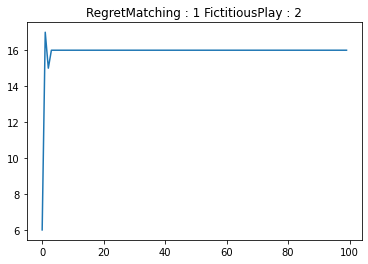

[DEBUG] (Player 1  ) Expected utility  [1.     1.325  1.1125 1.1375]
[DEBUG] (Player 1  ) Expected utility  [1.12847222 1.34027778 1.17361111 0.80208333]
[DEBUG] (Player 1  ) Expected utility  [0.91358025 2.15802469 0.92098765 0.61234568]
[DEBUG] (Player 1  ) Expected utility  [0.91358025 2.15802469 0.92098765 0.61234568]
[DEBUG] (Player 1  ) Expected utility  [0.76131687 2.69753086 0.76748971 0.51028807]
[DEBUG] (Player 1  ) Expected utility  [0.76131687 2.69753086 0.76748971 0.51028807]
[DEBUG] (Player 1  ) Expected utility  [0.65255732 3.08289242 0.65784832 0.43738977]
[DEBUG] (Player 1  ) Expected utility  [0.65255732 3.08289242 0.65784832 0.43738977]
[DEBUG] (Player 1  ) Expected utility  [0.57098765 3.37191358 0.57561728 0.38271605]
[DEBUG] (Player 1  ) Expected utility  [0.57098765 3.37191358 0.57561728 0.38271605]
[DEBUG] (Player 1  ) Expected utility  [0.57407407 3.55555556 0.52204586 0.38888889]
[DEBUG] (Player 1  ) Expected utility  [0.56689342 3.28231293 0.52380952 0.388322

[DEBUG] (Player 1  ) Expected utility  [0.0955669  4.83595151 0.09338398 0.07799805]
[DEBUG] (Player 1  ) Expected utility  [0.09376375 4.8415379  0.09162202 0.07652639]
[DEBUG] (Player 1  ) Expected utility  [0.09376375 4.8415379  0.09162202 0.07652639]
[DEBUG] (Player 1  ) Expected utility  [0.09166789 4.82934671 0.08946331 0.07570914]
[DEBUG] (Player 1  ) Expected utility  [0.09138754 4.7525222  0.0884674  0.07655704]
[DEBUG] (Player 1  ) Expected utility  [0.08759238 4.76421091 0.08587397 0.07605965]
[DEBUG] (Player 1  ) Expected utility  [0.08759238 4.76421091 0.08587397 0.07605965]
[DEBUG] (Player 1  ) Expected utility  [0.08602823 4.7691191  0.0843405  0.07470144]
[DEBUG] (Player 1  ) Expected utility  [0.08602823 4.7691191  0.0843405  0.07470144]
[DEBUG] (Player 1  ) Expected utility  [0.08451897 4.77385506 0.08286084 0.07339089]
[DEBUG] (Player 1  ) Expected utility  [0.08451897 4.77385506 0.08286084 0.07339089]
[DEBUG] (Player 1  ) Expected utility  [0.08306174 4.77842772 0.0

[DEBUG] (Player 1  ) Expected utility  [0.04578384 5.26782654 0.04788927 0.04357955]
[DEBUG] (Player 1  ) Expected utility  [0.04578384 5.26782654 0.04788927 0.04357955]
[DEBUG] (Player 1  ) Expected utility  [0.04533498 5.26940752 0.04741976 0.0431523 ]
[DEBUG] (Player 1  ) Expected utility  [0.04533498 5.26940752 0.04741976 0.0431523 ]
[DEBUG] (Player 1  ) Expected utility  [0.04489483 5.2709578  0.04695938 0.04273335]
[DEBUG] (Player 1  ) Expected utility  [0.04489483 5.2709578  0.04695938 0.04273335]
[DEBUG] (Player 1  ) Expected utility  [0.04381039 5.24856567 0.04602763 0.04270177]
[DEBUG] (Player 1  ) Expected utility  [0.04393974 5.25417036 0.0461621  0.04259953]
[DEBUG] (Player 1  ) Expected utility  [0.04352127 5.25565669 0.04572246 0.04219382]
[DEBUG] (Player 1  ) Expected utility  [0.04352127 5.25565669 0.04572246 0.04219382]
[DEBUG] (Player 1  ) Expected utility  [0.04311069 5.25711498 0.04529112 0.04179576]
[DEBUG] (Player 1  ) Expected utility  [0.04311069 5.25711498 0.0

[DEBUG] (Player 1  ) Expected utility  [0.03141905 5.23044053 0.0319474  0.02957508]
[DEBUG] (Player 1  ) Expected utility  [0.03120959 5.23115702 0.03173441 0.02937792]
[DEBUG] (Player 1  ) Expected utility  [0.03120959 5.23115702 0.03173441 0.02937792]
[DEBUG] (Player 1  ) Expected utility  [0.03100291 5.23186403 0.03152425 0.02918336]
[DEBUG] (Player 1  ) Expected utility  [0.03100291 5.23186403 0.03152425 0.02918336]
[DEBUG] (Player 1  ) Expected utility  [0.03079894 5.23256174 0.03131685 0.02899136]
[DEBUG] (Player 1  ) Expected utility  [0.03079894 5.23256174 0.03131685 0.02899136]
[DEBUG] (Player 1  ) Expected utility  [0.03059764 5.23325032 0.03111217 0.02880188]
[DEBUG] (Player 1  ) Expected utility  [0.03059764 5.23325032 0.03111217 0.02880188]
[DEBUG] (Player 1  ) Expected utility  [0.03014948 5.27184392 0.03109887 0.0286782 ]
[DEBUG] (Player 1  ) Expected utility  [0.02993342 5.30029713 0.0312033  0.02848554]
[DEBUG] (Player 1  ) Expected utility  [0.0297403  5.30097651 0.0

[DEBUG] (Player 1  ) Expected utility  [0.02361051 5.28439938 0.02441296 0.02197182]
[DEBUG] (Player 1  ) Expected utility  [0.02361051 5.28439938 0.02441296 0.02197182]
[DEBUG] (Player 1  ) Expected utility  [0.02330836 5.27367501 0.02415813 0.02196852]
[DEBUG] (Player 1  ) Expected utility  [0.02304994 5.27922533 0.02417714 0.02183761]
[DEBUG] (Player 1  ) Expected utility  [0.02293469 5.27962935 0.02405625 0.02172842]
[DEBUG] (Player 1  ) Expected utility  [0.02293469 5.27962935 0.02405625 0.02172842]
[DEBUG] (Player 1  ) Expected utility  [0.02282059 5.28002935 0.02393657 0.02162032]
[DEBUG] (Player 1  ) Expected utility  [0.02282059 5.28002935 0.02393657 0.02162032]
[DEBUG] (Player 1  ) Expected utility  [0.02270761 5.28042539 0.02381807 0.02151329]
[DEBUG] (Player 1  ) Expected utility  [0.02270761 5.28042539 0.02381807 0.02151329]
[DEBUG] (Player 1  ) Expected utility  [0.02259575 5.28081753 0.02370074 0.02140731]
[DEBUG] (Player 1  ) Expected utility  [0.02259575 5.28081753 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01878917 5.1981756  0.01942271 0.01752909]
[DEBUG] (Player 1  ) Expected utility  [0.0187131  5.19843542 0.01934408 0.01745812]
[DEBUG] (Player 1  ) Expected utility  [0.0187131  5.19843542 0.01934408 0.01745812]
[DEBUG] (Player 1  ) Expected utility  [0.01863764 5.19869314 0.01926608 0.01738773]
[DEBUG] (Player 1  ) Expected utility  [0.01863764 5.19869314 0.01926608 0.01738773]
[DEBUG] (Player 1  ) Expected utility  [0.01857437 5.20088283 0.0192041  0.01733168]
[DEBUG] (Player 1  ) Expected utility  [0.0187513  5.19325513 0.01922004 0.01735331]
[DEBUG] (Player 1  ) Expected utility  [0.0186763  5.19350846 0.01914316 0.0172839 ]
[DEBUG] (Player 1  ) Expected utility  [0.0186763  5.19350846 0.01914316 0.0172839 ]
[DEBUG] (Player 1  ) Expected utility  [0.01860189 5.19375977 0.01906689 0.01721504]
[DEBUG] (Player 1  ) Expected utility  [0.01860189 5.19375977 0.01906689 0.01721504]
[DEBUG] (Player 1  ) Expected utility  [0.01852807 5.19400909 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01559198 5.2808417  0.0161902  0.01492866]
[DEBUG] (Player 1  ) Expected utility  [0.01559198 5.2808417  0.0161902  0.01492866]
[DEBUG] (Player 1  ) Expected utility  [0.01553931 5.28102499 0.01613551 0.01487823]
[DEBUG] (Player 1  ) Expected utility  [0.01553931 5.28102499 0.01613551 0.01487823]
[DEBUG] (Player 1  ) Expected utility  [0.01548699 5.28120705 0.01608118 0.01482813]
[DEBUG] (Player 1  ) Expected utility  [0.01548699 5.28120705 0.01608118 0.01482813]
[DEBUG] (Player 1  ) Expected utility  [0.01543502 5.28138789 0.01602721 0.01477837]
[DEBUG] (Player 1  ) Expected utility  [0.01543502 5.28138789 0.01602721 0.01477837]
[DEBUG] (Player 1  ) Expected utility  [0.01544593 5.27002318 0.01596521 0.01476196]
[DEBUG] (Player 1  ) Expected utility  [0.0154294  5.26434983 0.01590156 0.01484374]
[DEBUG] (Player 1  ) Expected utility  [0.01537796 5.26452768 0.01584855 0.01479426]
[DEBUG] (Player 1  ) Expected utility  [0.01537796 5.26452768 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01361999 5.175953   0.01383408 0.01276594]
[DEBUG] (Player 1  ) Expected utility  [0.01361999 5.175953   0.01383408 0.01276594]
[DEBUG] (Player 1  ) Expected utility  [0.01358039 5.17608576 0.01379387 0.01272883]
[DEBUG] (Player 1  ) Expected utility  [0.01348134 5.16946163 0.01374943 0.01272677]
[DEBUG] (Player 1  ) Expected utility  [0.01344226 5.16959345 0.01370958 0.01268988]
[DEBUG] (Player 1  ) Expected utility  [0.01344226 5.16959345 0.01370958 0.01268988]
[DEBUG] (Player 1  ) Expected utility  [0.01340341 5.16972451 0.01366996 0.01265321]
[DEBUG] (Player 1  ) Expected utility  [0.01340341 5.16972451 0.01366996 0.01265321]
[DEBUG] (Player 1  ) Expected utility  [0.01336479 5.16985482 0.01363056 0.01261674]
[DEBUG] (Player 1  ) Expected utility  [0.01336479 5.16985482 0.01363056 0.01261674]
[DEBUG] (Player 1  ) Expected utility  [0.01332638 5.16998438 0.01359139 0.01258049]
[DEBUG] (Player 1  ) Expected utility  [0.01332638 5.16998438 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01193103 5.13493423 0.0121131  0.011113  ]
[DEBUG] (Player 1  ) Expected utility  [0.01190059 5.13503551 0.0120822  0.01108465]
[DEBUG] (Player 1  ) Expected utility  [0.01190059 5.13503551 0.0120822  0.01108465]
[DEBUG] (Player 1  ) Expected utility  [0.01187031 5.13513628 0.01205145 0.01105645]
[DEBUG] (Player 1  ) Expected utility  [0.01187031 5.13513628 0.01205145 0.01105645]
[DEBUG] (Player 1  ) Expected utility  [0.01183587 5.13909343 0.01203098 0.01102027]
[DEBUG] (Player 1  ) Expected utility  [0.01179426 5.14670352 0.01205793 0.01101114]
[DEBUG] (Player 1  ) Expected utility  [0.0117644  5.1468035  0.0120274  0.01098327]
[DEBUG] (Player 1  ) Expected utility  [0.0117644  5.1468035  0.0120274  0.01098327]
[DEBUG] (Player 1  ) Expected utility  [0.01173469 5.14690296 0.01199703 0.01095553]
[DEBUG] (Player 1  ) Expected utility  [0.01173469 5.14690296 0.01199703 0.01095553]
[DEBUG] (Player 1  ) Expected utility  [0.01170513 5.14700193 0.0

[DEBUG] (Player 1  ) Expected utility  [0.010573   5.15101727 0.0107634  0.00990117]
[DEBUG] (Player 1  ) Expected utility  [0.010573   5.15101727 0.0107634  0.00990117]
[DEBUG] (Player 1  ) Expected utility  [0.01054902 5.15109746 0.010739   0.00987872]
[DEBUG] (Player 1  ) Expected utility  [0.01054902 5.15109746 0.010739   0.00987872]
[DEBUG] (Player 1  ) Expected utility  [0.01052515 5.15117728 0.0107147  0.00985637]
[DEBUG] (Player 1  ) Expected utility  [0.01052515 5.15117728 0.0107147  0.00985637]
[DEBUG] (Player 1  ) Expected utility  [0.0105014  5.15125674 0.01069051 0.00983412]
[DEBUG] (Player 1  ) Expected utility  [0.0105014  5.15125674 0.01069051 0.00983412]
[DEBUG] (Player 1  ) Expected utility  [0.01048085 5.15240167 0.01067061 0.00981626]
[DEBUG] (Player 1  ) Expected utility  [0.01046713 5.14487594 0.01065707 0.00982046]
[DEBUG] (Player 1  ) Expected utility  [0.01044361 5.14495459 0.01063312 0.0097984 ]
[DEBUG] (Player 1  ) Expected utility  [0.01044361 5.14495459 0.0

[DEBUG] (Player 1  ) Expected utility  [0.00959499 5.15342265 0.00976299 0.00882937]
[DEBUG] (Player 1  ) Expected utility  [0.00957144 5.15717688 0.00974911 0.00881239]
[DEBUG] (Player 1  ) Expected utility  [0.00959079 5.14931805 0.00974172 0.00882019]
[DEBUG] (Player 1  ) Expected utility  [0.00960128 5.15553718 0.00971643 0.00882496]
[DEBUG] (Player 1  ) Expected utility  [0.00960128 5.15553718 0.00971643 0.00882496]
[DEBUG] (Player 1  ) Expected utility  [0.00958172 5.15560186 0.00969664 0.00880699]
[DEBUG] (Player 1  ) Expected utility  [0.00958172 5.15560186 0.00969664 0.00880699]
[DEBUG] (Player 1  ) Expected utility  [0.00956225 5.15566628 0.00967693 0.00878909]
[DEBUG] (Player 1  ) Expected utility  [0.00956225 5.15566628 0.00967693 0.00878909]
[DEBUG] (Player 1  ) Expected utility  [0.00954285 5.15573044 0.00965731 0.00877126]
[DEBUG] (Player 1  ) Expected utility  [0.00954285 5.15573044 0.00965731 0.00877126]
[DEBUG] (Player 1  ) Expected utility  [0.00953105 5.15271935 0.0

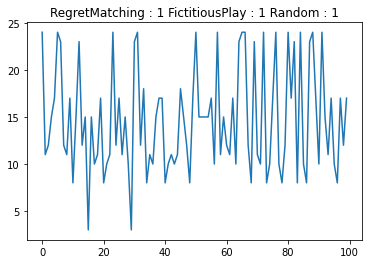

[DEBUG] (Player 1  ) Expected utility  [1.05   1.075  1.1625 0.9   ]
[DEBUG] (Player 1  ) Expected utility  [1.22530864 1.33641975 1.24382716 0.92592593]
[DEBUG] (Player 1  ) Expected utility  [0.98024691 2.1382716  0.99506173 0.74074074]
[DEBUG] (Player 1  ) Expected utility  [0.98024691 2.1382716  0.99506173 0.74074074]
[DEBUG] (Player 1  ) Expected utility  [0.81687243 2.67283951 0.82921811 0.61728395]
[DEBUG] (Player 1  ) Expected utility  [0.81687243 2.67283951 0.82921811 0.61728395]
[DEBUG] (Player 1  ) Expected utility  [0.70017637 3.05467372 0.71075838 0.52910053]
[DEBUG] (Player 1  ) Expected utility  [0.70017637 3.05467372 0.71075838 0.52910053]
[DEBUG] (Player 1  ) Expected utility  [0.61265432 3.34104938 0.62191358 0.46296296]
[DEBUG] (Player 1  ) Expected utility  [0.61265432 3.34104938 0.62191358 0.46296296]
[DEBUG] (Player 1  ) Expected utility  [0.56228956 3.76430976 0.5308642  0.3973064 ]
[DEBUG] (Player 1  ) Expected utility  [0.57936508 3.95767196 0.50970018 0.383597

[DEBUG] (Player 1  ) Expected utility  [0.14002321 1.27418355 0.01630922 0.11801599]
[DEBUG] (Player 1  ) Expected utility  [0.13738127 1.27565546 0.0160015  0.11578927]
[DEBUG] (Player 1  ) Expected utility  [0.13738127 1.27565546 0.0160015  0.11578927]
[DEBUG] (Player 1  ) Expected utility  [0.13517676 1.2678507  0.01551031 0.11383655]
[DEBUG] (Player 1  ) Expected utility  [0.13590709 1.17560407 0.01437965 0.11490951]
[DEBUG] (Player 1  ) Expected utility  [0.13343606 1.1768614  0.0141182  0.11282024]
[DEBUG] (Player 1  ) Expected utility  [0.13343606 1.1768614  0.0141182  0.11282024]
[DEBUG] (Player 1  ) Expected utility  [0.13105327 1.17807383 0.01386609 0.1108056 ]
[DEBUG] (Player 1  ) Expected utility  [0.13105327 1.17807383 0.01386609 0.1108056 ]
[DEBUG] (Player 1  ) Expected utility  [0.12875409 1.17924371 0.01362282 0.10886164]
[DEBUG] (Player 1  ) Expected utility  [0.12875409 1.17924371 0.01362282 0.10886164]
[DEBUG] (Player 1  ) Expected utility  [0.12653419 1.18037326 0.0

[DEBUG] (Player 1  ) Expected utility  [0.07541266 0.70359094 0.00436921 0.06471436]
[DEBUG] (Player 1  ) Expected utility  [0.07541266 0.70359094 0.00436921 0.06471436]
[DEBUG] (Player 1  ) Expected utility  [0.07467332 0.7038021  0.00432638 0.0640799 ]
[DEBUG] (Player 1  ) Expected utility  [0.07467332 0.7038021  0.00432638 0.0640799 ]
[DEBUG] (Player 1  ) Expected utility  [0.07394834 0.70400916 0.00428438 0.06345777]
[DEBUG] (Player 1  ) Expected utility  [0.07394834 0.70400916 0.00428438 0.06345777]
[DEBUG] (Player 1  ) Expected utility  [0.07332155 0.69889494 0.00419698 0.06289951]
[DEBUG] (Player 1  ) Expected utility  [0.07340178 0.67296605 0.00404897 0.06304507]
[DEBUG] (Player 1  ) Expected utility  [0.07270271 0.67315642 0.0040104  0.06244464]
[DEBUG] (Player 1  ) Expected utility  [0.07270271 0.67315642 0.0040104  0.06244464]
[DEBUG] (Player 1  ) Expected utility  [0.07201684 0.6733432  0.00397257 0.06185554]
[DEBUG] (Player 1  ) Expected utility  [0.07201684 0.6733432  0.0

[DEBUG] (Player 1  ) Expected utility  [0.05190974 0.49825999 0.00205267 0.04480171]
[DEBUG] (Player 1  ) Expected utility  [0.05159161 0.48524793 0.00198825 0.04455361]
[DEBUG] (Player 1  ) Expected utility  [0.05159161 0.48524793 0.00198825 0.04455361]
[DEBUG] (Player 1  ) Expected utility  [0.05124995 0.48531352 0.00197508 0.04425855]
[DEBUG] (Player 1  ) Expected utility  [0.05124995 0.48531352 0.00197508 0.04425855]
[DEBUG] (Player 1  ) Expected utility  [0.05091277 0.48537824 0.00196209 0.04396737]
[DEBUG] (Player 1  ) Expected utility  [0.05091277 0.48537824 0.00196209 0.04396737]
[DEBUG] (Player 1  ) Expected utility  [0.05058001 0.48544211 0.00194926 0.04368001]
[DEBUG] (Player 1  ) Expected utility  [0.05058001 0.48544211 0.00194926 0.04368001]
[DEBUG] (Player 1  ) Expected utility  [0.0502784  0.48285158 0.00192212 0.04341336]
[DEBUG] (Player 1  ) Expected utility  [0.0502784  0.48285158 0.00192212 0.04341336]
[DEBUG] (Player 1  ) Expected utility  [0.04997939 0.47063675 0.0

[DEBUG] (Player 1  ) Expected utility  [0.03937853 0.37933118 0.00116605 0.0341079 ]
[DEBUG] (Player 1  ) Expected utility  [0.03937853 0.37933118 0.00116605 0.0341079 ]
[DEBUG] (Player 1  ) Expected utility  [0.03918578 0.37868836 0.00115744 0.03393979]
[DEBUG] (Player 1  ) Expected utility  [0.03919573 0.37617844 0.001149   0.03394903]
[DEBUG] (Player 1  ) Expected utility  [0.03900928 0.37025074 0.00112613 0.0337965 ]
[DEBUG] (Player 1  ) Expected utility  [0.03900928 0.37025074 0.00112613 0.0337965 ]
[DEBUG] (Player 1  ) Expected utility  [0.0388152  0.3702788  0.00112053 0.03362835]
[DEBUG] (Player 1  ) Expected utility  [0.0388152  0.3702788  0.00112053 0.03362835]
[DEBUG] (Player 1  ) Expected utility  [0.03862304 0.37030657 0.00111498 0.03346188]
[DEBUG] (Player 1  ) Expected utility  [0.03862304 0.37030657 0.00111498 0.03346188]
[DEBUG] (Player 1  ) Expected utility  [0.03843278 0.37033407 0.00110949 0.03329704]
[DEBUG] (Player 1  ) Expected utility  [0.03843278 0.37033407 0.0

[DEBUG] (Player 1  ) Expected utility  [0.03185872 0.30514712 0.00075025 0.02765101]
[DEBUG] (Player 1  ) Expected utility  [0.03172974 0.30516238 0.00074721 0.02753906]
[DEBUG] (Player 1  ) Expected utility  [0.03172974 0.30516238 0.00074721 0.02753906]
[DEBUG] (Player 1  ) Expected utility  [0.03160179 0.3051775  0.0007442  0.02742802]
[DEBUG] (Player 1  ) Expected utility  [0.03160179 0.3051775  0.0007442  0.02742802]
[DEBUG] (Player 1  ) Expected utility  [0.03147752 0.30475244 0.0007398  0.02731957]
[DEBUG] (Player 1  ) Expected utility  [0.0314876  0.2992675  0.00072663 0.02733328]
[DEBUG] (Player 1  ) Expected utility  [0.03136165 0.2992821  0.00072373 0.02722394]
[DEBUG] (Player 1  ) Expected utility  [0.03136165 0.2992821  0.00072373 0.02722394]
[DEBUG] (Player 1  ) Expected utility  [0.0312367  0.29929658 0.00072084 0.02711548]
[DEBUG] (Player 1  ) Expected utility  [0.0312367  0.29929658 0.00072084 0.02711548]
[DEBUG] (Player 1  ) Expected utility  [0.03111274 0.29931095 0.0

[DEBUG] (Player 1  ) Expected utility  [0.02665829 0.25523834 0.0005211  0.02316889]
[DEBUG] (Player 1  ) Expected utility  [0.02665829 0.25523834 0.0005211  0.02316889]
[DEBUG] (Player 1  ) Expected utility  [0.02656823 0.2552472  0.00051933 0.02309062]
[DEBUG] (Player 1  ) Expected utility  [0.02656823 0.2552472  0.00051933 0.02309062]
[DEBUG] (Player 1  ) Expected utility  [0.02647877 0.255256   0.00051759 0.02301287]
[DEBUG] (Player 1  ) Expected utility  [0.02647877 0.255256   0.00051759 0.02301287]
[DEBUG] (Player 1  ) Expected utility  [0.02638992 0.25526474 0.00051585 0.02293565]
[DEBUG] (Player 1  ) Expected utility  [0.02638992 0.25526474 0.00051585 0.02293565]
[DEBUG] (Player 1  ) Expected utility  [0.02630395 0.25480966 0.00051291 0.02286043]
[DEBUG] (Player 1  ) Expected utility  [0.02630395 0.25480966 0.00051291 0.02286043]
[DEBUG] (Player 1  ) Expected utility  [0.02622136 0.25113151 0.00050399 0.02279169]
[DEBUG] (Player 1  ) Expected utility  [0.02622136 0.25113151 0.0

[DEBUG] (Player 1  ) Expected utility  [0.02297904 0.22250769 0.00038959 0.01998891]
[DEBUG] (Player 1  ) Expected utility  [0.02291325 0.22227658 0.00038792 0.01993146]
[DEBUG] (Player 1  ) Expected utility  [0.02291613 0.2195903  0.00038342 0.01993609]
[DEBUG] (Player 1  ) Expected utility  [0.0228507  0.21936295 0.00038178 0.01987894]
[DEBUG] (Player 1  ) Expected utility  [0.0228507  0.21936295 0.00038178 0.01987894]
[DEBUG] (Player 1  ) Expected utility  [0.02278465 0.21936851 0.00038068 0.01982149]
[DEBUG] (Player 1  ) Expected utility  [0.02278465 0.21936851 0.00038068 0.01982149]
[DEBUG] (Player 1  ) Expected utility  [0.02271899 0.21937404 0.00037958 0.01976437]
[DEBUG] (Player 1  ) Expected utility  [0.02271899 0.21937404 0.00037958 0.01976437]
[DEBUG] (Player 1  ) Expected utility  [0.02265371 0.21937953 0.00037849 0.01970757]
[DEBUG] (Player 1  ) Expected utility  [0.02265371 0.21937953 0.00037849 0.01970757]
[DEBUG] (Player 1  ) Expected utility  [0.02259024 0.2190405  0.0

[DEBUG] (Player 1  ) Expected utility  [0.02019616 0.19473105 0.00029842 0.01758127]
[DEBUG] (Player 1  ) Expected utility  [0.02014464 0.19473489 0.00029765 0.01753642]
[DEBUG] (Player 1  ) Expected utility  [0.02014464 0.19473489 0.00029765 0.01753642]
[DEBUG] (Player 1  ) Expected utility  [0.02009338 0.19473871 0.0002969  0.01749179]
[DEBUG] (Player 1  ) Expected utility  [0.02009338 0.19473871 0.0002969  0.01749179]
[DEBUG] (Player 1  ) Expected utility  [0.02004306 0.19456038 0.00029579 0.01744784]
[DEBUG] (Player 1  ) Expected utility  [0.02004565 0.19232341 0.00029243 0.01745136]
[DEBUG] (Player 1  ) Expected utility  [0.0199949  0.19232714 0.00029169 0.01740718]
[DEBUG] (Player 1  ) Expected utility  [0.0199949  0.19232714 0.00029169 0.01740718]
[DEBUG] (Player 1  ) Expected utility  [0.0199444  0.19233086 0.00029096 0.01736322]
[DEBUG] (Player 1  ) Expected utility  [0.0199444  0.19233086 0.00029096 0.01736322]
[DEBUG] (Player 1  ) Expected utility  [0.01989417 0.19233456 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01797331 0.17312265 0.00023534 0.01565526]
[DEBUG] (Player 1  ) Expected utility  [0.01797331 0.17312265 0.00023534 0.01565526]
[DEBUG] (Player 1  ) Expected utility  [0.01793255 0.17312535 0.0002348  0.01561976]
[DEBUG] (Player 1  ) Expected utility  [0.01793255 0.17312535 0.0002348  0.01561976]
[DEBUG] (Player 1  ) Expected utility  [0.01789198 0.17312803 0.00023427 0.01558442]
[DEBUG] (Player 1  ) Expected utility  [0.01789198 0.17312803 0.00023427 0.01558442]
[DEBUG] (Player 1  ) Expected utility  [0.01785159 0.1731307  0.00023374 0.01554925]
[DEBUG] (Player 1  ) Expected utility  [0.01785159 0.1731307  0.00023374 0.01554925]
[DEBUG] (Player 1  ) Expected utility  [0.01781233 0.17284586 0.00023272 0.01551484]
[DEBUG] (Player 1  ) Expected utility  [0.01781367 0.17122029 0.00023062 0.015517  ]
[DEBUG] (Player 1  ) Expected utility  [0.01777364 0.17122291 0.0002301  0.01548213]
[DEBUG] (Player 1  ) Expected utility  [0.01777364 0.17122291 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01622264 0.15741058 0.00019267 0.0141363 ]
[DEBUG] (Player 1  ) Expected utility  [0.01618947 0.15741257 0.00019228 0.01410739]
[DEBUG] (Player 1  ) Expected utility  [0.01619068 0.15659826 0.00019122 0.01410858]
[DEBUG] (Player 1  ) Expected utility  [0.01615814 0.15583249 0.00018994 0.01408068]
[DEBUG] (Player 1  ) Expected utility  [0.01615814 0.15583249 0.00018994 0.01408068]
[DEBUG] (Player 1  ) Expected utility  [0.01612523 0.15583444 0.00018956 0.01405201]
[DEBUG] (Player 1  ) Expected utility  [0.01612523 0.15583444 0.00018956 0.01405201]
[DEBUG] (Player 1  ) Expected utility  [0.01609245 0.15583639 0.00018917 0.01402345]
[DEBUG] (Player 1  ) Expected utility  [0.01609245 0.15583639 0.00018917 0.01402345]
[DEBUG] (Player 1  ) Expected utility  [0.01605981 0.15583833 0.00018879 0.013995  ]
[DEBUG] (Player 1  ) Expected utility  [0.01605981 0.15583833 0.00018879 0.013995  ]
[DEBUG] (Player 1  ) Expected utility  [0.01602799 0.15560665 0.0

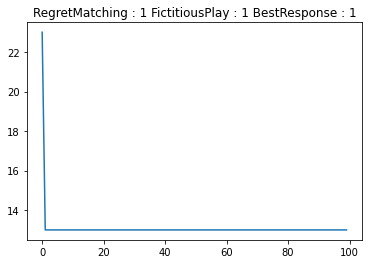

[DEBUG] (Player 1  ) Expected utility  [1.1125 1.4125 1.1875 1.    ]
[DEBUG] (Player 1  ) Expected utility  [0.76851852 1.62345679 1.04012346 1.06790123]
[DEBUG] (Player 1  ) Expected utility  [0.61481481 2.59753086 0.83209877 0.85432099]
[DEBUG] (Player 1  ) Expected utility  [0.61481481 2.59753086 0.83209877 0.85432099]
[DEBUG] (Player 1  ) Expected utility  [0.51234568 3.24691358 0.69341564 0.71193416]
[DEBUG] (Player 1  ) Expected utility  [0.51234568 3.24691358 0.69341564 0.71193416]
[DEBUG] (Player 1  ) Expected utility  [0.43915344 3.71075838 0.59435626 0.61022928]
[DEBUG] (Player 1  ) Expected utility  [0.43915344 3.71075838 0.59435626 0.61022928]
[DEBUG] (Player 1  ) Expected utility  [0.38425926 4.05864198 0.52006173 0.53395062]
[DEBUG] (Player 1  ) Expected utility  [0.38425926 4.05864198 0.52006173 0.53395062]
[DEBUG] (Player 1  ) Expected utility  [0.36507937 4.39153439 0.36684303 0.59259259]
[DEBUG] (Player 1  ) Expected utility  [0.40759637 3.80952381 0.33219955 0.619047

[DEBUG] (Player 1  ) Expected utility  [0.06957634 4.73415902 0.09201224 0.0966023 ]
[DEBUG] (Player 1  ) Expected utility  [0.06826358 4.73962782 0.09027616 0.09477962]
[DEBUG] (Player 1  ) Expected utility  [0.06826358 4.73962782 0.09027616 0.09477962]
[DEBUG] (Player 1  ) Expected utility  [0.06579712 4.53250331 0.09266234 0.09173816]
[DEBUG] (Player 1  ) Expected utility  [0.06410461 4.56757318 0.09364061 0.09260855]
[DEBUG] (Player 1  ) Expected utility  [0.06293907 4.57245828 0.09193805 0.09092476]
[DEBUG] (Player 1  ) Expected utility  [0.06293907 4.57245828 0.09193805 0.09092476]
[DEBUG] (Player 1  ) Expected utility  [0.06181516 4.57716892 0.0902963  0.0893011 ]
[DEBUG] (Player 1  ) Expected utility  [0.06181516 4.57716892 0.0902963  0.0893011 ]
[DEBUG] (Player 1  ) Expected utility  [0.06073068 4.58171427 0.08871216 0.08773442]
[DEBUG] (Player 1  ) Expected utility  [0.06073068 4.58171427 0.08871216 0.08773442]
[DEBUG] (Player 1  ) Expected utility  [0.0596836  4.58610288 0.0

[DEBUG] (Player 1  ) Expected utility  [0.03642477 4.67027213 0.04747459 0.05138519]
[DEBUG] (Player 1  ) Expected utility  [0.03642477 4.67027213 0.04747459 0.05138519]
[DEBUG] (Player 1  ) Expected utility  [0.03606766 4.67167377 0.04700915 0.05088141]
[DEBUG] (Player 1  ) Expected utility  [0.03606766 4.67167377 0.04700915 0.05088141]
[DEBUG] (Player 1  ) Expected utility  [0.03571749 4.6730482  0.04655275 0.05038742]
[DEBUG] (Player 1  ) Expected utility  [0.03571749 4.6730482  0.04655275 0.05038742]
[DEBUG] (Player 1  ) Expected utility  [0.0348318  4.755472   0.04525703 0.05012464]
[DEBUG] (Player 1  ) Expected utility  [0.03423372 4.81130263 0.04534389 0.05029362]
[DEBUG] (Player 1  ) Expected utility  [0.03390768 4.81266368 0.04491204 0.04981463]
[DEBUG] (Player 1  ) Expected utility  [0.03390768 4.81266368 0.04491204 0.04981463]
[DEBUG] (Player 1  ) Expected utility  [0.0335878  4.81399904 0.04448835 0.04934468]
[DEBUG] (Player 1  ) Expected utility  [0.0335878  4.81399904 0.0

[DEBUG] (Player 1  ) Expected utility  [0.02437145 4.7567864  0.03225727 0.03466043]
[DEBUG] (Player 1  ) Expected utility  [0.02420897 4.75743802 0.03204222 0.03442936]
[DEBUG] (Player 1  ) Expected utility  [0.02420897 4.75743802 0.03204222 0.03442936]
[DEBUG] (Player 1  ) Expected utility  [0.02404865 4.758081   0.03183002 0.03420135]
[DEBUG] (Player 1  ) Expected utility  [0.02404865 4.758081   0.03183002 0.03420135]
[DEBUG] (Player 1  ) Expected utility  [0.02389043 4.75871552 0.03162061 0.03397634]
[DEBUG] (Player 1  ) Expected utility  [0.02389043 4.75871552 0.03162061 0.03397634]
[DEBUG] (Player 1  ) Expected utility  [0.02373429 4.75934175 0.03141394 0.03375427]
[DEBUG] (Player 1  ) Expected utility  [0.02373429 4.75934175 0.03141394 0.03375427]
[DEBUG] (Player 1  ) Expected utility  [0.02350452 4.72987706 0.03129307 0.03359634]
[DEBUG] (Player 1  ) Expected utility  [0.02323931 4.71836942 0.0316248  0.03361567]
[DEBUG] (Player 1  ) Expected utility  [0.02308938 4.71897421 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01867883 4.71435052 0.02462213 0.02612083]
[DEBUG] (Player 1  ) Expected utility  [0.0185845  4.71471871 0.02449777 0.02598891]
[DEBUG] (Player 1  ) Expected utility  [0.0185845  4.71471871 0.02449777 0.02598891]
[DEBUG] (Player 1  ) Expected utility  [0.01880065 4.73640149 0.02457999 0.02556642]
[DEBUG] (Player 1  ) Expected utility  [0.01875108 4.74365487 0.0246114  0.02559022]
[DEBUG] (Player 1  ) Expected utility  [0.01858516 4.75463211 0.02453407 0.02549692]
[DEBUG] (Player 1  ) Expected utility  [0.01858516 4.75463211 0.02453407 0.02549692]
[DEBUG] (Player 1  ) Expected utility  [0.0184927  4.75499234 0.02441201 0.02537007]
[DEBUG] (Player 1  ) Expected utility  [0.0184927  4.75499234 0.02441201 0.02537007]
[DEBUG] (Player 1  ) Expected utility  [0.01840115 4.755349   0.02429116 0.02524448]
[DEBUG] (Player 1  ) Expected utility  [0.01840115 4.755349   0.02429116 0.02524448]
[DEBUG] (Player 1  ) Expected utility  [0.0183105  4.75570215 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01483722 4.75931053 0.01970116 0.0208903 ]
[DEBUG] (Player 1  ) Expected utility  [0.01483722 4.75931053 0.01970116 0.0208903 ]
[DEBUG] (Player 1  ) Expected utility  [0.01477715 4.75954841 0.0196214  0.02080572]
[DEBUG] (Player 1  ) Expected utility  [0.01477715 4.75954841 0.0196214  0.02080572]
[DEBUG] (Player 1  ) Expected utility  [0.01471757 4.75978438 0.01954228 0.02072183]
[DEBUG] (Player 1  ) Expected utility  [0.01471757 4.75978438 0.01954228 0.02072183]
[DEBUG] (Player 1  ) Expected utility  [0.01460429 4.72177106 0.01957353 0.02063118]
[DEBUG] (Player 1  ) Expected utility  [0.01452565 4.73479073 0.01962148 0.02067013]
[DEBUG] (Player 1  ) Expected utility  [0.01446754 4.7350217  0.019543   0.02058745]
[DEBUG] (Player 1  ) Expected utility  [0.01446754 4.7350217  0.019543   0.02058745]
[DEBUG] (Player 1  ) Expected utility  [0.0144099  4.73525083 0.01946514 0.02050543]
[DEBUG] (Player 1  ) Expected utility  [0.0144099  4.73525083 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01242061 4.70884052 0.01667767 0.0174723 ]
[DEBUG] (Player 1  ) Expected utility  [0.01237851 4.70900508 0.01662113 0.01741307]
[DEBUG] (Player 1  ) Expected utility  [0.01237851 4.70900508 0.01662113 0.01741307]
[DEBUG] (Player 1  ) Expected utility  [0.01233669 4.70916852 0.01656498 0.01735424]
[DEBUG] (Player 1  ) Expected utility  [0.01233669 4.70916852 0.01656498 0.01735424]
[DEBUG] (Player 1  ) Expected utility  [0.01229515 4.70933087 0.0165092  0.01729581]
[DEBUG] (Player 1  ) Expected utility  [0.01229515 4.70933087 0.0165092  0.01729581]
[DEBUG] (Player 1  ) Expected utility  [0.01225389 4.70949212 0.0164538  0.01723777]
[DEBUG] (Player 1  ) Expected utility  [0.01225389 4.70949212 0.0164538  0.01723777]
[DEBUG] (Player 1  ) Expected utility  [0.01224023 4.70500033 0.01645793 0.01712657]
[DEBUG] (Player 1  ) Expected utility  [0.01229275 4.72677537 0.01658514 0.0170277 ]
[DEBUG] (Player 1  ) Expected utility  [0.01225177 4.72693505 0.0

[DEBUG] (Player 1  ) Expected utility  [0.01066615 4.75975312 0.01418201 0.01494901]
[DEBUG] (Player 1  ) Expected utility  [0.01066615 4.75975312 0.01418201 0.01494901]
[DEBUG] (Player 1  ) Expected utility  [0.01061932 4.74638549 0.01415612 0.01491852]
[DEBUG] (Player 1  ) Expected utility  [0.01056496 4.74178275 0.01422316 0.01492224]
[DEBUG] (Player 1  ) Expected utility  [0.01053434 4.74190367 0.01418194 0.01487899]
[DEBUG] (Player 1  ) Expected utility  [0.01053434 4.74190367 0.01418194 0.01487899]
[DEBUG] (Player 1  ) Expected utility  [0.01050389 4.74202389 0.01414095 0.01483598]
[DEBUG] (Player 1  ) Expected utility  [0.01050389 4.74202389 0.01414095 0.01483598]
[DEBUG] (Player 1  ) Expected utility  [0.01047362 4.74214341 0.0141002  0.01479323]
[DEBUG] (Player 1  ) Expected utility  [0.01047362 4.74214341 0.0141002  0.01479323]
[DEBUG] (Player 1  ) Expected utility  [0.01044352 4.74226225 0.01405968 0.01475072]
[DEBUG] (Player 1  ) Expected utility  [0.01044352 4.74226225 0.0

[DEBUG] (Player 1  ) Expected utility  [0.00932612 4.77597657 0.01242342 0.01313311]
[DEBUG] (Player 1  ) Expected utility  [0.00930233 4.77607077 0.01239173 0.01309961]
[DEBUG] (Player 1  ) Expected utility  [0.00930233 4.77607077 0.01239173 0.01309961]
[DEBUG] (Player 1  ) Expected utility  [0.00927866 4.7761645  0.0123602  0.01306627]
[DEBUG] (Player 1  ) Expected utility  [0.00927866 4.7761645  0.0123602  0.01306627]
[DEBUG] (Player 1  ) Expected utility  [0.00922263 4.75806204 0.01237907 0.01300639]
[DEBUG] (Player 1  ) Expected utility  [0.00919124 4.76650746 0.01239827 0.01302156]
[DEBUG] (Player 1  ) Expected utility  [0.00916797 4.76660004 0.01236688 0.0129886 ]
[DEBUG] (Player 1  ) Expected utility  [0.00916797 4.76660004 0.01236688 0.0129886 ]
[DEBUG] (Player 1  ) Expected utility  [0.00914481 4.76669216 0.01233565 0.0129558 ]
[DEBUG] (Player 1  ) Expected utility  [0.00914481 4.76669216 0.01233565 0.0129558 ]
[DEBUG] (Player 1  ) Expected utility  [0.00912178 4.76678382 0.0

[DEBUG] (Player 1  ) Expected utility  [0.00836563 4.77772266 0.01113672 0.01159065]
[DEBUG] (Player 1  ) Expected utility  [0.00836563 4.77772266 0.01113672 0.01159065]
[DEBUG] (Player 1  ) Expected utility  [0.00834666 4.77779703 0.01111146 0.01156437]
[DEBUG] (Player 1  ) Expected utility  [0.00834666 4.77779703 0.01111146 0.01156437]
[DEBUG] (Player 1  ) Expected utility  [0.00832777 4.77787107 0.01108632 0.0115382 ]
[DEBUG] (Player 1  ) Expected utility  [0.00832777 4.77787107 0.01108632 0.0115382 ]
[DEBUG] (Player 1  ) Expected utility  [0.00830897 4.77794477 0.0110613  0.01151216]
[DEBUG] (Player 1  ) Expected utility  [0.00830897 4.77794477 0.0110613  0.01151216]
[DEBUG] (Player 1  ) Expected utility  [0.00830243 4.77460871 0.01106331 0.01146226]
[DEBUG] (Player 1  ) Expected utility  [0.00826533 4.76540077 0.01111574 0.01145995]
[DEBUG] (Player 1  ) Expected utility  [0.00824676 4.76547362 0.01109076 0.0114342 ]
[DEBUG] (Player 1  ) Expected utility  [0.00824676 4.76547362 0.0

[DEBUG] (Player 1  ) Expected utility  [0.00749812 4.75110777 0.01022077 0.01038444]
[DEBUG] (Player 1  ) Expected utility  [0.00749046 4.75676197 0.0101569  0.0104075 ]
[DEBUG] (Player 1  ) Expected utility  [0.00750886 4.75031787 0.01014553 0.01039856]
[DEBUG] (Player 1  ) Expected utility  [0.00752081 4.74080928 0.01010797 0.01036409]
[DEBUG] (Player 1  ) Expected utility  [0.00752081 4.74080928 0.01010797 0.01036409]
[DEBUG] (Player 1  ) Expected utility  [0.0075055  4.74086876 0.01008738 0.01034299]
[DEBUG] (Player 1  ) Expected utility  [0.0075055  4.74086876 0.01008738 0.01034299]
[DEBUG] (Player 1  ) Expected utility  [0.00749024 4.74092799 0.01006688 0.01032196]
[DEBUG] (Player 1  ) Expected utility  [0.00749024 4.74092799 0.01006688 0.01032196]
[DEBUG] (Player 1  ) Expected utility  [0.00747505 4.74098699 0.01004646 0.01030103]
[DEBUG] (Player 1  ) Expected utility  [0.00747505 4.74098699 0.01004646 0.01030103]
[DEBUG] (Player 1  ) Expected utility  [0.0074501  4.74767896 0.0

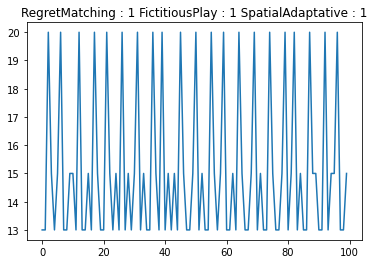

In [8]:
import matplotlib.pyplot as plt 

# run all the experiments and plot the curve
for exp in myexp.keys():
    utility_evolution = []
    #print(exp)
    nb_sync = myexp[exp]["nb_sync"]
    nb_tasks = myexp[exp]["tasks"]
    agents = []
    entrys = myexp[exp].keys()
    #print(entrys)
    res = []
    for i in entrys : # search for Type definitions only
        if len(re.findall('Type*', i)) > 0 :
            res.append(i)
    total_agents = 0
    for t in res :
        nb_t = myexp[exp][t]["number"] # number of agents of this type
        total_agents += nb_t
    #print(total_agents)
    env = Environnement(nb_tasks,total_agents) #creating the environment
    for t in res :
        if np.isin("spec",myexp[exp][t].keys()): # check if extra parameters
            fadding = myexp[exp][t]["spec"]["fadding"]
            inertia = myexp[exp][t]["spec"]["inertia"]
        else:
            fadding = 0
            inertia = 0
        for j in range(myexp[exp][t]["number"]): #create X agents of this type
            ag = getAgent(env, len(agents),myexp[exp][t]["type"], fadding, inertia)
            agents.append(ag)
    #print(agents)
    for steps in range(100):
        threads = []
        for a in agents : # getting agent threads
            t = threading.Thread(name="Player "+str(a.id), target=a.getWorkerFunction(5,verbose=False))
            threads.append(t)
        for th in threads : #starting the threads
            th.start()
        for th in threads : # join all (wait all ended)
            th.join()
        currentAlloc = env.allocation
        #print("alloc : "+str(currentAlloc))
        currentUt = env.utility[tuple(currentAlloc)]
        #print("utility : "+str(currentUt))
        utility_evolution.append(metric("sum", currentUt))
    plt.figure()
    plt.plot(list(range(len(utility_evolution))), utility_evolution)
    plt.title(" ".join([myexp[exp][t]["type"] + " : "+ str(myexp[exp][t]["number"]) for t in res]))
    plt.show()
    #print(env.is_EN())